

# Loan Default Probability 

The goal of this case study is to build a machine learning model to predict the probability that a loan will default.

In [1]:
# Disable the warnings
import warnings
warnings.filterwarnings('ignore')

## Overview

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Data Preparation and Feature Selection](#2)
    * [3.1. Preparing the predicted variable](#2.1)    
    * [3.2. Feature Selection-Limit the Feature Space](#2.2)
        * [3.2.1.  Features elimination by significant missing values ](#2.2.1)
        * [3.2.2.  Features elimination based on the intutiveness](#2.2.2)
        * [3.2.3.  Features elimination based on the correlation](#2.2.3)   
* [4. Feature Engineering and Exploratory Analysis](#3)
    * [4.1 Feature Analysis and Exploration](#3.1)
        * [4.1.1. Analysing the categorical features](#3.1.1)
        * [4.1.2  Analysing the continuous features ](#3.1.2) 
    * [4.2.Encoding Categorical Data](#3.2)
    * [4.3.Sampling Data](#3.3)    
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Test Options and Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)
* [6. Model Tuning and Grid Search](#5)  
* [7. Finalize the Model](#6)  
    * [7.1. Results on test dataset](#6.1)
    * [7.1. Variable Intuition/Feature Selection](#6.2) 
    * [7.3. Save model for later use](#6.3)


<a id='0'></a>
# 1. Problem Definition

This case study aims to analyze data for loans through 2007-2017Q3 from Lending Club available on Kaggle. Dataset contains over 887 thousand observations and 150 variables among which one is describing the loan status. The predicted variable is “Charge-Off ”. A charge-off is a debt that a creditor has given up trying to collect on after you’ve missed payments for several months. We make a model that can predict charge-off.

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

## 2.1. Load all the python packages

In [3]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

<a id='1.2'></a>
## 2.2. Loading the Data

Load the data in this step. This is in the form of a zipped csv file LoansData_sample.csv.gz

In [4]:
dataset = pd.read_csv('LoansData_sample.csv.gz',index_col=0,compression='gzip')

FileNotFoundError: [Errno 2] No such file or directory: 'LoansData_sample.csv.gz'

### Examine the properties of the data frame

In [ ]:
dataset.info()

In [5]:
dataset.shape

NameError: name 'dataset' is not defined

The dataset has 150 columns (features) and 100000 observations (samples)

In [6]:
column_names = list(dataset.columns)

NameError: name 'dataset' is not defined

Describe numerical featurs of the dataset:

In [7]:
for i in range(15):
    print(i*10, (i+1)*10)
    display(dataset.iloc[:,i*10:(i+1)*10].describe())

0 10


NameError: name 'dataset' is not defined

<a id='2'></a>
## 3. Data Preparation and Feature Selection

<a id='2.1'></a>
## 3.1. Preparing the predicted variable


### The column to predict is loan_status. Look at the values it takes and their counts.

There are 7 classes of target variable. One of them (fully paid) is dominant, others are smaller

In [28]:
Counter(dataset['loan_status'])

Counter({'Fully Paid': 69982,
         'Charged Off': 16156,
         'Current': 12726,
         'Late (31-120 days)': 730,
         'In Grace Period': 264,
         'Late (16-30 days)': 139,
         'Default': 3})

### You need to try to learn differences in the features between completed loans that have been fully paid or charged off. Don't consider loans that are current, don't meet the credit policy, defaulted, or have a missing status. So only keep the loans with status "Fully Paid" or "Charged Off." Count the number of each.

In [30]:
dataset = dataset.loc[(dataset['loan_status'] == "Fully Paid") | (dataset['loan_status'] == 'Charged Off'),:]

In [31]:
Counter(dataset['loan_status'])

Counter({'Fully Paid': 69982, 'Charged Off': 16156})

As required, we left only 2 classes

### Is this an unbalanced dataset ?

The dataset is indeed imbalanced, because the "charged off" accounts for 19% and "fully paid" accounts for 81%

In [35]:
print(f'Charged Off: {(16156 / (16156+69982)):.2f}')
print(f'Fully Paid: {(69982 / (16156+69982)):.2f}')

Charged Off: 0.19
Fully Paid: 0.81


### Set the labels to be 1 for Charged off else 0

In [37]:
dataset.loc[dataset['loan_status'] == 'Charged Off','charged_off'] = 1
dataset.loc[dataset['loan_status'] == 'Fully Paid','charged_off'] = 0

<a id='2.2'></a>
## 3.2. Feature Selection-Limit the Feature Space 

The full dataset has 150 features for each
loan. We’ll eliminate
features in following steps using three different approaches:
* Eliminate feature that have more than 30% missing values.
* Eliminate features that are unintuitive based on subjective judgement - I will give you these.
* Eliminate features with low correlation with the predicted variable

<a id='2.2.1'></a>
### 3.2.1.  Features elimination by significant missing values

### Calculating the percentage of missing data for each feature using isnull().mean():

We display 60 worst features

In [43]:
dataset.isnull().mean().sort_values(ascending = False)[:60]

total_cu_tl                                   1.000000
sec_app_fico_range_high                       1.000000
max_bal_bc                                    1.000000
sec_app_collections_12_mths_ex_med            1.000000
sec_app_chargeoff_within_12_mths              1.000000
sec_app_num_rev_accts                         1.000000
open_rv_24m                                   1.000000
sec_app_open_act_il                           1.000000
sec_app_revol_util                            1.000000
sec_app_open_acc                              1.000000
sec_app_mort_acc                              1.000000
sec_app_inq_last_6mths                        1.000000
sec_app_earliest_cr_line                      1.000000
sec_app_fico_range_low                        1.000000
all_util                                      1.000000
revol_bal_joint                               1.000000
open_rv_12m                                   1.000000
il_util                                       1.000000
total_bal_

### Drop the columns with more than 30% of missing data.

In [45]:
features_to_drop = dataset.isnull().mean().index[dataset.isna().mean()>0.3]
dataset = dataset.drop(columns = features_to_drop)

Display those that are left and still have missing values

In [47]:
dataset.isnull().mean().sort_values(ascending = False)[:15]

mths_since_recent_inq    0.095428
emp_title                0.054819
emp_length               0.054761
mo_sin_old_il_acct       0.031566
num_tl_120dpd_2m         0.021140
bc_util                  0.012178
percent_bc_gt_75         0.011853
bc_open_to_buy           0.011563
mths_since_recent_bc     0.010681
last_pymnt_d             0.000778
revol_util               0.000511
last_credit_pull_d       0.000174
mort_acc                 0.000000
mo_sin_rcnt_tl           0.000000
mo_sin_rcnt_rev_tl_op    0.000000
dtype: float64

### How large is the remaining dataset ?

In [49]:
dataset.shape

(86138, 93)

The dataset has only 92 features and 86138 samples left. around 14% of the dataset was deleted due to cleaning of target label, and 58 fatures dropped due to NaN cleaning

<a id='2.2.2'></a>
### 3.2.2.  Features elimination based on the intutiveness

### In order to filter the features further I checked the description in the data dictionary and keep the features that are intuitive on the basis of subjective judgement. To do so I examine the LendingClub website and Data Dictionary to determine which features would have been available to potential investors. Here's the list of features I have decided to keep. Can you do the same.

In [53]:
keep_list = ['charged_off','funded_amnt','addr_state', 'annual_inc', 'application_type', 
             'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 
             'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 
             'installment', 'int_rate', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 
             'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 
             'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code',
             'last_pymnt_amnt','num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op',
             "bc_util","bc_open_to_buy","avg_cur_bal","acc_open_past_24mths" ]

### Drop all of the features except these ones from the dataset.

In [55]:
dataset = dataset.loc[:,keep_list]

### How large is the remaining dataset ?

In [57]:
dataset.shape

(86138, 40)

In [58]:
dataset

charged_off  funded_amnt addr_state  annual_inc application_type  \
0              0.0      15000.0         VA     78000.0       Individual   
1              1.0      10400.0         CA     58000.0       Individual   
2              0.0      21425.0         MO     63800.0       Individual   
4              1.0       7650.0         AZ     50000.0       Individual   
5              0.0       9600.0         NJ     69000.0       Individual   
...            ...          ...        ...         ...              ...   
99994          0.0      15000.0         AR     84136.0       Individual   
99995          0.0       8400.0         IL     91000.0       Individual   
99996          0.0      10000.0         NM     53133.0       Individual   
99998          1.0       8475.0         MO     52000.0       Individual   
99999          0.0      25000.0         IN     60000.0       Individual   

         dti earliest_cr_line emp_length  \
0      12.03         Aug-1994  10+ years   
1      14.92         Sep-1989    8 years   
2      18.49         Aug-2003    6 years   
4      34.81         Aug-2002   < 1 year   
5      25.81         Nov-1992  10+ years   
...      ...              ...        ...   
99994  10.43         Nov-1984  10+ years   
99995   7.78         Aug-1990    2 years   
99996  15.25         May-2001    3 years   
99998  17.61         Nov-2000  10+ years   
99999  27.82         Jul-1999    3 years   

                                      emp_title  fico_range_high  ...  \
0                                    MANAGEMENT            754.0  ...   
1                Truck Driver Delivery Personel            714.0  ...   
2               Programming Analysis Supervisor            689.0  ...   
4                          Technical Specialist            689.0  ...   
5                              Admin Specialist            684.0  ...   
...                                         ...              ...  ...   
99994  Senior Clinical Business Solutions Analy            704.0  ...   
99995                         Software Engineer            709.0  ...   
99996            Assistant Professor of English            694.0  ...   
99998                  Records Examiner Analyst            664.0  ...   
99999             Occupational Theapy Assistant            734.0  ...   

       verification_status zip_code last_pymnt_amnt  num_actv_rev_tl  \
0          Source Verified    235xx        12017.81              4.0   
1             Not Verified    937xx          321.08              9.0   
2          Source Verified    658xx        17813.19              4.0   
4          Source Verified    850xx           17.70              4.0   
5          Source Verified    077xx         9338.58              7.0   
...                    ...      ...             ...              ...   
99994         Not Verified    719xx        10584.91              5.0   
99995      Source Verified    606xx          267.50              2.0   
99996         Not Verified    874xx         5594.78              5.0   
99998             Verified    630xx          336.92              3.0   
99999      Source Verified    468xx         4759.78              7.0   

      mo_sin_rcnt_rev_tl_op  mo_sin_old_rev_tl_op  bc_util  bc_open_to_buy  \
0                       1.0                 244.0      4.7          9525.0   
1                       1.0                 290.0     41.5          7599.0   
2                       7.0                 136.0     97.8           324.0   
4                       8.0                 148.0     93.2           332.0   
5                      23.0                 265.0     69.2          6494.0   
...                     ...                   ...      ...             ...   
99994                   3.0                 356.0     31.3         28091.0   
99995                   5.0                 287.0     77.2          2505.0   
99996                   5.0                 158.0     42.5         13974.0   
99998                   7.0                 164.0     8

<a id='2.2.3'></a>
### 3.2.3.  Features elimination based on the correlation

### Now remove all of the features with a correlation of under 3% with the  charge-off label. List the names of the features you are removing.

Firstly see only numerical columns, categorical are left for future

In [62]:
numerical_columns = dataset.applymap(np.isreal).all()
categorical_columns = numerical_columns.index[numerical_columns == False]
numerical_columns = numerical_columns.index[numerical_columns]

Find correlations and leave the most correlated columns with the target variable (in absolute terms)

In [64]:
correlations = np.abs(dataset.loc[:,numerical_columns].corr()['charged_off']).sort_values(ascending = False)
correlations

charged_off              1.000000
last_pymnt_amnt          0.319081
int_rate                 0.282825
dti                      0.123108
fico_range_low           0.121892
fico_range_high          0.121891
acc_open_past_24mths     0.105989
bc_open_to_buy           0.080077
bc_util                  0.077744
avg_cur_bal              0.071977
num_actv_rev_tl          0.071185
revol_util               0.066188
loan_amnt                0.060818
funded_amnt              0.060818
mort_acc                 0.057858
annual_inc               0.050349
mo_sin_old_rev_tl_op     0.049426
mo_sin_rcnt_rev_tl_op    0.048839
open_acc                 0.039430
installment              0.032847
revol_bal                0.021714
pub_rec                  0.016023
pub_rec_bankruptcies     0.015815
total_acc                0.005804
id                       0.002221
Name: charged_off, dtype: float64

Drop those that are the worst correlated (just 4 features)

In [66]:
bad_correlated_features = correlations.index[correlations < 0.03]
dataset = dataset.drop(columns = bad_correlated_features)

### How large is the resulting dataset ?

In [68]:
dataset.shape

(86138, 35)

<a id='3'></a>
# 4. Feature Engineering and Exploratory Analysis

### Examine the properties of the remaining features.

In [71]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86138 entries, 0 to 99999
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   charged_off            86138 non-null  float64
 1   funded_amnt            86138 non-null  float64
 2   addr_state             86138 non-null  object 
 3   annual_inc             86138 non-null  float64
 4   application_type       86138 non-null  object 
 5   dti                    86138 non-null  float64
 6   earliest_cr_line       86138 non-null  object 
 7   emp_length             81421 non-null  object 
 8   emp_title              81416 non-null  object 
 9   fico_range_high        86138 non-null  float64
 10  fico_range_low         86138 non-null  float64
 11  grade                  86138 non-null  object 
 12  home_ownership         86138 non-null  object 
 13  initial_list_status    86138 non-null  object 
 14  installment            86138 non-null  float64
 15  int_rat

In [72]:
dataset.describe()

charged_off   funded_amnt    annual_inc           dti  \
count  86138.000000  86138.000000  8.613800e+04  86138.000000   
mean       0.187559  14106.526446  7.384311e+04     18.532747   
std        0.390362   8391.139221  5.929352e+04      8.538247   
min        0.000000   1000.000000  4.000000e+03      0.000000   
25%        0.000000   7800.000000  4.500000e+04     12.070000   
50%        0.000000  12000.000000  6.247372e+04     17.950000   
75%        0.000000  20000.000000  9.000000e+04     24.500000   
max        1.000000  35000.000000  7.500000e+06     39.990000   

       fico_range_high  fico_range_low   installment      int_rate  \
count     86138.000000    86138.000000  86138.000000  86138.000000   
mean        696.463024      692.462966    430.737187     13.002360   
std          29.731848       29.731549    251.653139      4.397419   
min         664.000000      660.000000     30.420000      6.000000   
25%         674.000000      670.000000    248.480000      9.490000   
50%         689.000000      685.000000    370.480000     12.990000   
75%         709.000000      705.000000    568.005000     15.610000   
max         850.000000      845.000000   1408.130000     26.060000   

          loan_amnt      mort_acc      open_acc    revol_util  \
count  86138.000000  86138.000000  86138.000000  86094.000000   
mean   14106.526446      1.748880     11.746453     54.582777   
std     8391.139221      2.091488      5.433122     23.515901   
min     1000.000000      0.000000      1.000000      0.000000   
25%     7800.000000      0.000000      8.000000     37.200000   
50%    12000.000000      1.000000     11.000000     54.900000   
75%    20000.000000      3.000000     14.000000     72.500000   
max    35000.000000     34.000000     84.000000    180.300000   

       last_pymnt_amnt  num_actv_rev_tl  mo_sin_rcnt_rev_tl_op  \
count     86138.000000     86138.000000           86138.000000   
mean       4757.453184         5.762358              12.796896   
std        6466.767327         3.224598              16.224586   
min           0.000000         0.000000               0.000000   
25%         358.522500         3.000000               3.000000   
50%        1241.230000         5.000000               8.000000   
75%        7303.205000         7.000000              15.000000   
max       36234.440000        38.000000             372.000000   

       mo_sin_old_rev_tl_op       bc_util  bc_open_to_buy    avg_cur_bal  \
count          86138.000000  85089.000000    85142.000000   86138.000000   
mean             183.524333     63.808959     8942.506507   13066.638371   
std               93.266430     27.051347    14100.186250   16232.739293   
min                3.000000      0.000000        0.000000       0.000000   
25%              118.000000     44.100000     1087.000000    3010.000000   
50%              167.000000     67.700000     3823.000000    6994.500000   
75%              232.000000     87.500000    10588.000000   17905.000000   
max              718.000000    255.200000   249625.000000  447433.000000   

       acc_open_past_24mths  
count          86138.000000  
mean               4.594732  
std                3.070996  
min                0.000000  
25%                2.000000  
50%                4.000000  
75%                6.000000  
max               53.000000

<a id='3.1'></a>
## 4.1 Feature Analysis and Exploration

P.S. 4.1.1 follows 4.1.2. It was more comfortable to work in this way

<a id='3.1.2'></a>
### 4.1.2. Analysing the continuous features 
Firstly, we are looking at histograms of numerical features

In [75]:
# find numerical and categorical features
numerical_columns = dataset.applymap(np.isreal).all()
categorical_columns = list(numerical_columns.index[numerical_columns == False])
numerical_columns = list(numerical_columns.index[numerical_columns])

Make histogreams of numerical features

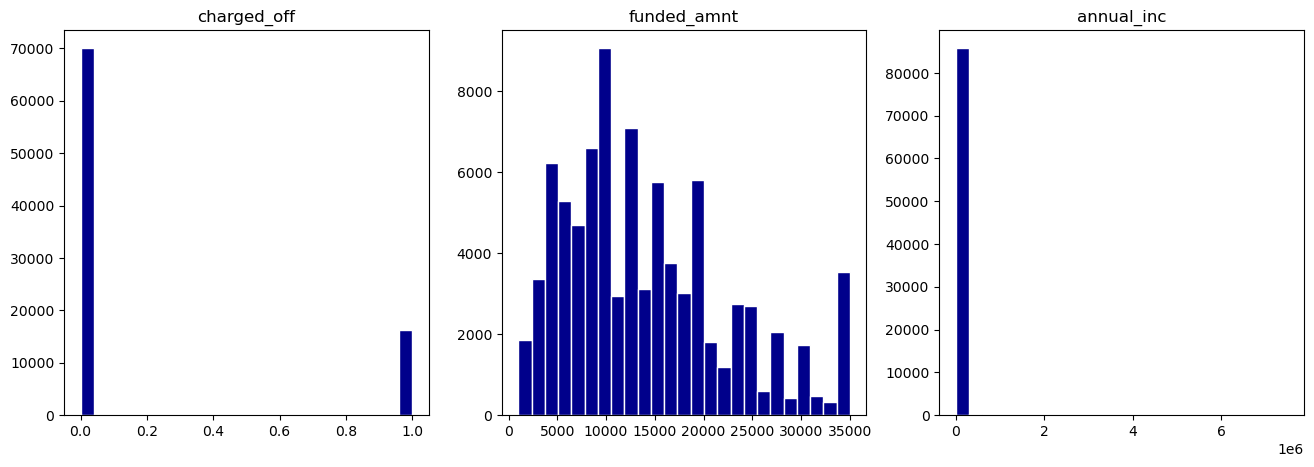

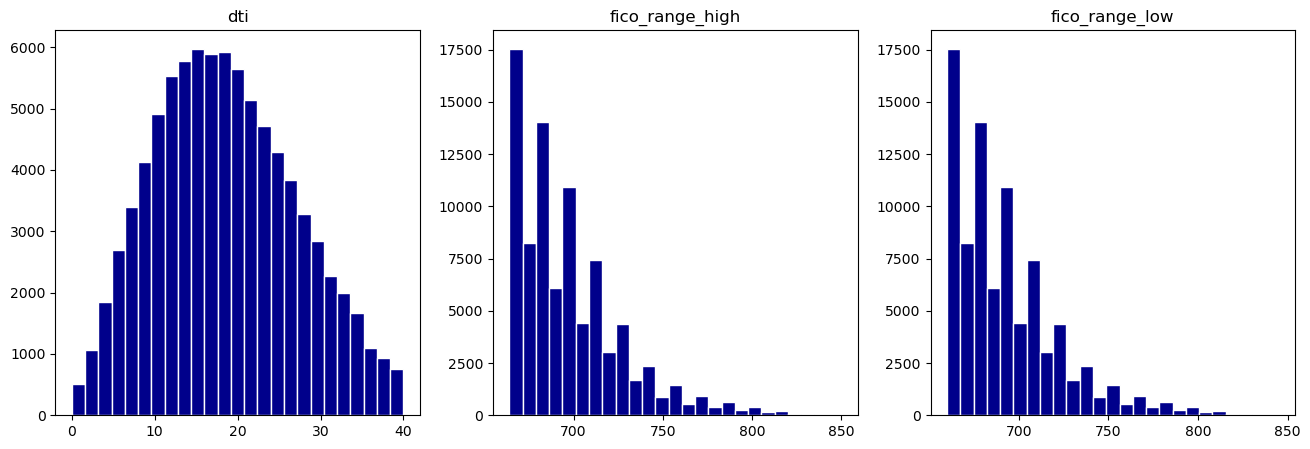

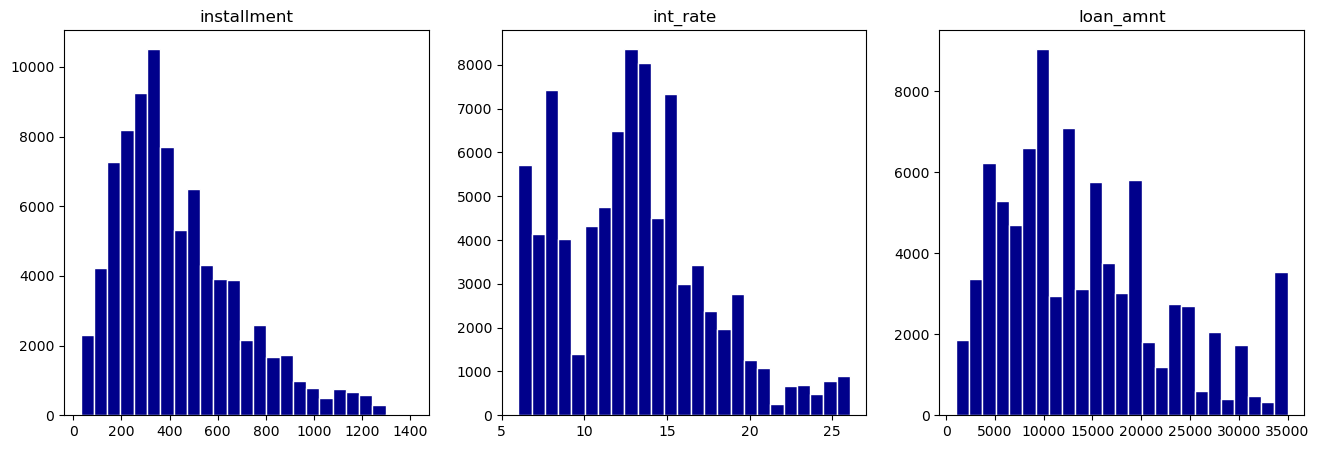

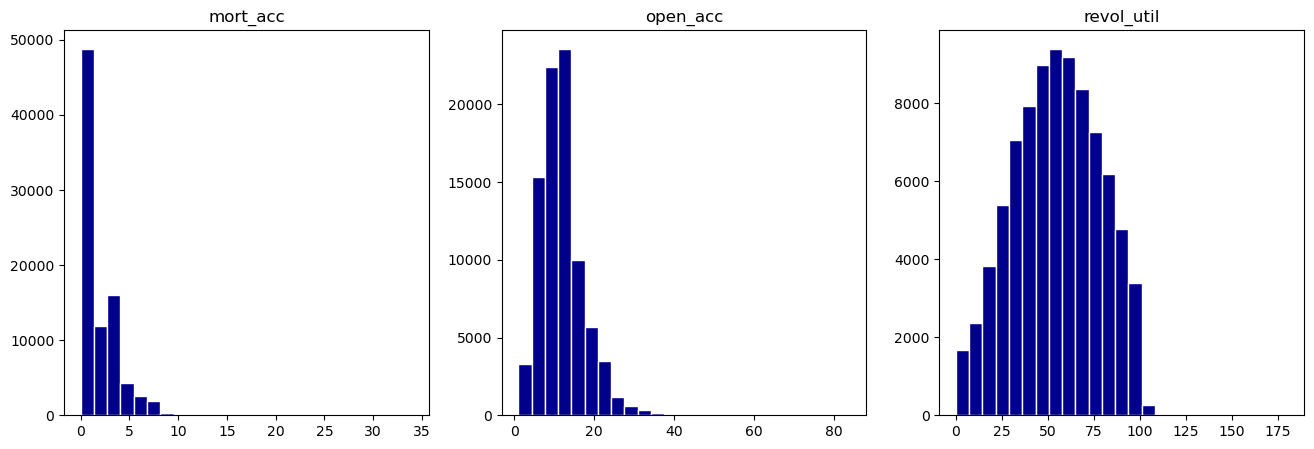

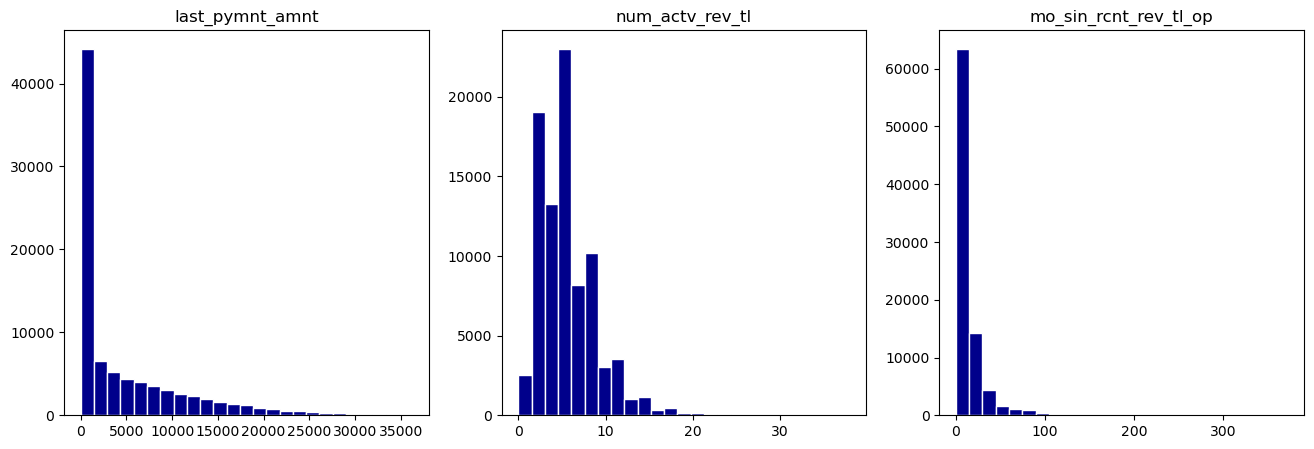

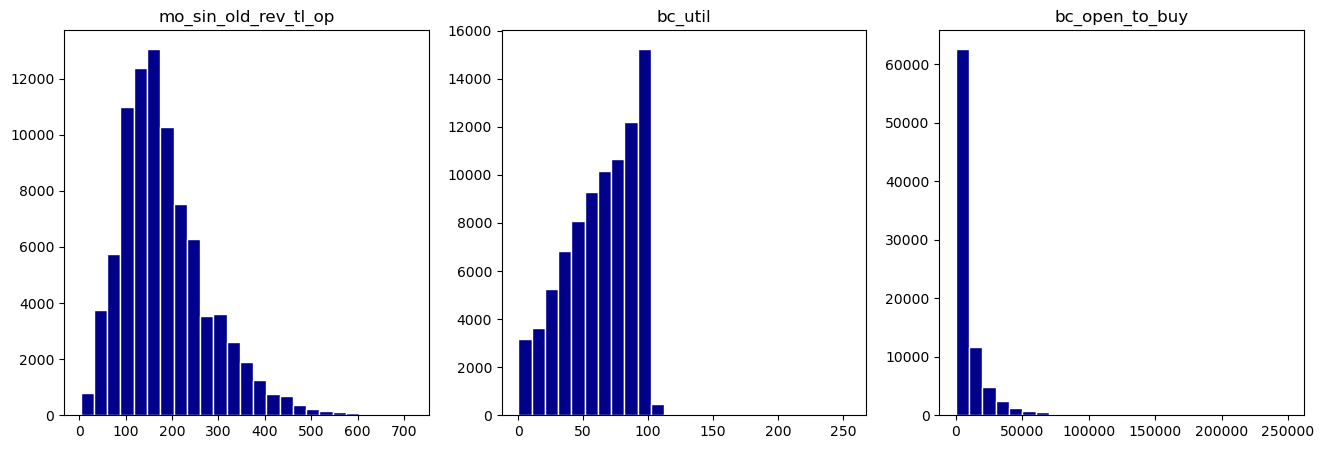

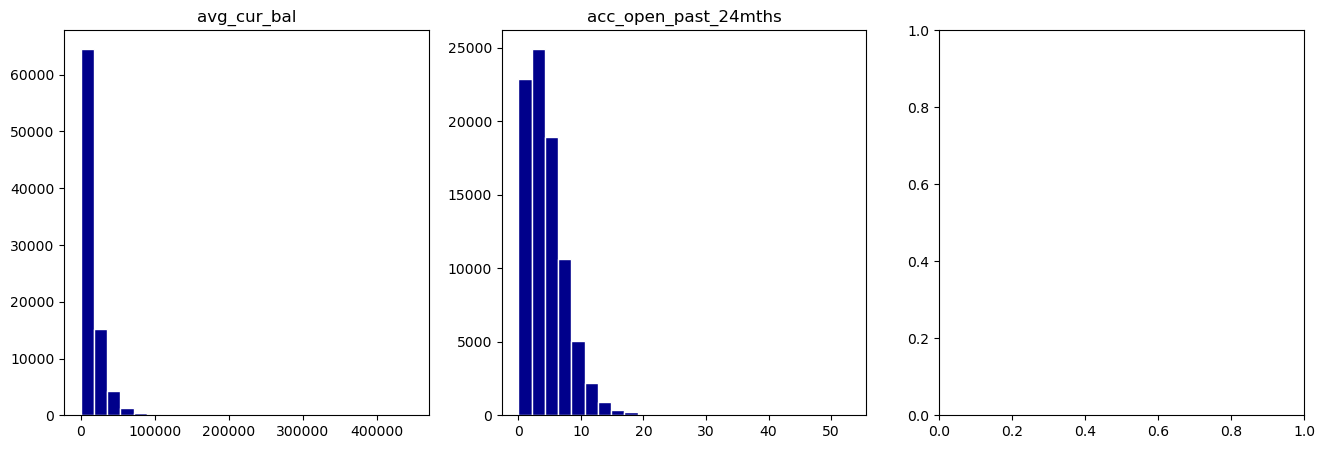

In [77]:
for i in np.arange(0,len(numerical_columns),3):

    fig, ax = plt.subplots(1, 3, figsize=(16,5), sharey=False)
    
    ax[0].hist(dataset[numerical_columns[i]], color = 'darkblue', edgecolor = 'white', bins = 25)
    ax[1].hist(dataset[numerical_columns[i+1]], color = 'darkblue', edgecolor = 'white', bins = 25)
    if i+2 < len(numerical_columns):
        ax[2].hist(dataset[numerical_columns[i+2]], color = 'darkblue', edgecolor = 'white', bins = 25)
        ax[2].set_title(numerical_columns[i+2])
        
    ax[0].set_title(numerical_columns[i])
    ax[1].set_title(numerical_columns[i+1])
    

Anuual inc, avg_cur_bal, mo_sin_rcnt_rev_tl_op look biased, because there are several observations with extreme values. Therefore, taking logarithm should help to stabilize them.

Several other features seem to be distributed log-normally; logarithm also 

We are taking logarithms of features below:

In [79]:
def draw_feature_and_log_hist(feature, bins_ = 25):
    """
    This function draws histogram of a feature and its logarithm
    It helps to fix numerical features
    """
    fig, ax = plt.subplots(1, 2, figsize=(16,5), sharey=False)
    
    ax[0].hist(dataset[feature], color = 'darkblue', edgecolor = 'white', bins = bins_)
    ax[1].hist(np.log1p(dataset[feature]), color = 'darkblue', edgecolor = 'white', bins = bins_)
        
    ax[0].set_title(feature)
    ax[1].set_title('log_'+feature)


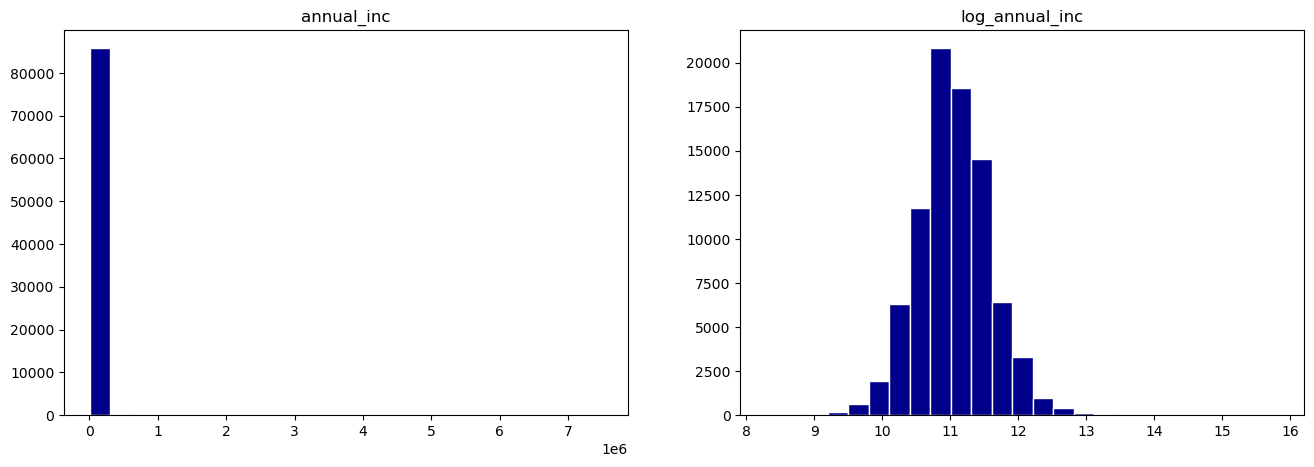

In [80]:
draw_feature_and_log_hist('annual_inc')

Looks a lot better now!!!

#### NB: Why Is it important to take logarithm from some features before standardising?

Because the extreme distrubution will be more normal. This is crucial for some models

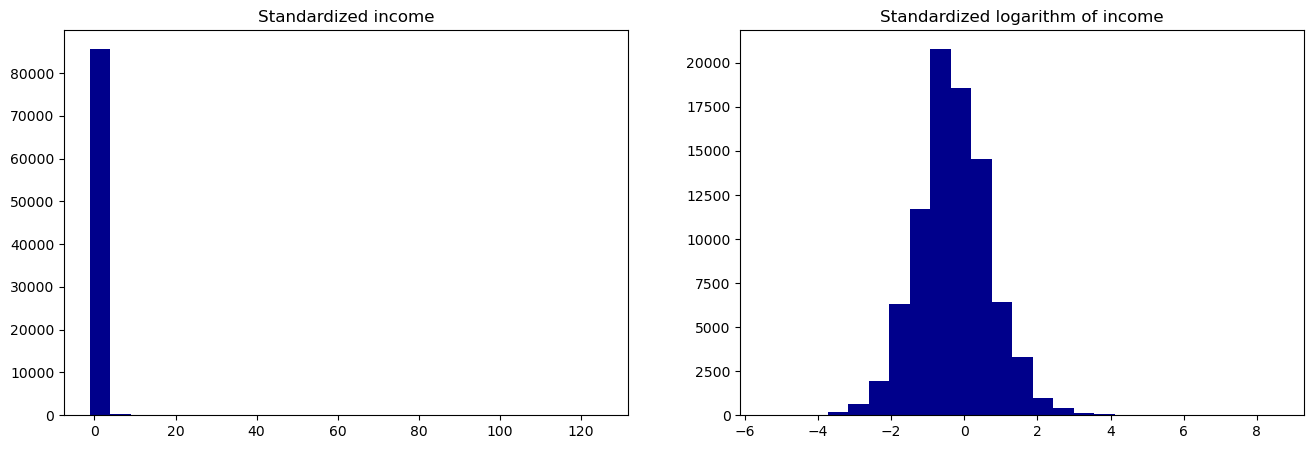

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(16,5), sharey=False)

ax[0].hist((dataset['annual_inc'] - dataset['annual_inc'].mean())/ dataset['annual_inc'].std(), bins = 25, color = 'darkblue')
ax[0].set_title('Standardized income')

ax[1].hist((np.log1p(dataset['annual_inc']) - np.log1p(dataset['annual_inc'].mean()))/ np.log1p(dataset['annual_inc']).std(), bins = 25, 
           color = 'darkblue')

ax[1].set_title('Standardized logarithm of income');

#### Going back to logarithms:

We definitely change Installment feature

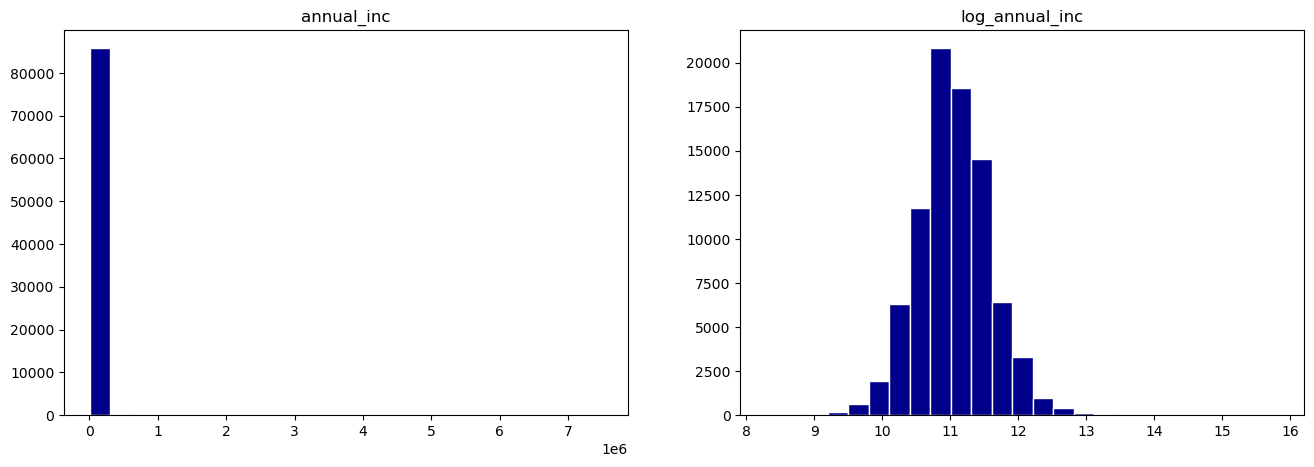

In [85]:
draw_feature_and_log_hist('annual_inc')

# add feature to dataset and remove the usual one
dataset['log_annual_inc'] = np.log1p(dataset['annual_inc'])
dataset = dataset.drop(columns = ['annual_inc'])

# add name to our numerical_feature list and remove old one
numerical_columns.remove('annual_inc')
numerical_columns.append('log_annual_inc')

Changing 'installment' also seems like a good decision, because the data becomes less skewed

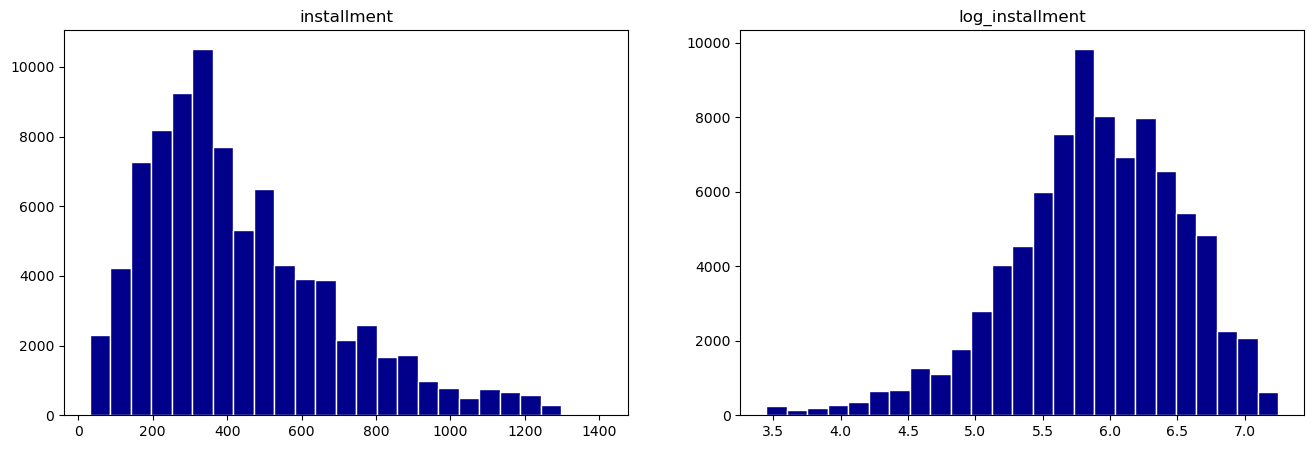

In [87]:
draw_feature_and_log_hist('installment')

# add feature to dataset and remove the usual one
dataset['log_installment'] = np.log1p(dataset['installment'])
dataset = dataset.drop(columns = ['installment'])

# add name to our numerical_feature list and remove old one
numerical_columns.remove('installment')
numerical_columns.append('log_installment')

Changing mort_acc also removes a hge portion of skeweness and makes the feature more balanced

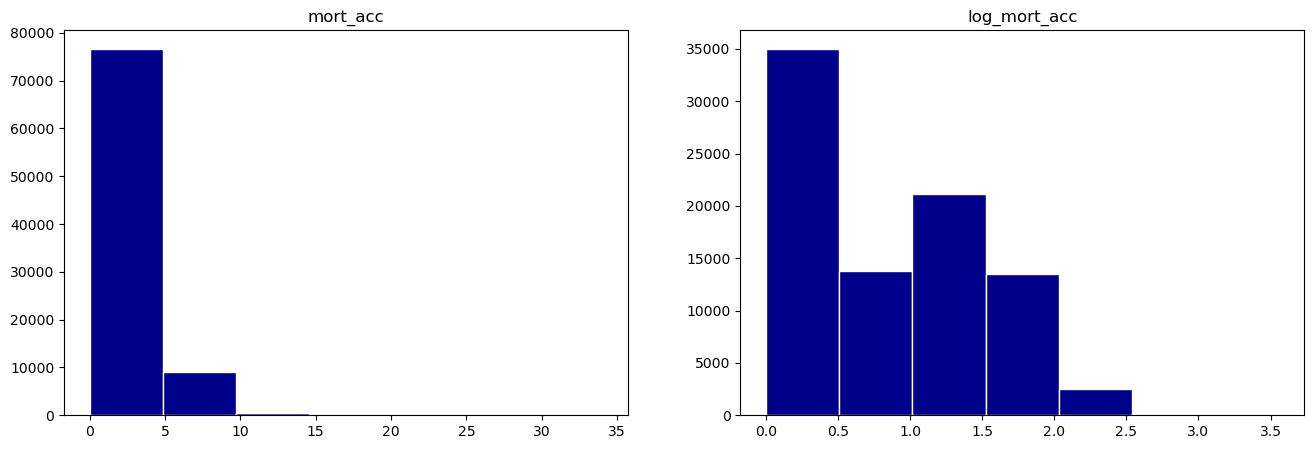

In [89]:
draw_feature_and_log_hist('mort_acc', bins_ = 7)

feature = 'mort_acc'
# add feature to dataset and remove the usual one
dataset['log_'+feature] = np.log1p(dataset[feature])
dataset = dataset.drop(columns = [feature])

# add name to our numerical_feature list and remove old one
numerical_columns.remove(feature)
numerical_columns.append('log_'+feature)

Logarithms normalises open_acc featuer as well making its extreme values more stable, therefore it is a good idea to logarithmise it

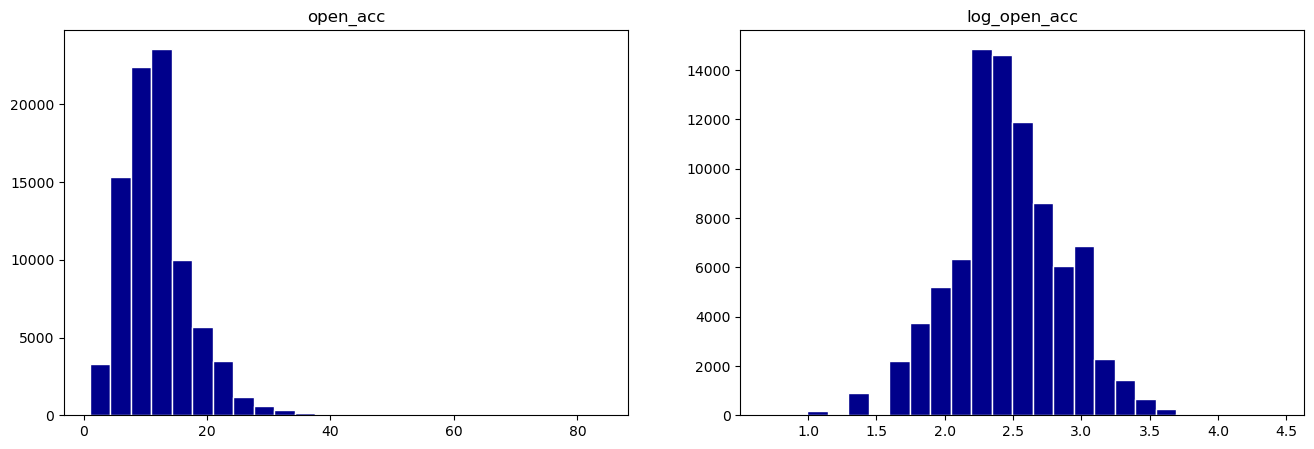

In [91]:
draw_feature_and_log_hist('open_acc')

feature = 'open_acc'
# add feature to dataset and remove the usual one
dataset['log_'+feature] = np.log1p(dataset[feature])
dataset = dataset.drop(columns = [feature])

# add name to our numerical_feature list and remove old one
numerical_columns.remove(feature)
numerical_columns.append('log_'+feature)

'revol_util' feature looks worse with logarithm, however, it has an observation around 175. It is outlier. This outlier should be removed

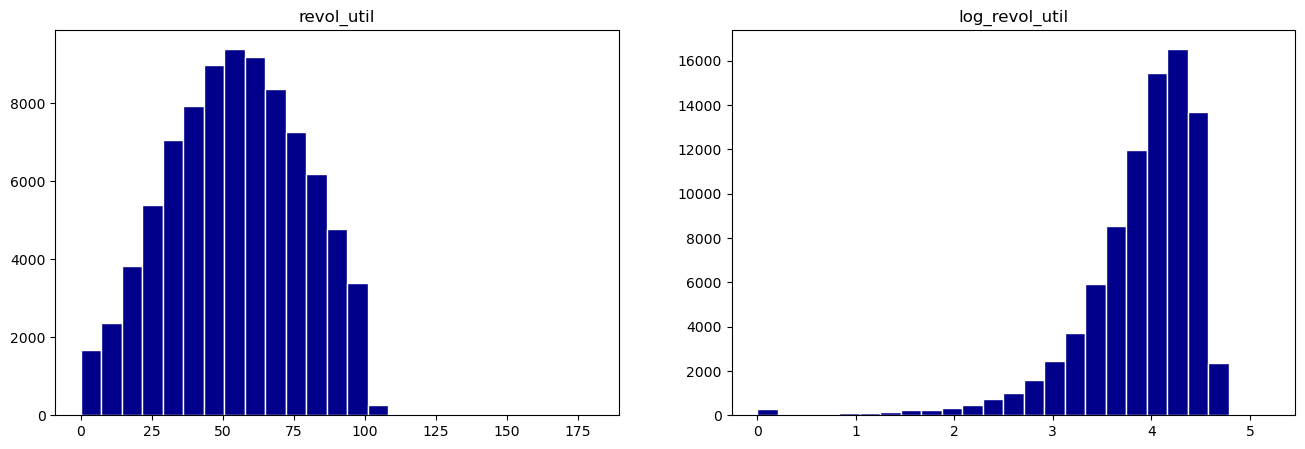

In [93]:
draw_feature_and_log_hist('revol_util')

In [94]:
# several extreme values are made equal to the lowest of them
dataset.loc[dataset['revol_util']>dataset['revol_util'].quantile(0.9995),'revol_util'] = dataset['revol_util'].quantile(0.9995)

Distribution of feature 'last_pymnt_amnt' changes drastically after taking logarithm and becomes a lot clearer. Hence, taking logarithm will enhance quality of this feature.

Note that the new distribution has 2 humps. It indicates that there are 2 types of people: those who pay their last amount equal to some X and equal to some Y. Probably these are those who do regular payments and catch up with their payments after missing them

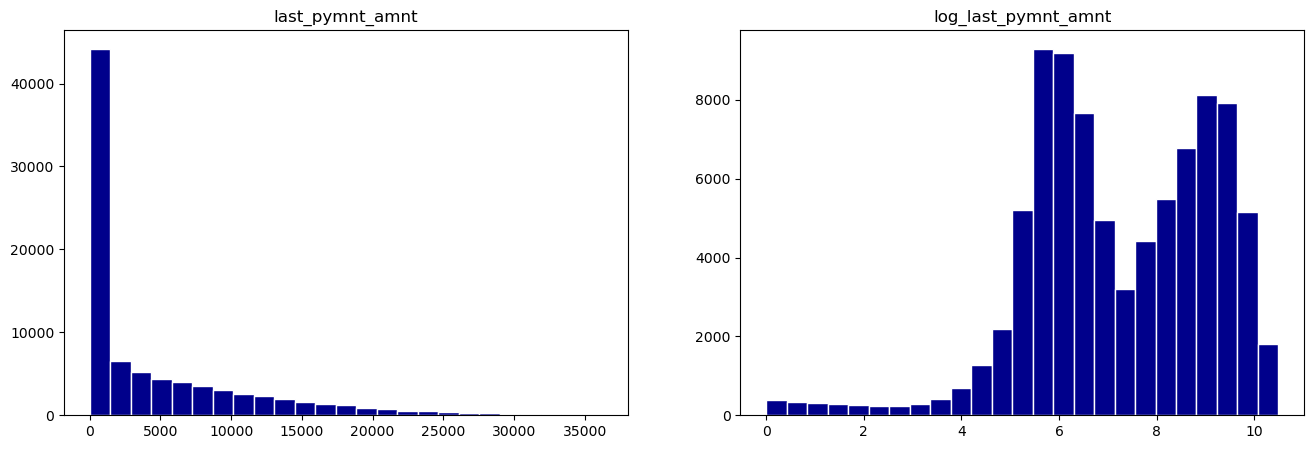

In [96]:
draw_feature_and_log_hist('last_pymnt_amnt')

feature = 'last_pymnt_amnt'
# add feature to dataset and remove the usual one
dataset['log_'+feature] = np.log1p(dataset[feature])
dataset = dataset.drop(columns = [feature])

# add name to our numerical_feature list and remove old one
numerical_columns.remove(feature)
numerical_columns.append('log_'+feature)

'num_actv_rev_tl' requires removal of extreme features

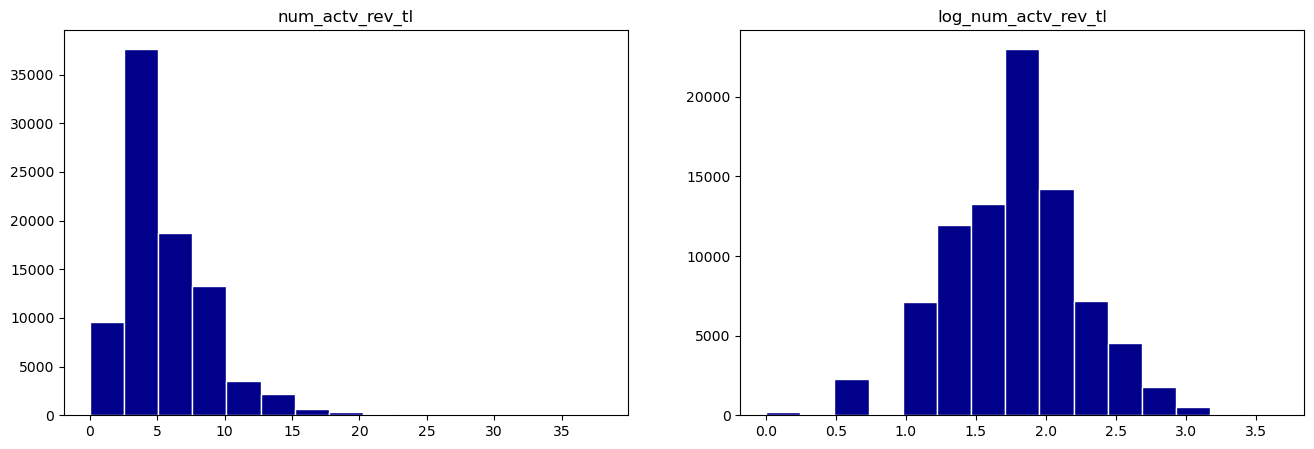

In [98]:
draw_feature_and_log_hist('num_actv_rev_tl', bins_=15)

feature = 'num_actv_rev_tl'
# add feature to dataset and remove the usual one
dataset['log_'+feature] = np.log1p(dataset[feature])
dataset = dataset.drop(columns = [feature])

# add name to our numerical_feature list and remove old one
numerical_columns.remove(feature)
numerical_columns.append('log_'+feature)

'mo_sin_rcnt_rev_tl_op' requires removal of extreme features through taking logarithm

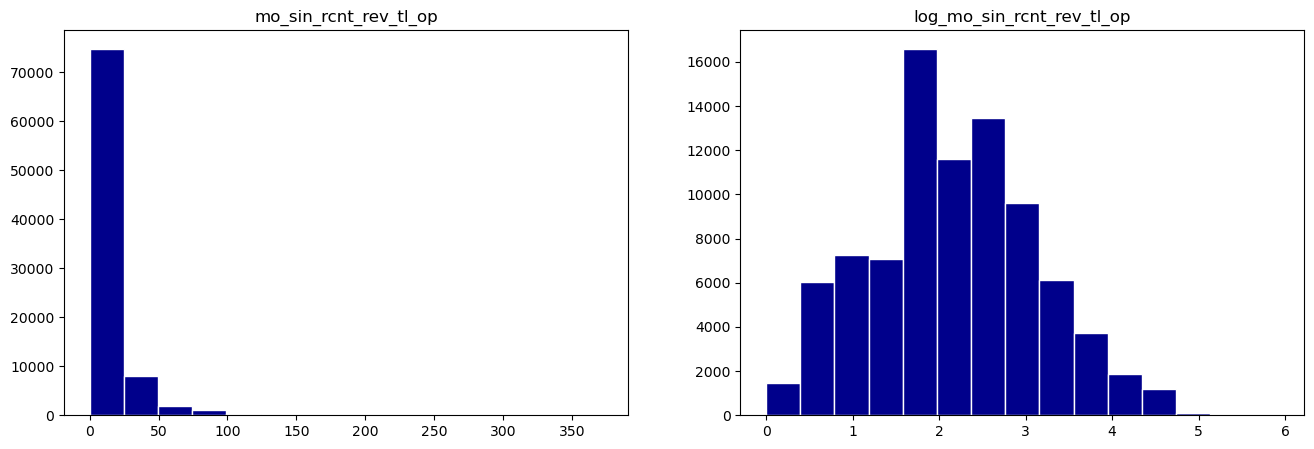

In [100]:
draw_feature_and_log_hist('mo_sin_rcnt_rev_tl_op', bins_=15)

feature = 'mo_sin_rcnt_rev_tl_op'
# add feature to dataset and remove the usual one
dataset['log_'+feature] = np.log1p(dataset[feature])
dataset = dataset.drop(columns = [feature])

# add name to our numerical_feature list and remove old one
numerical_columns.remove(feature)
numerical_columns.append('log_'+feature)

'bc_util' looks like it does not need logarithm, but has some outliers. these ouliers are removed by making their values equal to very high quantile of the data

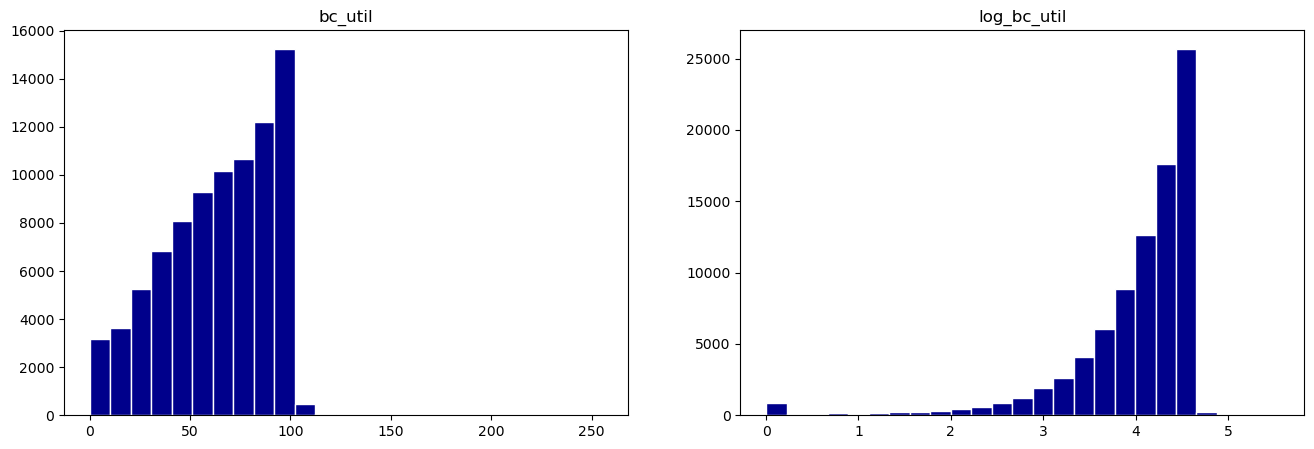

In [102]:
draw_feature_and_log_hist('bc_util')

In [103]:
# several extreme values are made equal to the lowest of them
dataset.loc[dataset['bc_util']>dataset['bc_util'].quantile(0.9995),'bc_util'] = dataset['bc_util'].quantile(0.9995)

'bc_open_to_buy' needs logarithm like man needs air

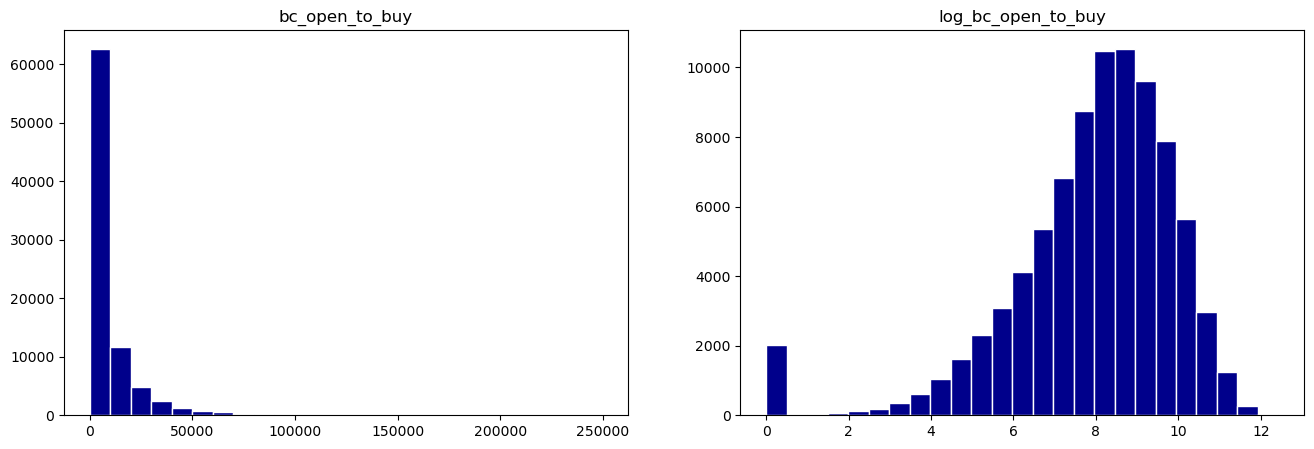

In [105]:
draw_feature_and_log_hist('bc_open_to_buy')

feature = 'bc_open_to_buy'
# add feature to dataset and remove the usual one
dataset['log_'+feature] = np.log1p(dataset[feature])
dataset = dataset.drop(columns = [feature])

# add name to our numerical_feature list and remove old one
numerical_columns.remove(feature)
numerical_columns.append('log_'+feature)

Logarithm is needed for 'avg_cur_bal' as well

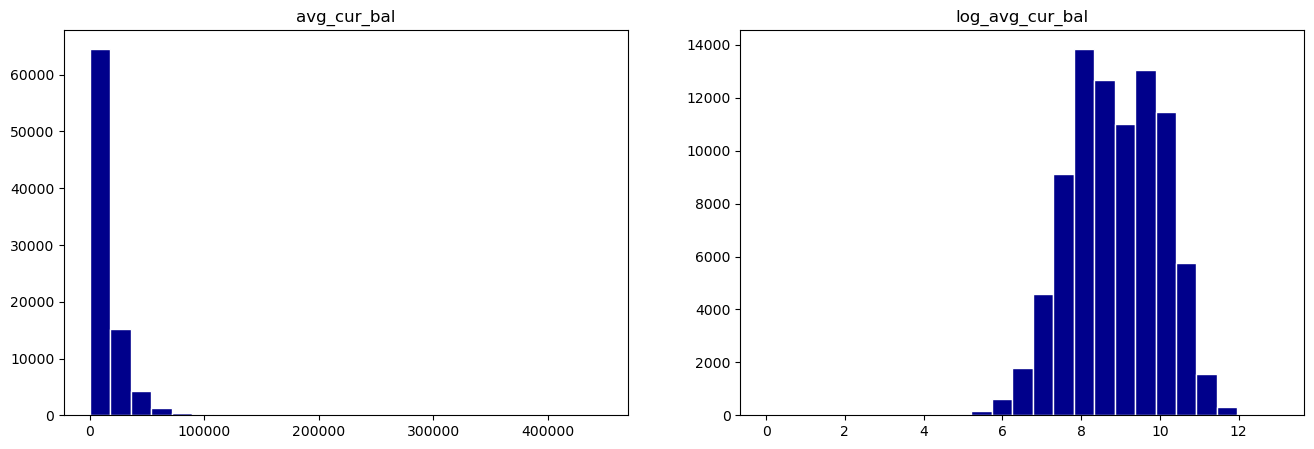

In [107]:
draw_feature_and_log_hist('avg_cur_bal')

feature = 'avg_cur_bal'
# add feature to dataset and remove the usual one
dataset['log_'+feature] = np.log1p(dataset[feature])
dataset = dataset.drop(columns = [feature])

# add name to our numerical_feature list and remove old one
numerical_columns.remove(feature)
numerical_columns.append('log_'+feature)

After taking logarithm we spot existence of outliers from 0 to 4. they have to be cleaned

In [109]:
dataset.loc[dataset['log_'+feature]<dataset['log_'+feature].quantile(0.001),'log_'+feature] = dataset['log_'+feature].quantile(0.001)

'acc_open_past_24mths' needs logarithm for decreasing number of extreme values

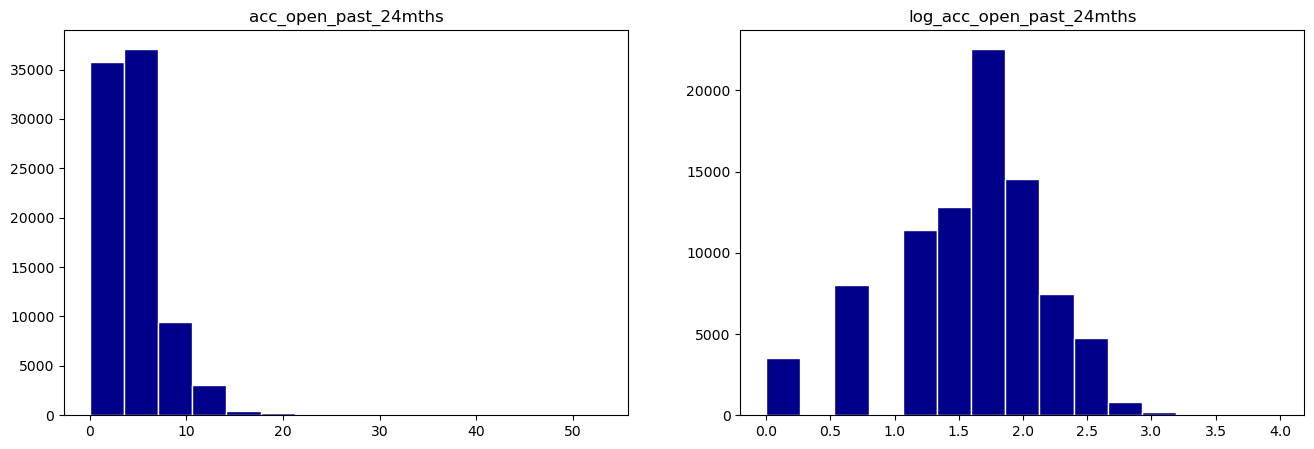

In [111]:
draw_feature_and_log_hist('acc_open_past_24mths', bins_ = 15)

feature = 'acc_open_past_24mths'
# add feature to dataset and remove the usual one
dataset['log_'+feature] = np.log1p(dataset[feature])
dataset = dataset.drop(columns = [feature])

# add name to our numerical_feature list and remove old one
numerical_columns.remove(feature)
numerical_columns.append('log_'+feature)

#### Plot histograms of all numerical features again

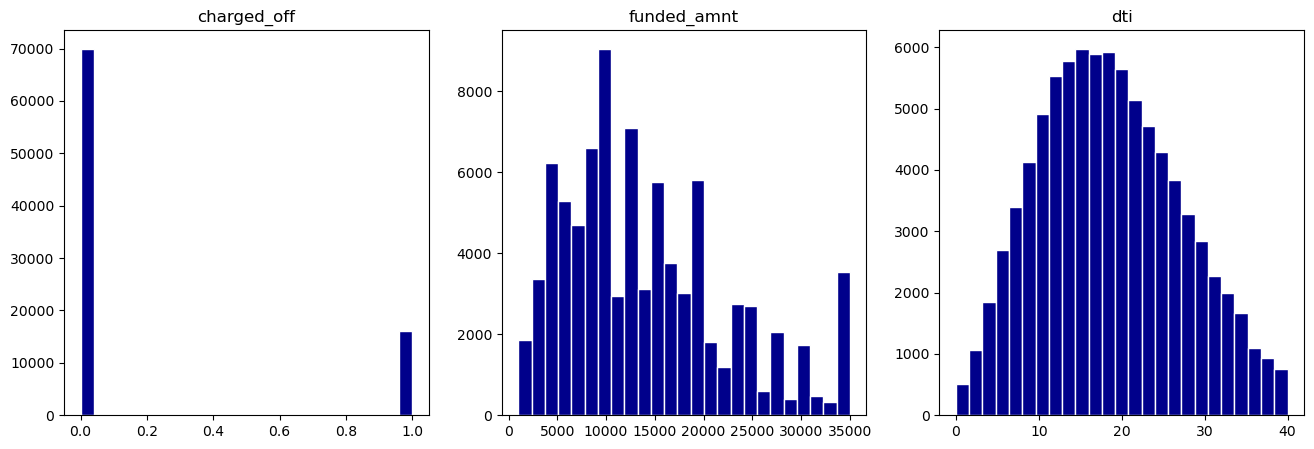

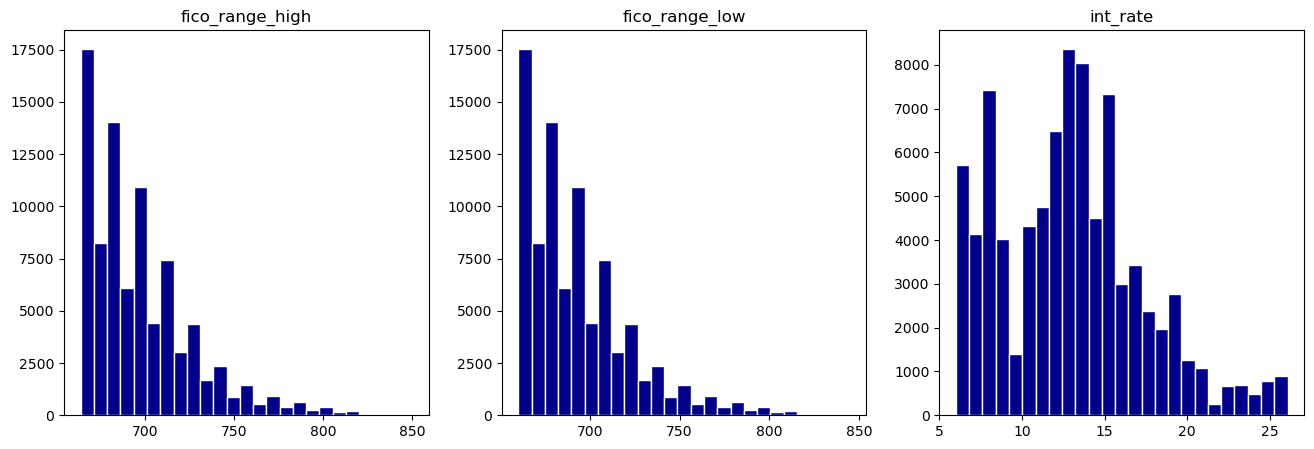

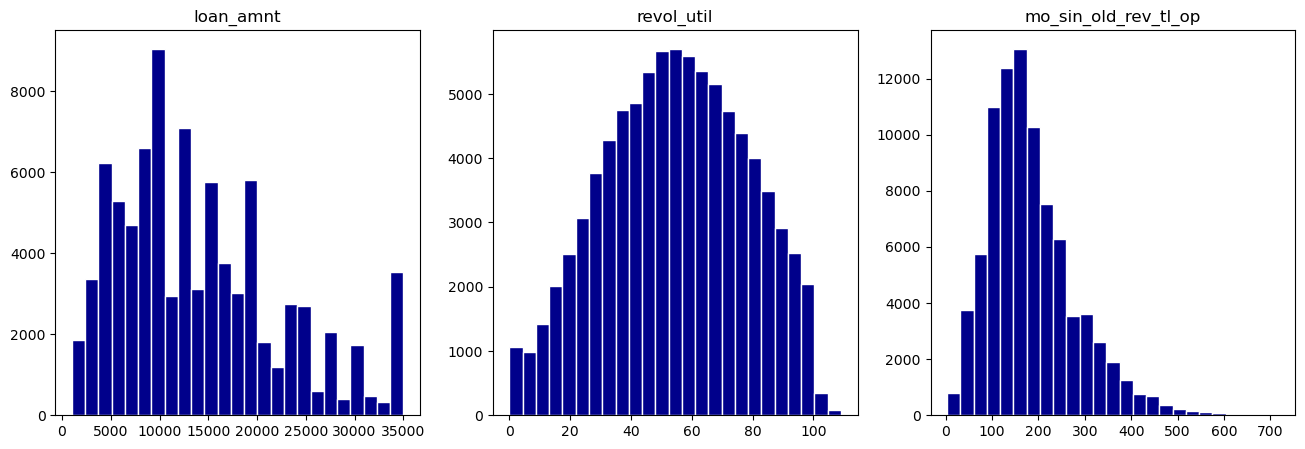

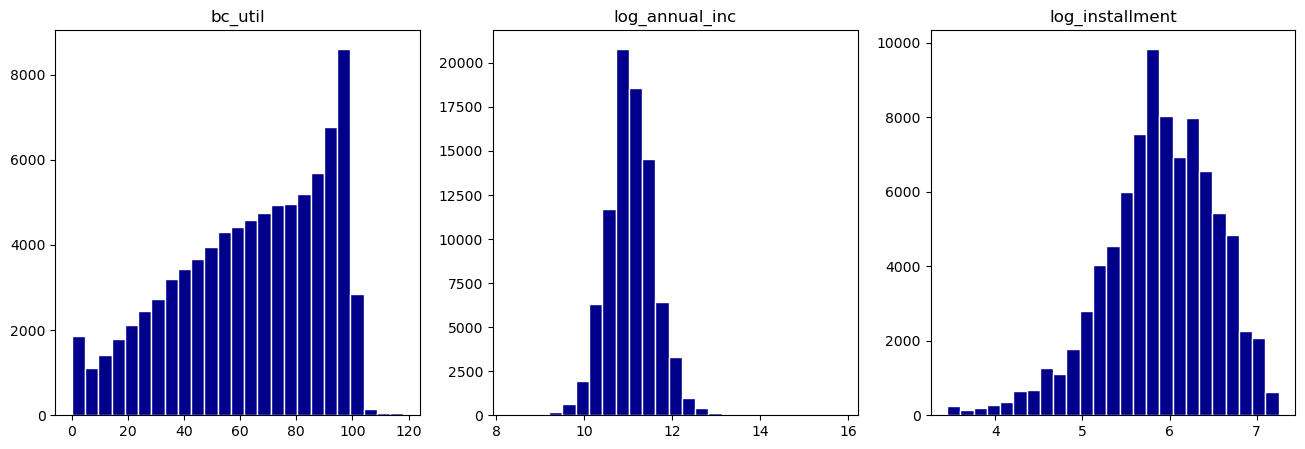

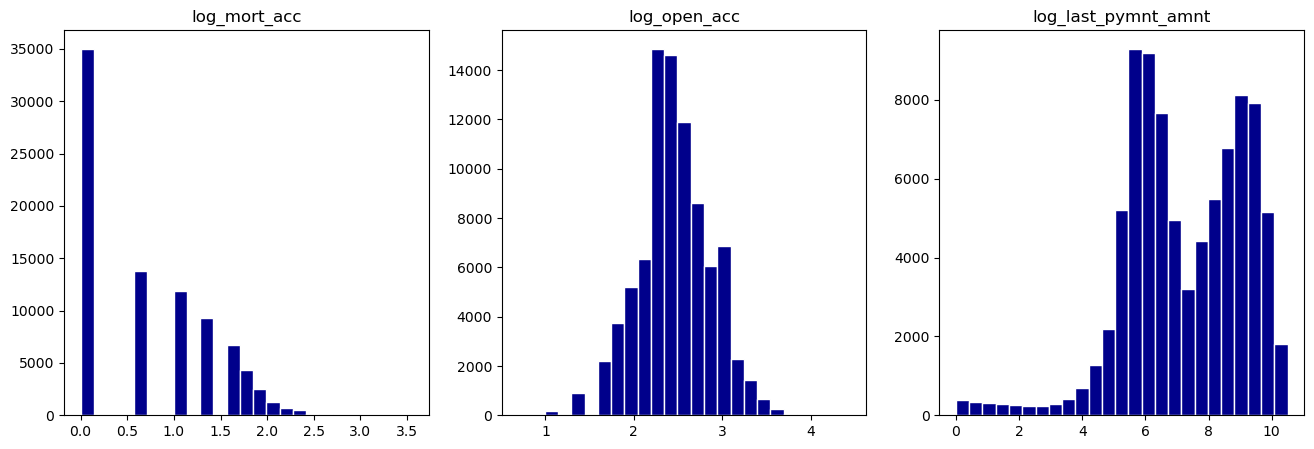

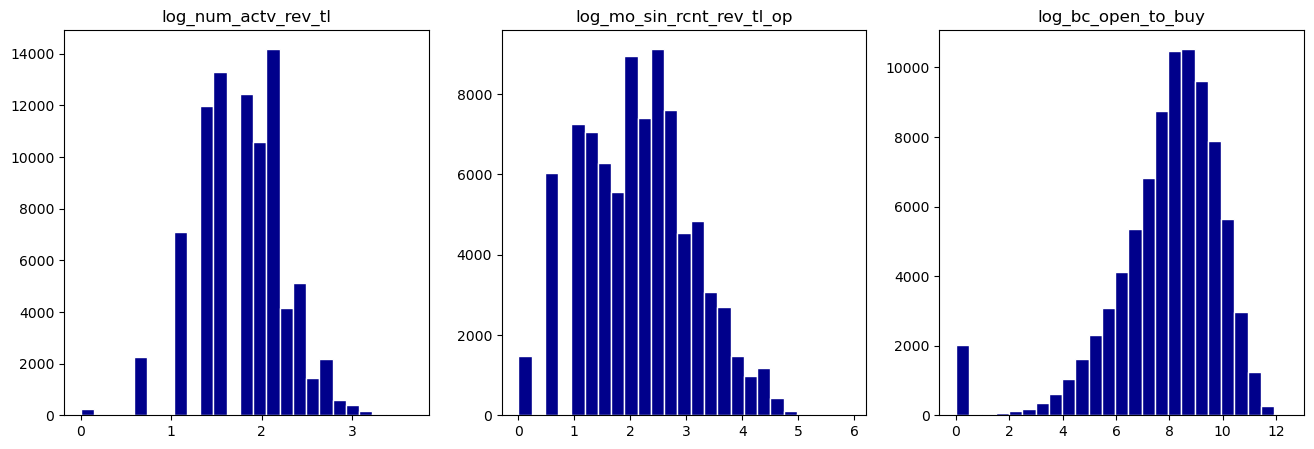

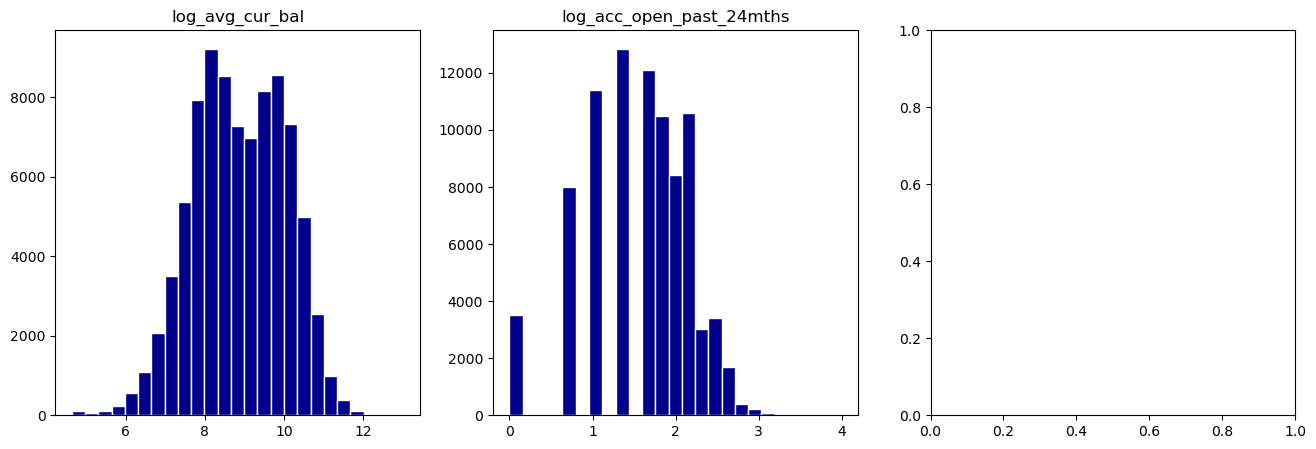

In [113]:
for i in np.arange(0,len(numerical_columns),3):

    fig, ax = plt.subplots(1, 3, figsize=(16,5), sharey=False)
    
    ax[0].hist(dataset[numerical_columns[i]], color = 'darkblue', edgecolor = 'white', bins = 25)
    ax[1].hist(dataset[numerical_columns[i+1]], color = 'darkblue', edgecolor = 'white', bins = 25)
    if i+2 < len(numerical_columns):
        ax[2].hist(dataset[numerical_columns[i+2]], color = 'darkblue', edgecolor = 'white', bins = 25)
        ax[2].set_title(numerical_columns[i+2])
        
    ax[0].set_title(numerical_columns[i])
    ax[1].set_title(numerical_columns[i+1])

#### Looks gorgeous!

In summary, we took logarithms of some continious features and trimmed several of them to avoid outliers in the data

<a id='3.1.1'></a>
### 4.1.1. Analysing the categorical features 

### List the categorical features and take a decision on what to do with them - drop them or process them. Explain your decisions.

Make barcharts of categorical featurs.

'zip_code', 'emp_title', 'earliest_cr_line' have many different features => barcharts cannot be made

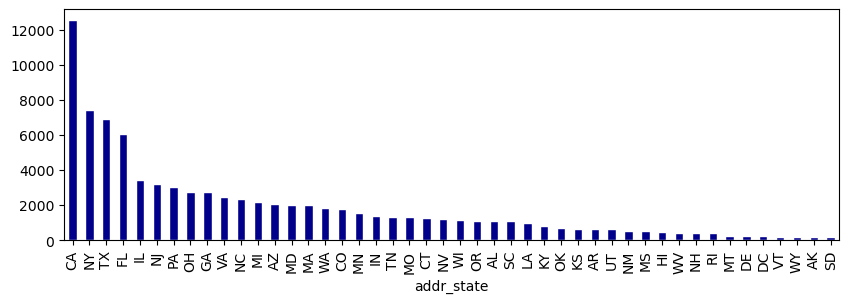

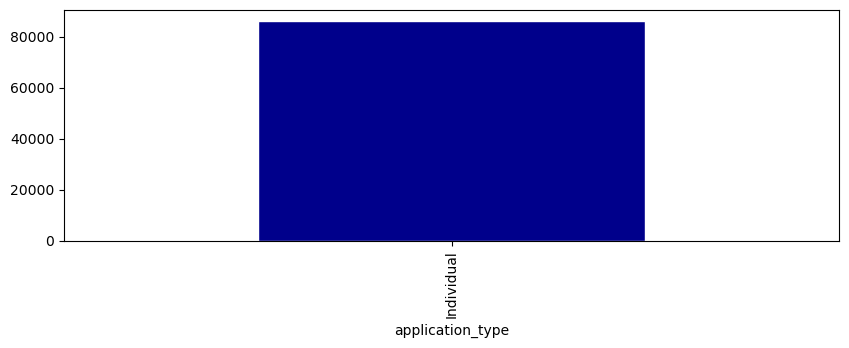

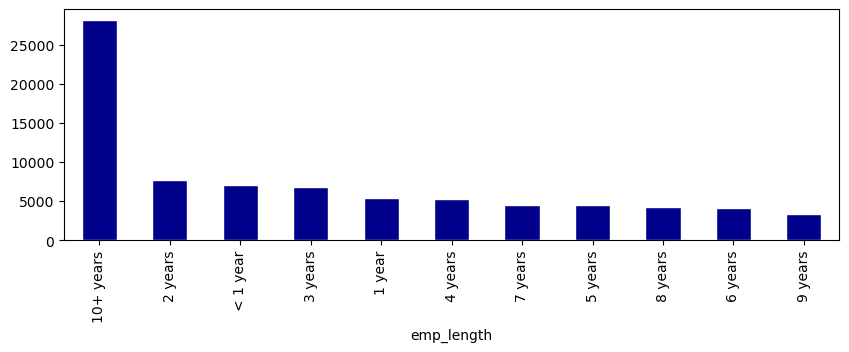

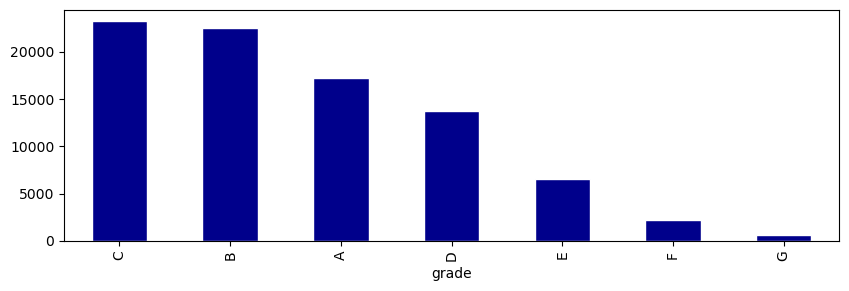

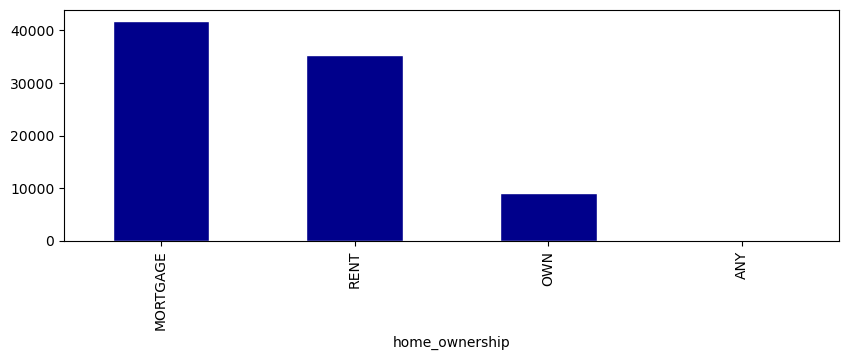

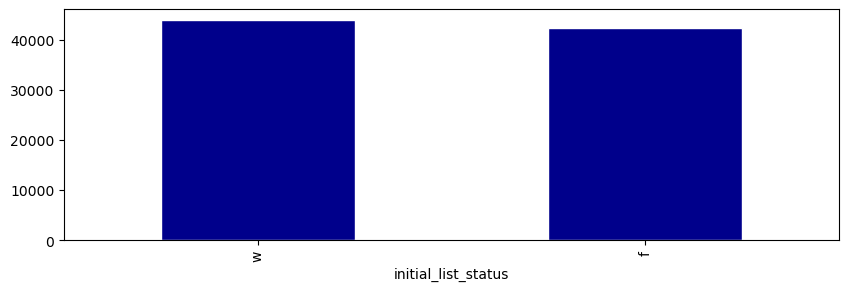

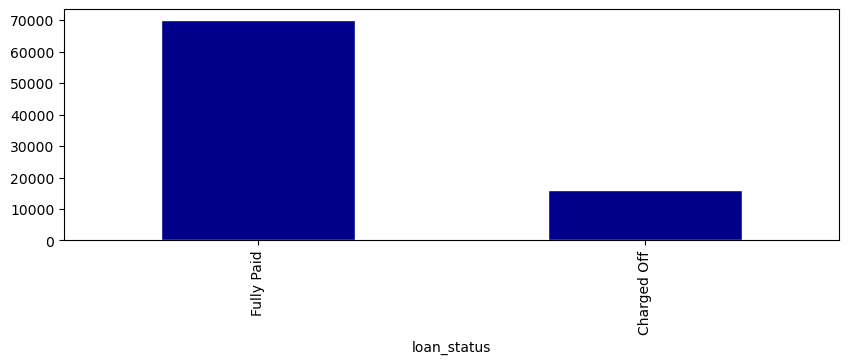

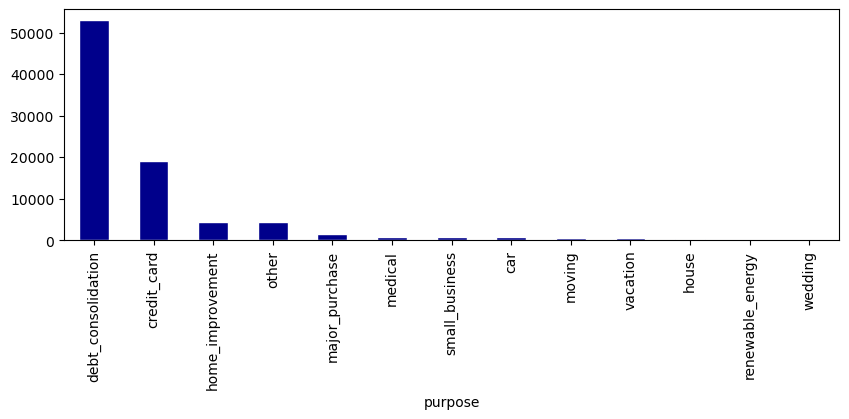

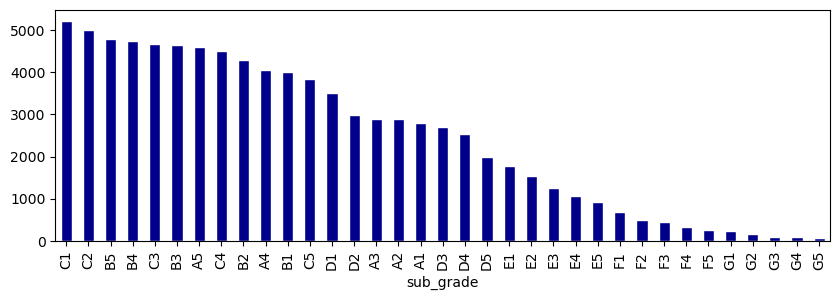

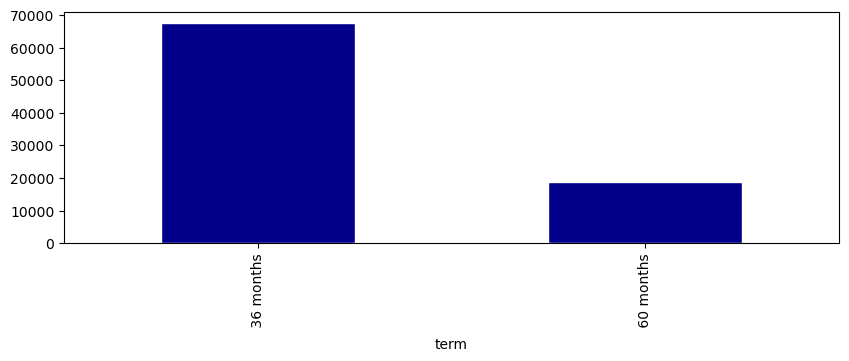

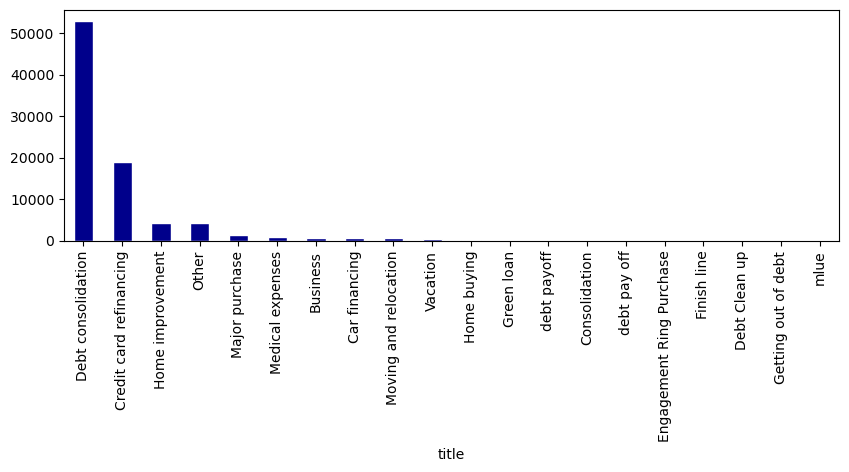

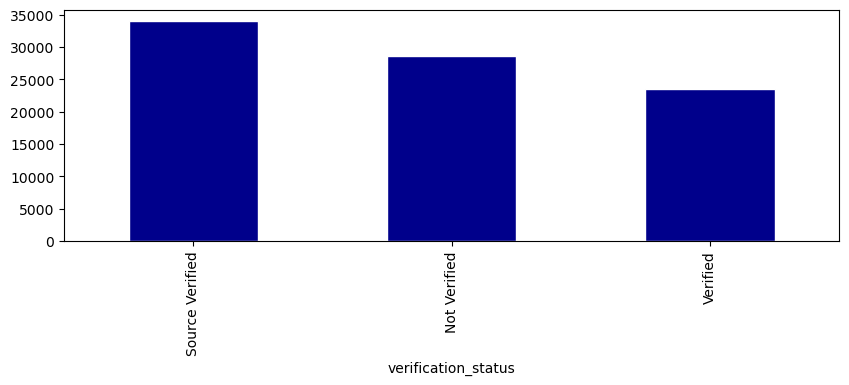

In [119]:
for column in ['addr_state', 'application_type', 'emp_length',
       'grade', 'home_ownership', 'initial_list_status',
       'loan_status', 'purpose', 'sub_grade', 'term', 'title',
       'verification_status']:
    plt.figure(figsize=(10,3))
    dataset[column].dropna().value_counts().plot(kind='bar', color = 'darkblue', edgecolor = 'white')
    plt.show();

In [120]:
categorical_columns

['addr_state',
 'application_type',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'grade',
 'home_ownership',
 'initial_list_status',
 'loan_status',
 'purpose',
 'sub_grade',
 'term',
 'title',
 'verification_status',
 'zip_code']

'addr_state' - state where individual lives. Should be correlated with their income. Can leave 10 most frequesnt states and transfer to dummies; others to one category 'other state'

'application_type' - discard, because has oly one value

'earliest_cr_line' - change to datetime type of feature and then to ordinal value. The earlier first credit line weas taken, the more data on individual there is

'emp_length' - change to ordinal value

'emp_title' - job of individual. Should correlate with their salary. There are too many professions to comprehend using one-hot-encoding, therefore, better to delete these features. However, using a clever clustering technique of professions could have used this feature. (for example, cluster professions via bag of words with addition of hierarchical clustering)

'grade' - transfer to ordinal value; looks like grade of credit

'home_ownership' - great feature; if individual has house, they will be more likely to pay credit; save and do one-hot encoding.

'initial_list_status' - one-hot encoding

'loan_status' - discard, because this is y-variable

'purpose' - purpose of taking credit. Leave top-2 most common issues ('debt_consolidation', 'credit_card') and put others to category 'other' in one-hot encoding

'sub_grade' - transfer to ordinal values

'term' - make one-hot encoding, just 2 features representing length of loan

'title' - discard, because this is nearly exact copy of 'purpose'

'verification_status' - looks like important feature that shows whether a person went through KYC procedure. can be important. do one-hot encoding

'zip_code' - discard. Alternatively can be split on latitude and longitude and replace 'addr_state'

In [122]:
column_to_drop = ['application_type', 'emp_title', 'grade', 'loan_status','zip_code']
dataset = dataset.drop(columns = column_to_drop)
for col in column_to_drop:
    categorical_columns.remove(col)

### Convert Term to a numerical feature

In [124]:
dataset['term'] = [int(i[1:3]) for i in dataset['term']]

Basically there are 2 values in column 'term': 60 and 35. We are, therefore, making instead of column 'term' a dummy variable 'term_is_60' for loans that are 60. if loan is 35, value of column = 35

In [126]:
dataset['term_is_60'] = (dataset['term']==60).astype(int)
dataset = dataset.drop(columns = ['term'])

### Decide if you want to do anything to emp_length

'emp_length' should be changed to ordinal values 

In [129]:
dataset.loc[dataset['emp_length']=='< 1 year','emp_length'] = 0
dataset.loc[dataset['emp_length']=='1 year','emp_length'] = 1
dataset.loc[dataset['emp_length']=='2 years','emp_length'] = 2
dataset.loc[dataset['emp_length']=='3 years','emp_length'] = 3
dataset.loc[dataset['emp_length']=='4 years','emp_length'] = 4
dataset.loc[dataset['emp_length']=='5 years','emp_length'] = 5
dataset.loc[dataset['emp_length']=='6 years','emp_length'] = 6
dataset.loc[dataset['emp_length']=='7 years','emp_length'] = 7
dataset.loc[dataset['emp_length']=='8 years','emp_length'] = 8
dataset.loc[dataset['emp_length']=='9 years','emp_length'] = 9
dataset.loc[dataset['emp_length']=='10+ years','emp_length'] = 10

### Is sub_grade worth keeping ?

Yes, it is worth keeping, It is more detailed representation of 'grade' feature. Hence, 'grade' is dropped and 'sub_grade' is transferred to ordinal type of feature

In [132]:
ordinal_mapping = {
    'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5,
    'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10,
    'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15,
    'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20,
    'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25,
    'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30,
    'G1': 31, 'G2': 32, 'G3': 33, 'G4': 34, 'G5': 35
}

dataset['sub_grade_ordinal'] = dataset['sub_grade'].map(ordinal_mapping)

In [133]:
dataset = dataset.drop(columns = ['sub_grade'])

<a id='3.2'></a>
## 4.2. Encoding Categorical Data

### Decide how to handle the categorical data in columns ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type']

### You may wish to use a LabelEncoder


grade is dropped already; sub_grade transformed.

for other features we are following with the developed framework

'addr_state' - state where individual lives. Should be correlated with their income. Can leave 10 most frequesnt states and transfer to dummies; others to one category 'other state'

In [138]:
# Get the 10 most common states
state_counts = Counter(dataset['addr_state'])
most_common_states = dict(state_counts.most_common(10))

# Create a mapping for states
def map_states(state):
    return state if state in most_common_states else 'other state'

# Apply the mapping to create a new column
dataset['addr_state_mapped'] = dataset['addr_state'].apply(map_states)

In [139]:
# drop old column
dataset = dataset.drop(columns = ['addr_state'])

In [140]:
# add dummies for 11 states
dataset = pd.concat([dataset,pd.get_dummies(dataset['addr_state_mapped'], prefix='addr_state').astype(int)],axis = 1)

In [141]:
# drop column addr_state_mapped
dataset = dataset.drop(columns = ['addr_state_mapped'])

'earliest_cr_line' - change to datetime type of feature and then to ordinal value. The earlier first credit line weas taken, the more data on individual there is

In [143]:
# make dates
dataset['earliest_cr_line'] = pd.to_datetime(dataset['earliest_cr_line'], format='%b-%Y')

In [144]:
# Convert the datetime to ordinal values
dataset['earliest_cr_line'] = dataset['earliest_cr_line'].apply(lambda x: x.toordinal())-700000

'home_ownership' - great feature; if individual has house, they will be more likely to pay credit; save and do one-hot encoding.

In [146]:
# make 1 ANY observation into the most popular one 'mortgage'
dataset['home_ownership'] = dataset['home_ownership'].replace({'ANY': 'MORTGAGE'})

#one-hot encoding
home_ownership_dummies = pd.get_dummies(dataset['home_ownership'], prefix='ownership').astype(int)

#concatenate the one-hot encoded columns to the original dataset
dataset = pd.concat([dataset, home_ownership_dummies], axis=1)

#drop the original 'home_ownership' column
dataset = dataset.drop(columns=['home_ownership'])

'initial_list_status' - one-hot encoding

In [148]:
dataset.loc[dataset['initial_list_status']=='f','initial_list_status'] = 0
dataset.loc[dataset['initial_list_status']=='w','initial_list_status'] = 1

'purpose' - purpose of taking credit. Leave top-2 most common issues ('debt_consolidation', 'credit_card') and put others to category 'other', then do  one-hot encoding

In [150]:
top_two_categories = ['debt_consolidation', 'credit_card']

# replace other categories with 'other'
dataset['purpose_mapped'] = dataset['purpose'].apply(
    lambda x: x if x in top_two_categories else 'other'
)

# one-hot encoding
purpose_dummies = pd.get_dummies(dataset['purpose_mapped'], prefix='purpose').astype(int)

# concatenate the one-hot encoded columns to the original dataset
dataset = pd.concat([dataset, purpose_dummies], axis=1)

# drop the original 'purpose' and 'purpose_mapped' columns
dataset = dataset.drop(columns=['purpose', 'purpose_mapped'])

'title' - discard, because this is nearly exact copy of 'purpose'

In [152]:
dataset = dataset.drop(columns = ['title'])

'verification_status' - looks like important feature that shows whether a person went through KYC procedure. can be important. do one-hot encoding

In [154]:
verification_status_dummies = pd.get_dummies(dataset['verification_status'], prefix='verification').astype(int)
dataset = pd.concat([dataset, verification_status_dummies], axis=1)
dataset = dataset.drop(columns=['verification_status'])

#### Finally, plot the histograms again,. Now of all features

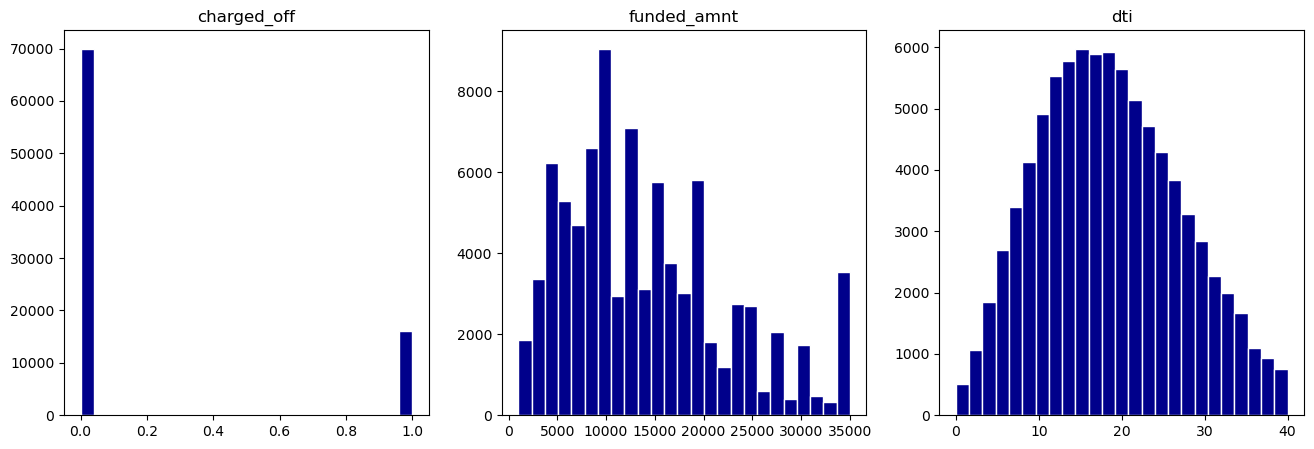

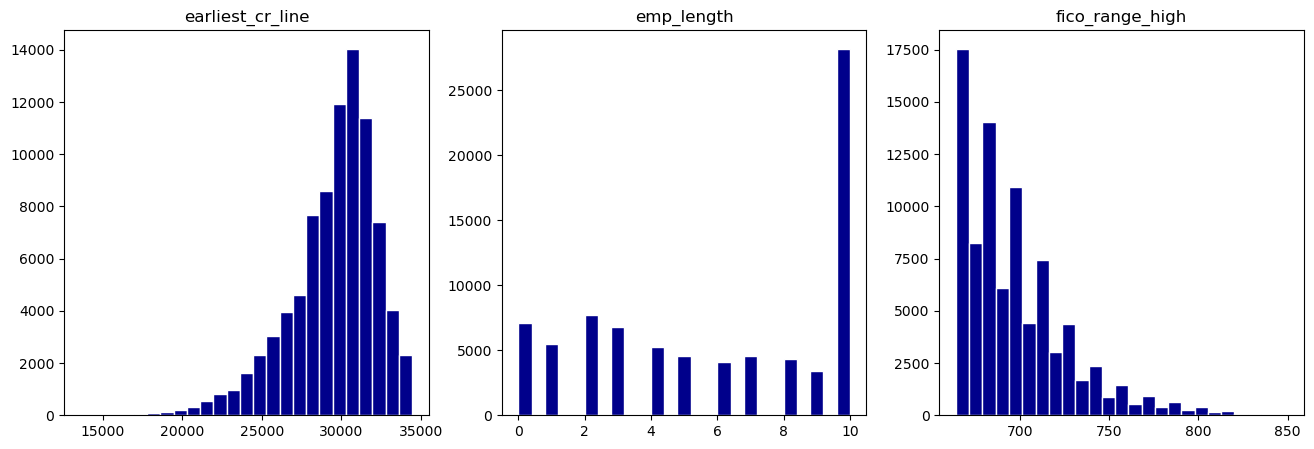

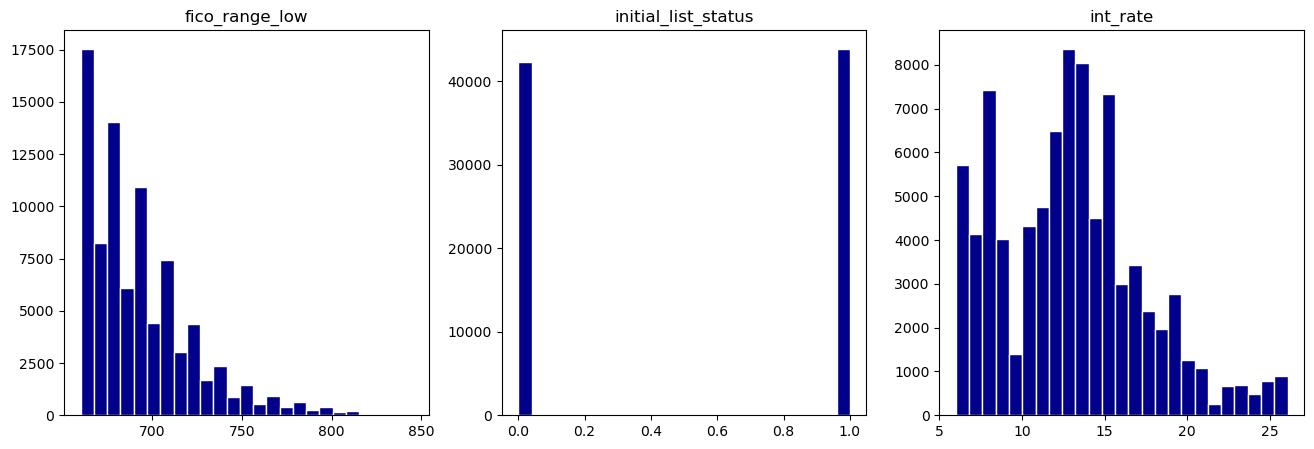

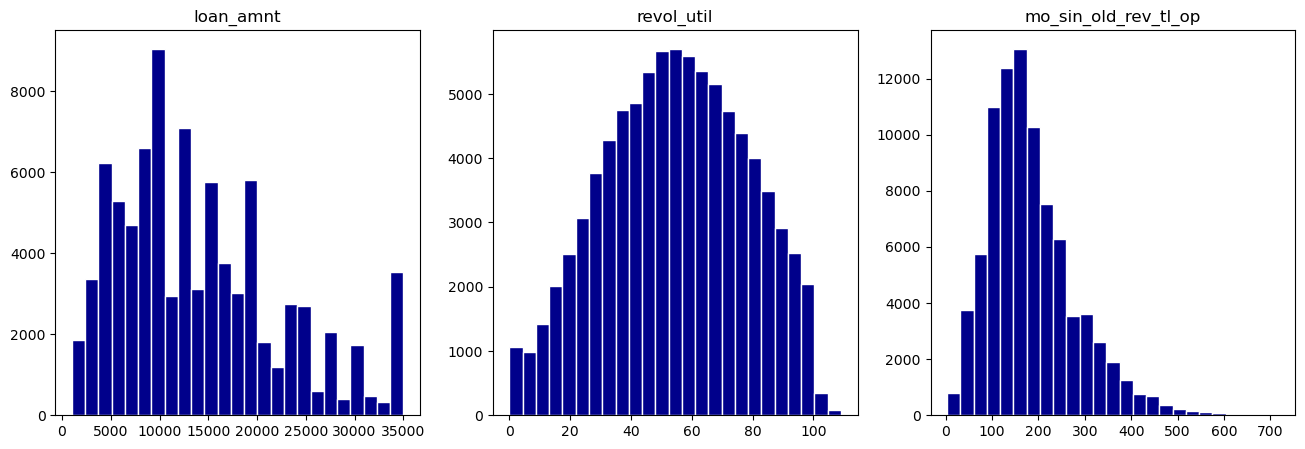

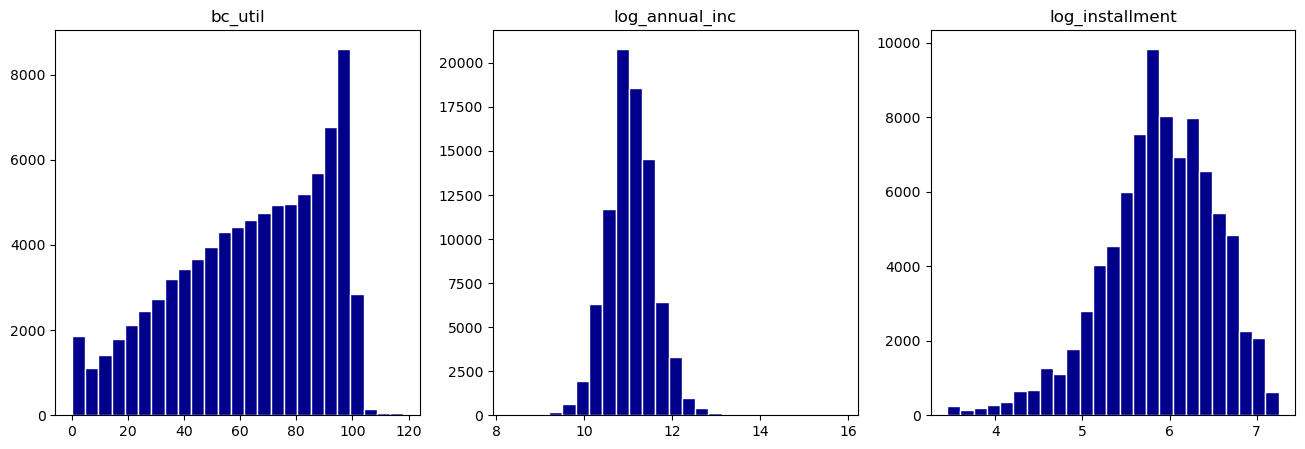

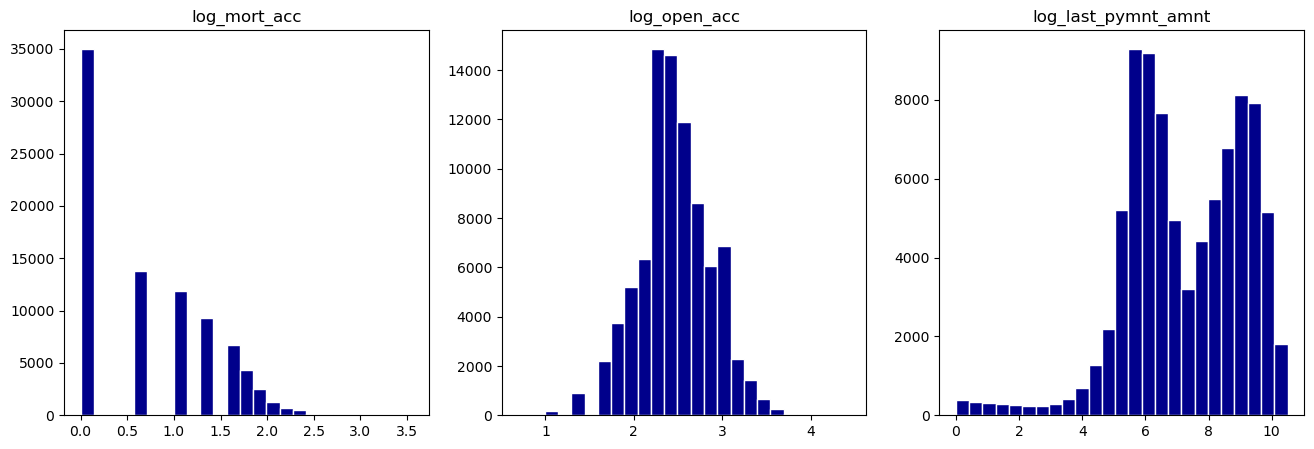

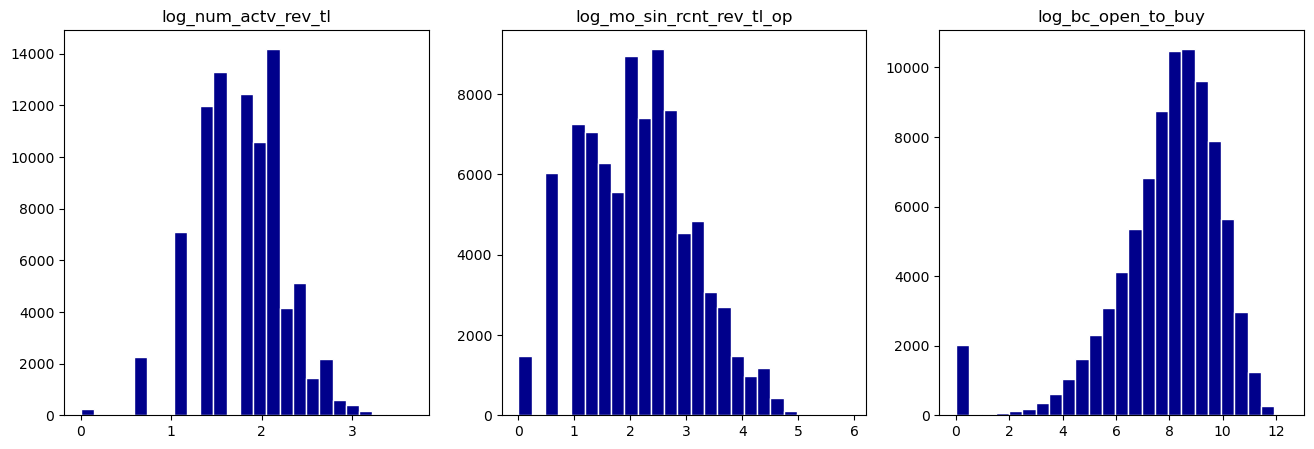

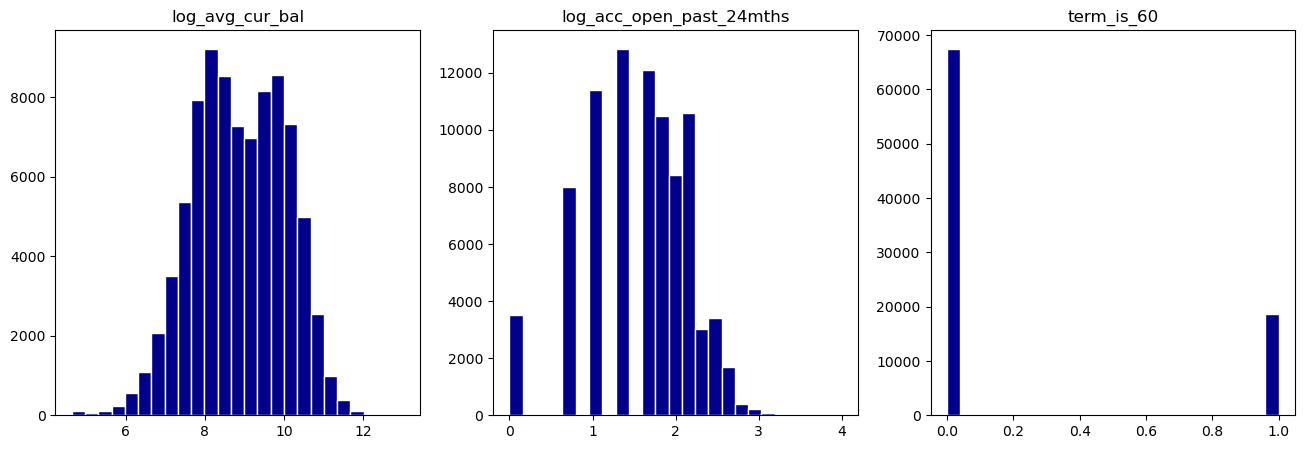

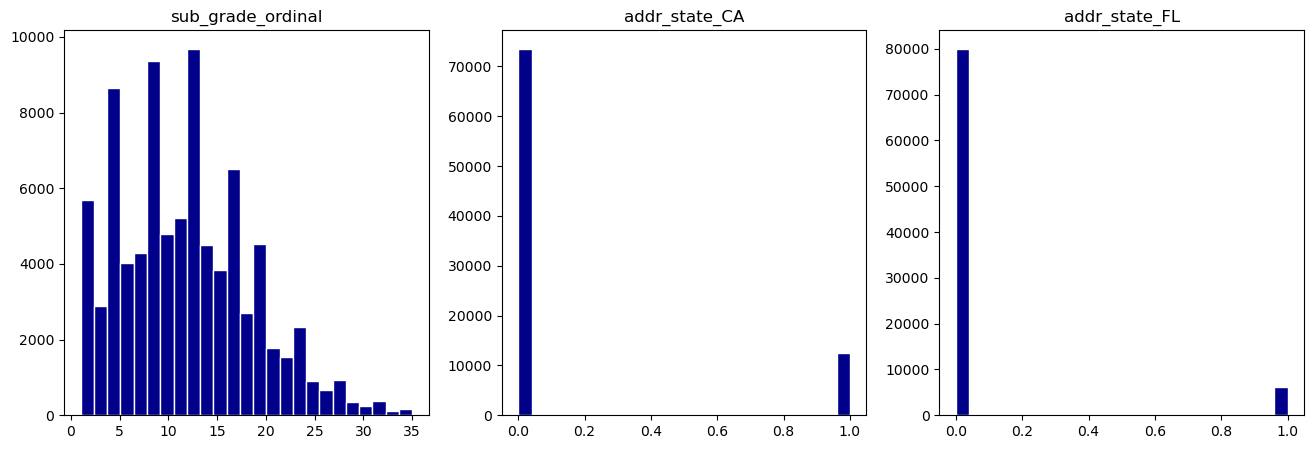

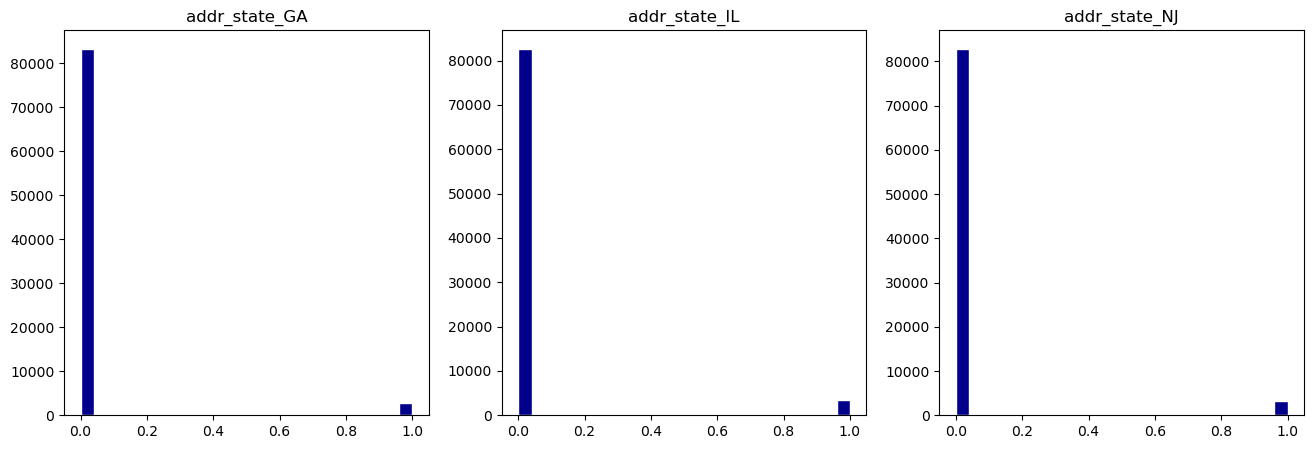

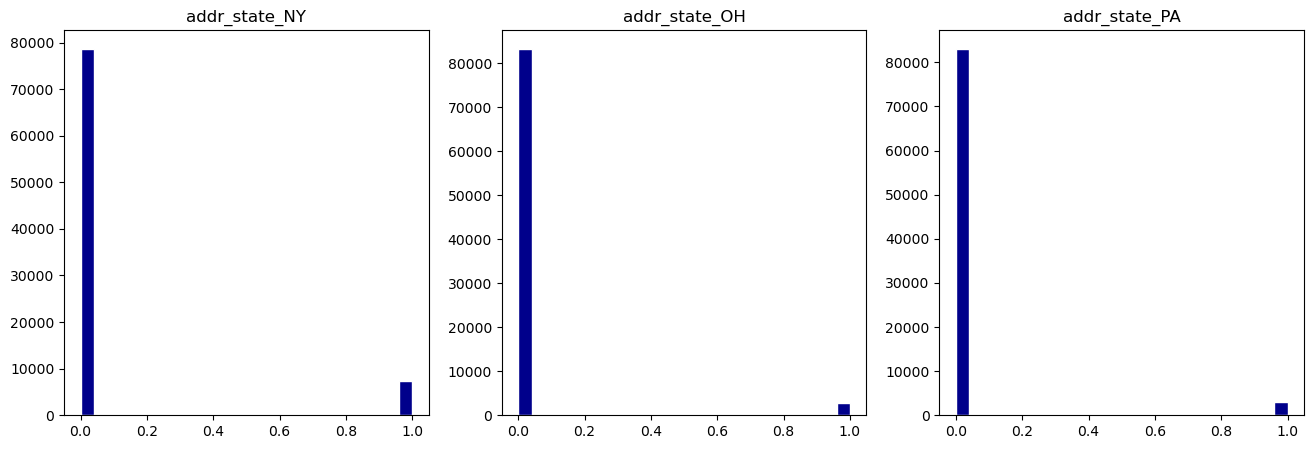

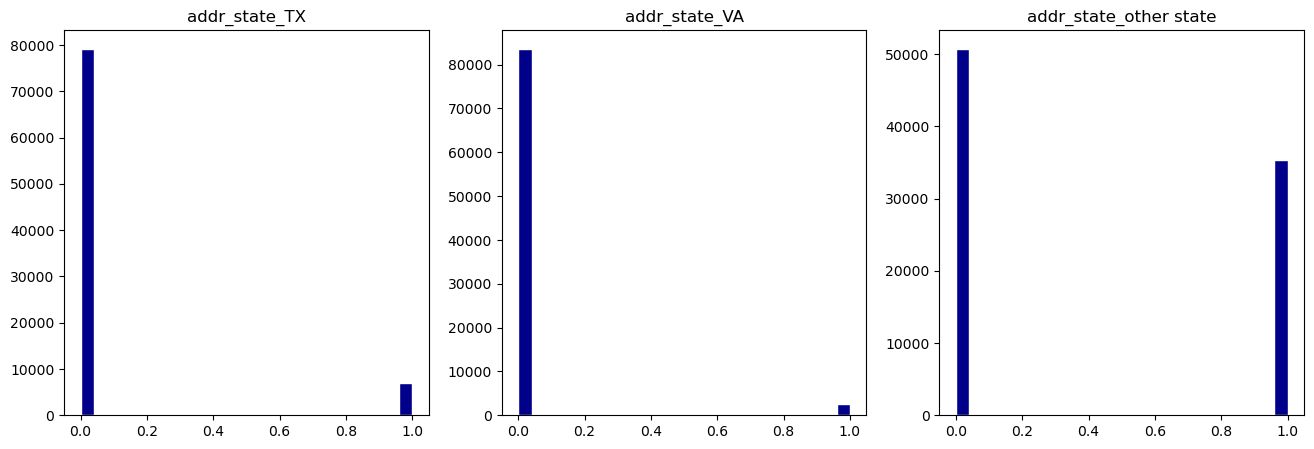

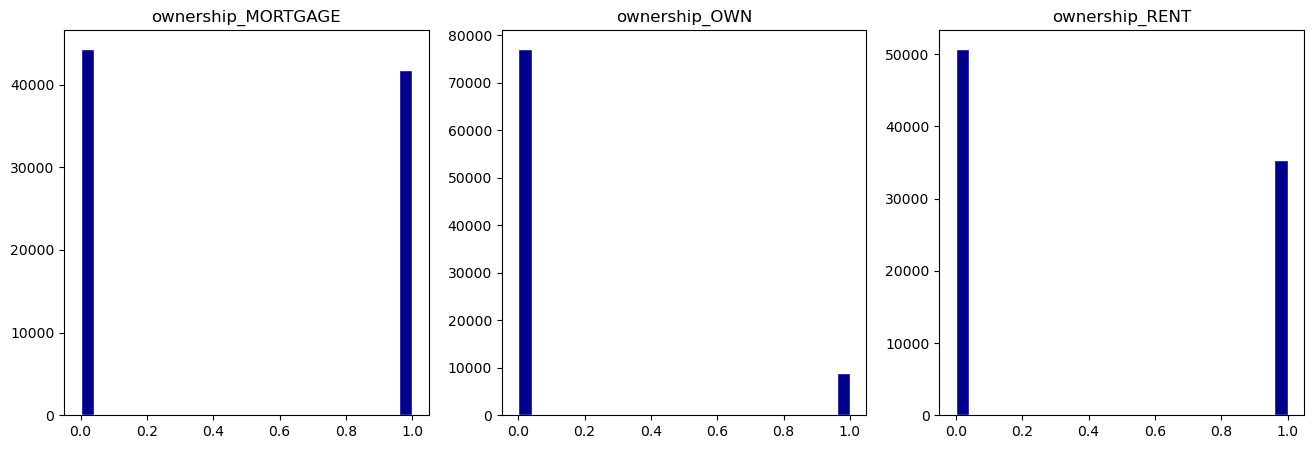

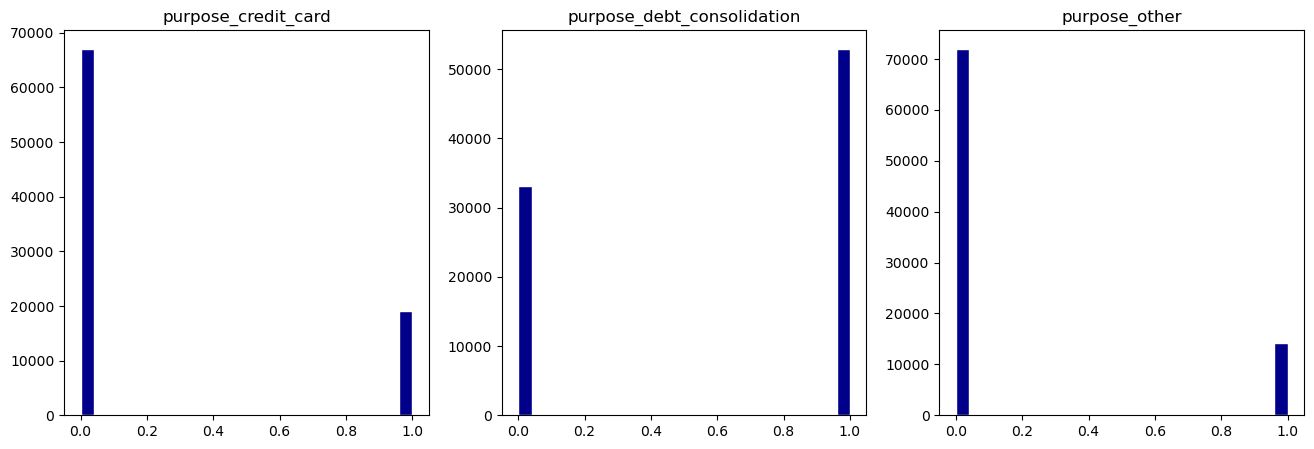

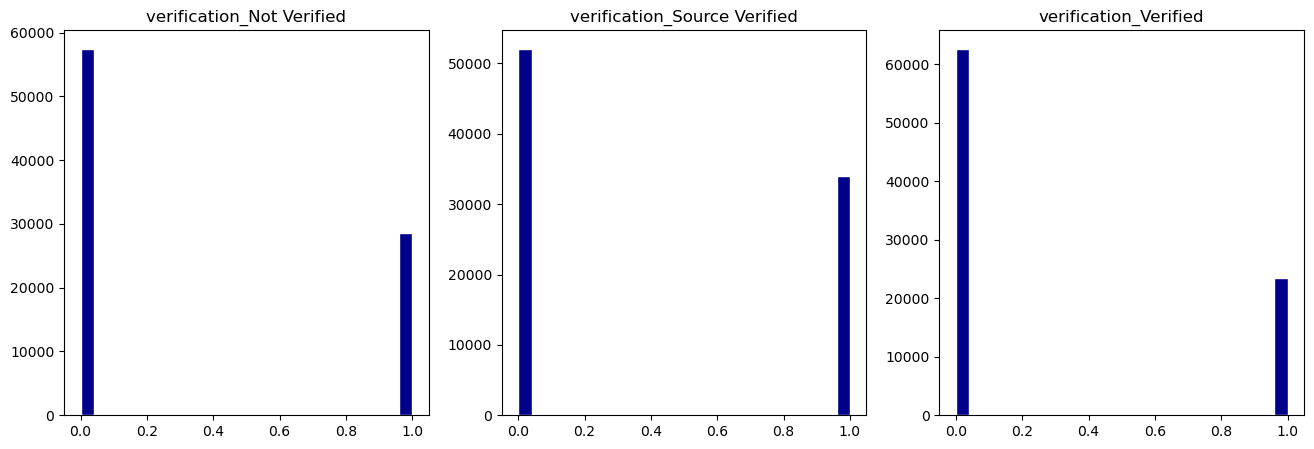

In [156]:
numerical_columns = dataset.columns
for i in np.arange(0,len(numerical_columns),3):

    fig, ax = plt.subplots(1, 3, figsize=(16,5), sharey=False)
    
    ax[0].hist(dataset[numerical_columns[i]], color = 'darkblue', edgecolor = 'white', bins = 25)
    ax[1].hist(dataset[numerical_columns[i+1]], color = 'darkblue', edgecolor = 'white', bins = 25)
    if i+2 < len(numerical_columns):
        ax[2].hist(dataset[numerical_columns[i+2]], color = 'darkblue', edgecolor = 'white', bins = 25)
        ax[2].set_title(numerical_columns[i+2])
        
    ax[0].set_title(numerical_columns[i])
    ax[1].set_title(numerical_columns[i+1])

draw correlogram

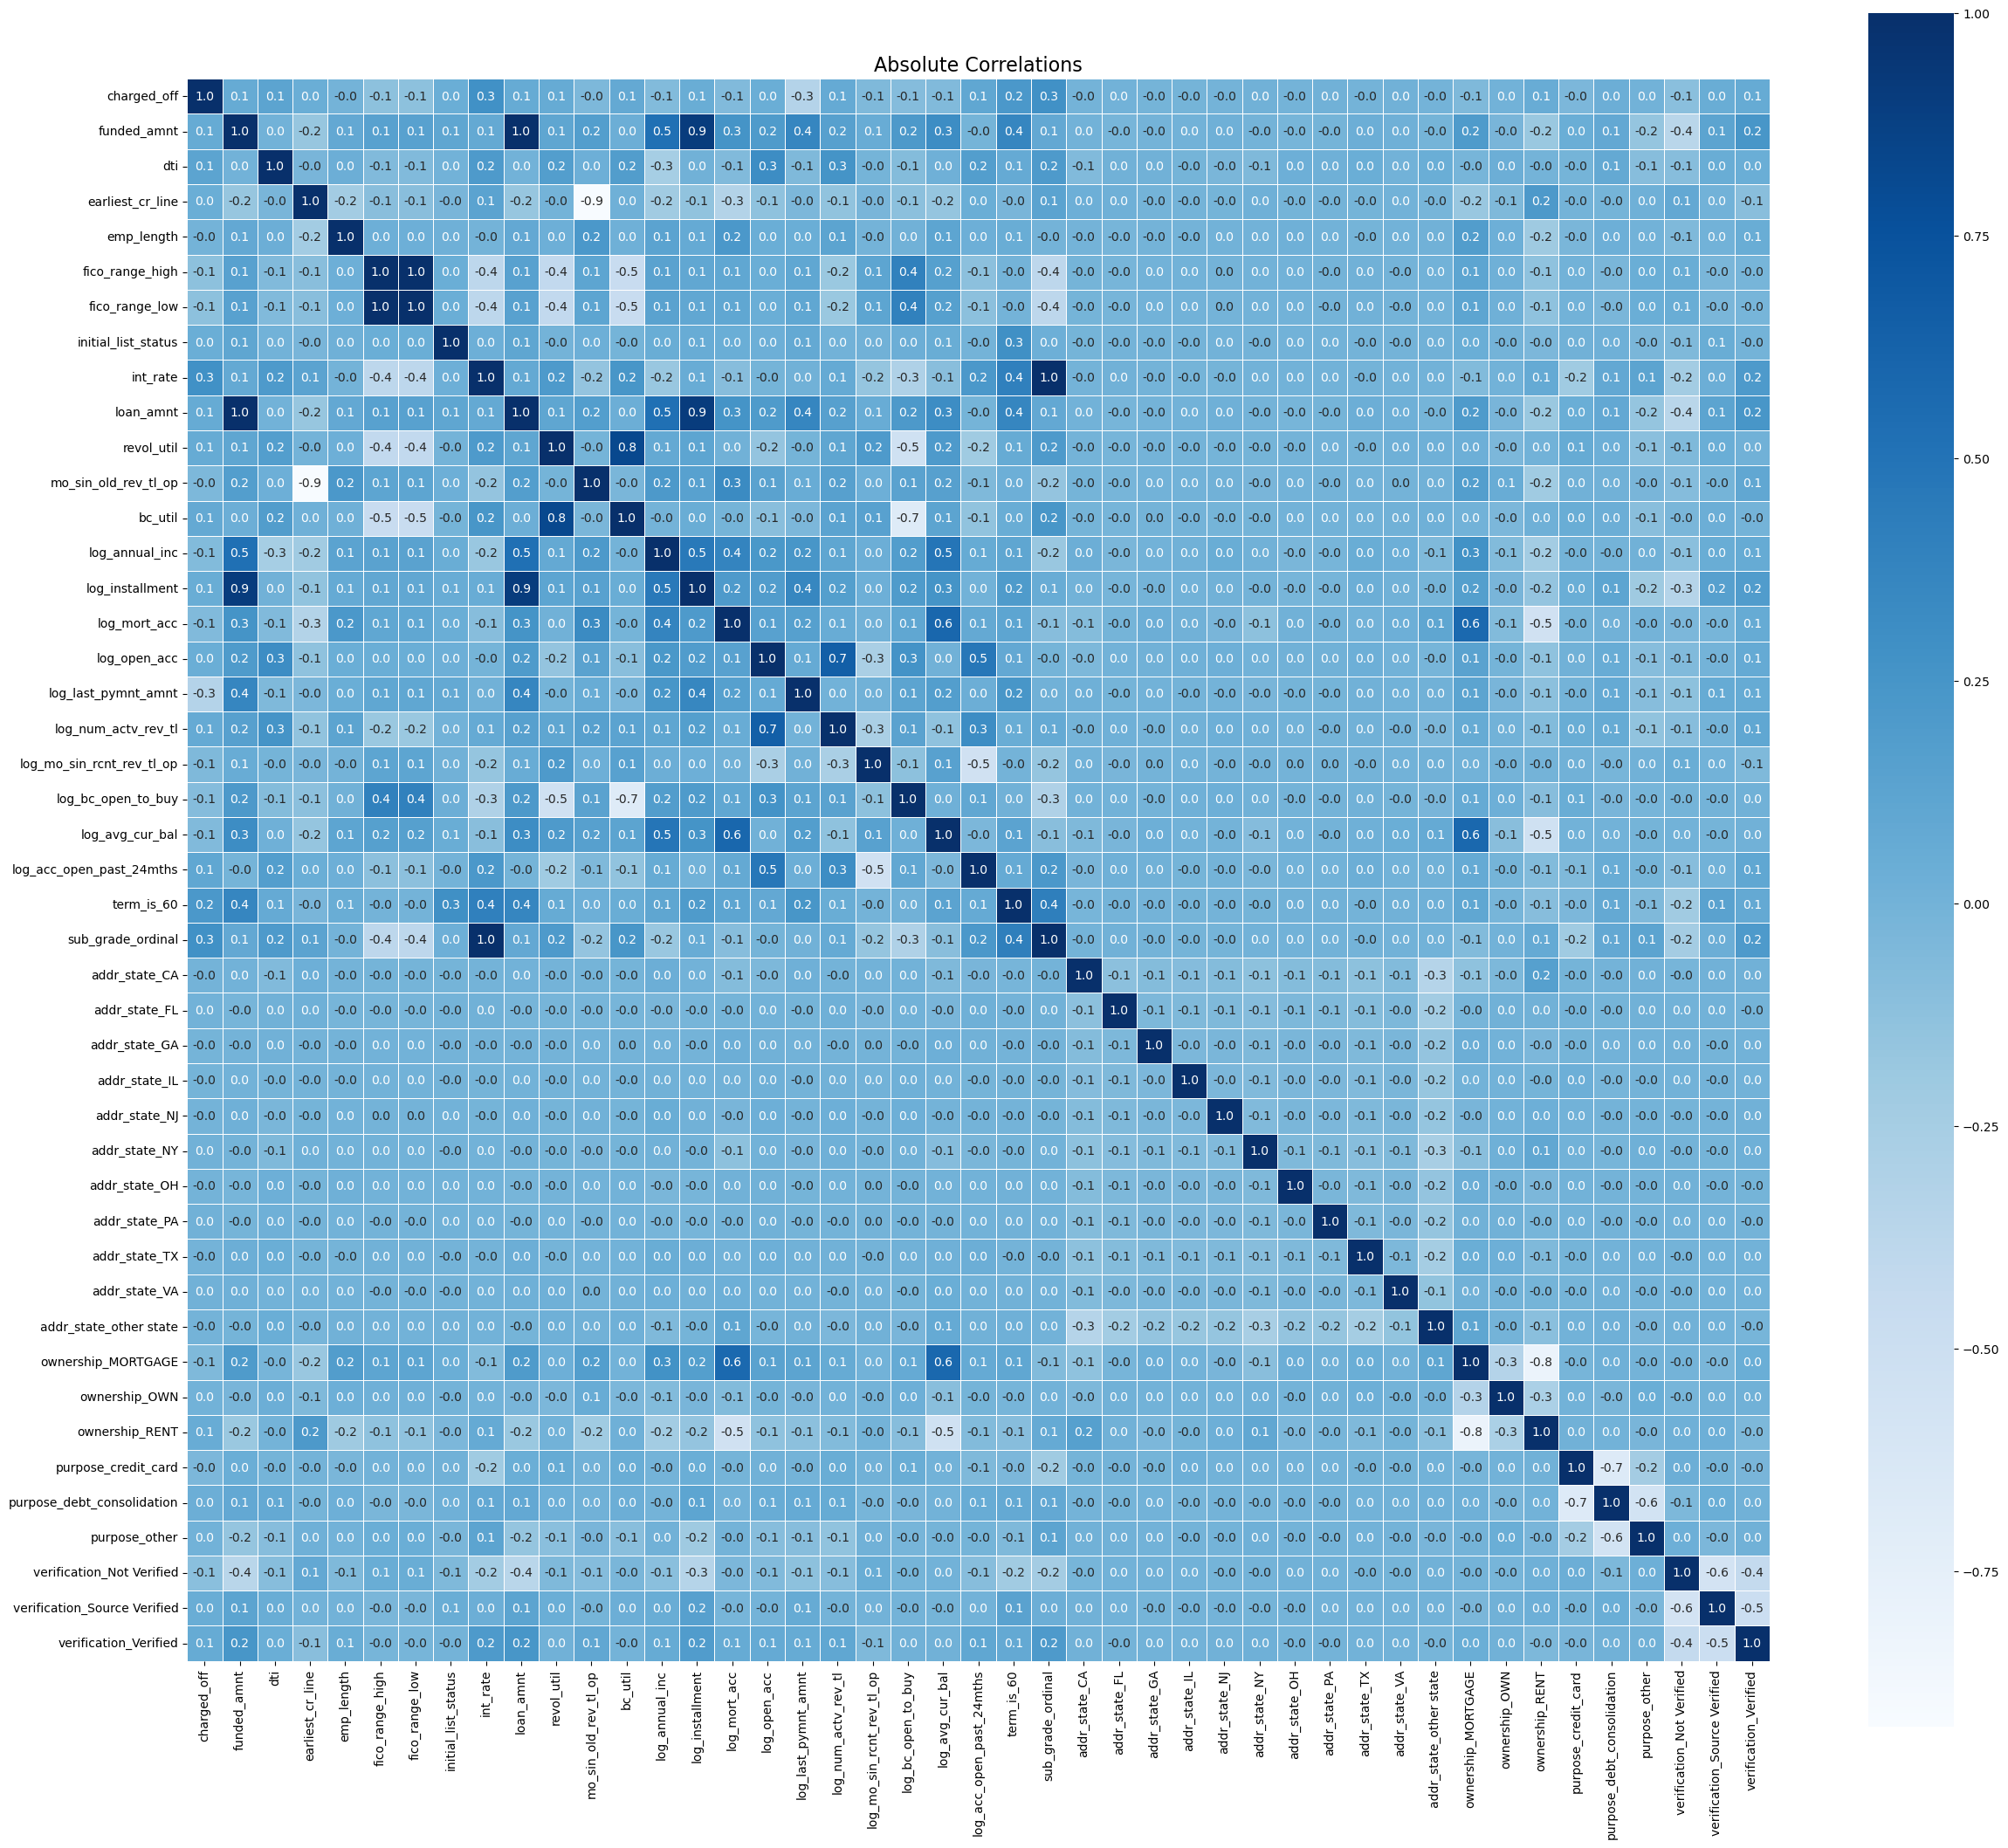

In [158]:
correlation_matrix = dataset.corr()
plt.figure(figsize=(25, 25))

sns.heatmap(correlation_matrix, 
            annot=True,         # Annotate cells with correlation coefficients
            fmt=".1f",          # Formatting for the annotations
            cmap="Blues",       # Use the Blues color map
            square=True,        # Square cells
            linewidths=0.5,     # Width of lines that will divide each cell
            cbar_kws={"shrink": .8}) 

plt.title('Absolute Correlations', fontsize=16)
plt.tight_layout()
plt.show();

<a id='3.4'></a>
## 4.3. Sampling Data

### To create a balanced dataset, draw 5500 rows at random from each of the two classes and combine them into a new dataframe.

Note from team: it might be not a really good way to solve the dataset, because many observations are ommitted in this way

In [161]:
target_column = 'charged_off'
classes = dataset[target_column].unique()

random_state = 12345
# Draw 5500 rows from each class
class_samples = []
for cls in classes:
    class_sample = dataset[dataset[target_column] == cls].sample(n=5500, random_state=random_state)
    class_samples.append(class_sample)

# df is balanced dataset
df = pd.concat(class_samples, ignore_index=True)

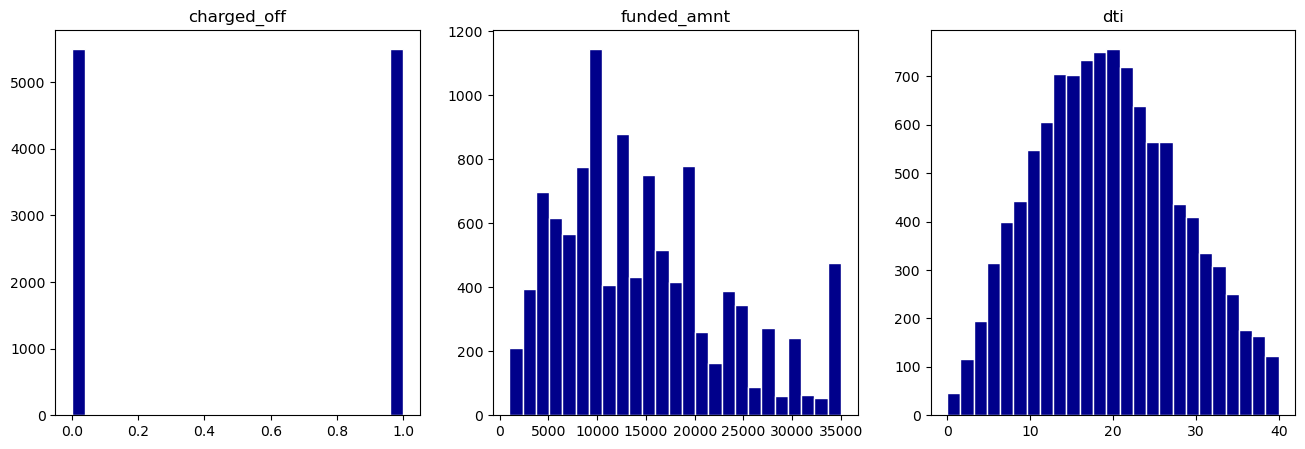

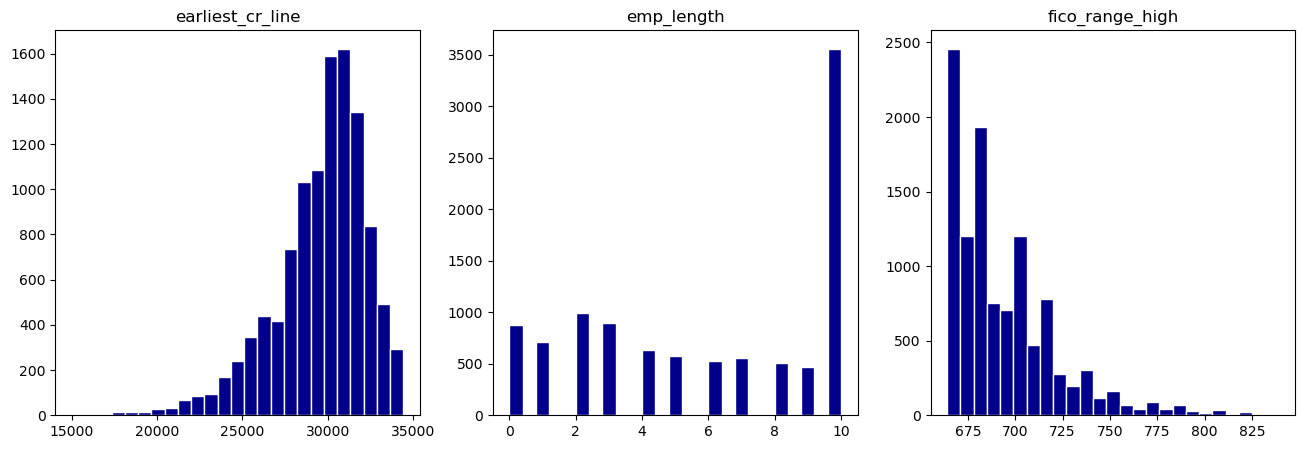

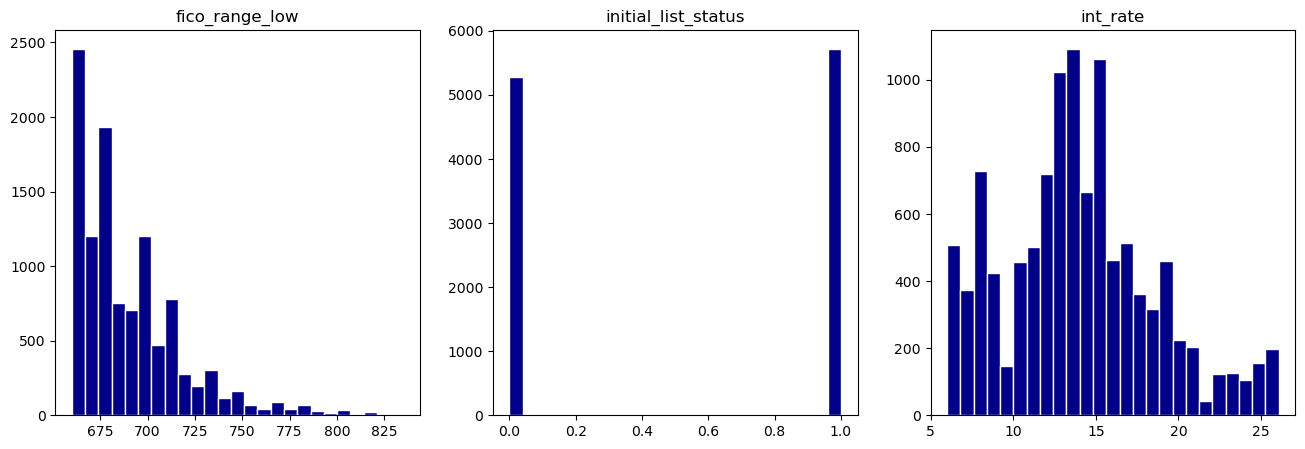

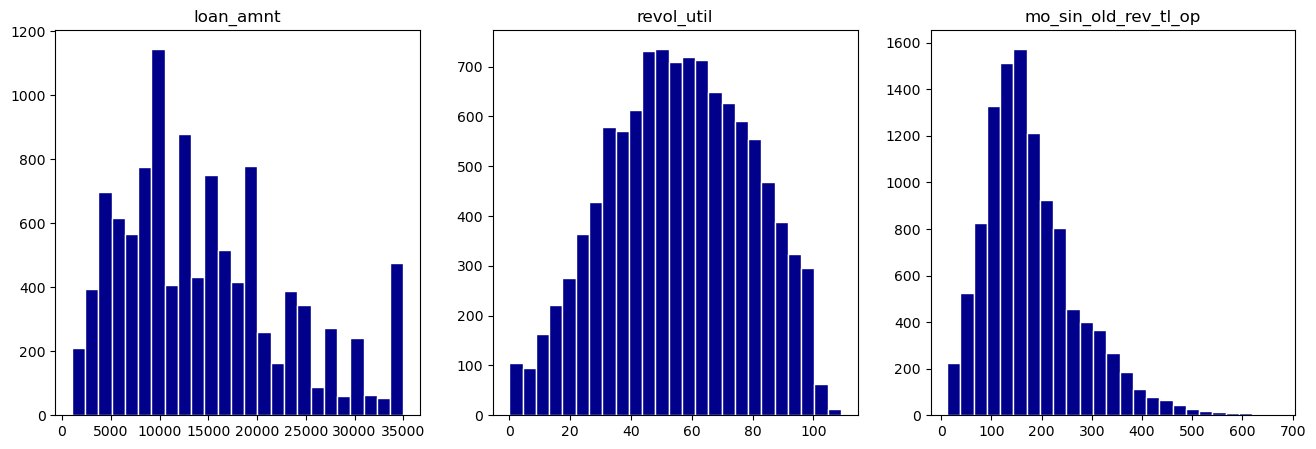

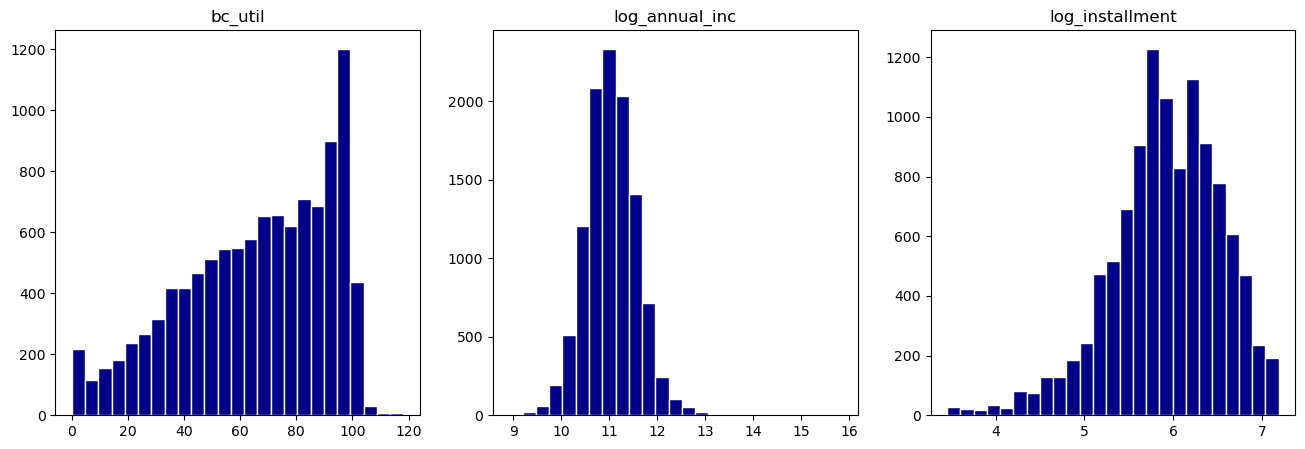

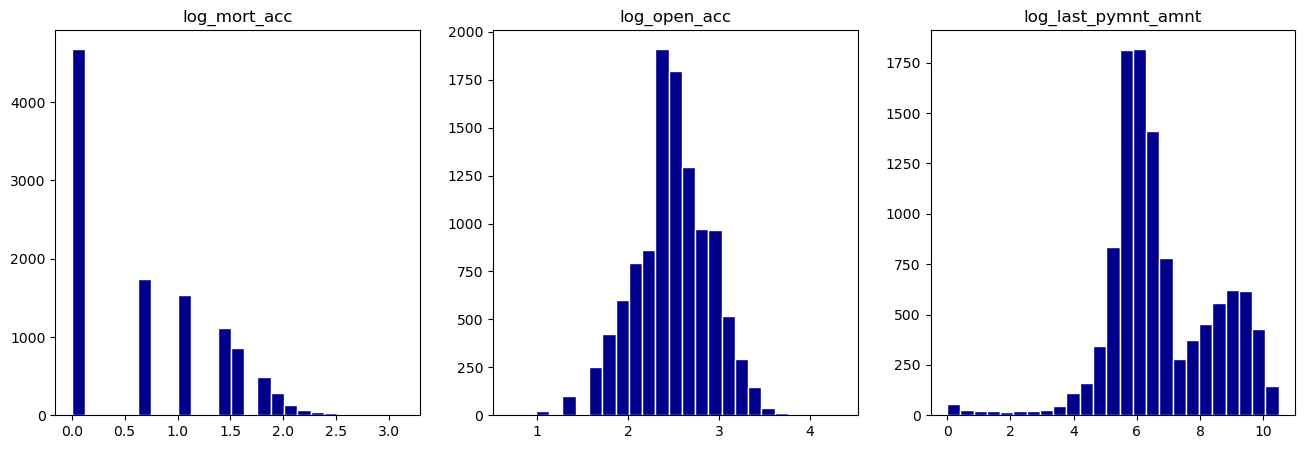

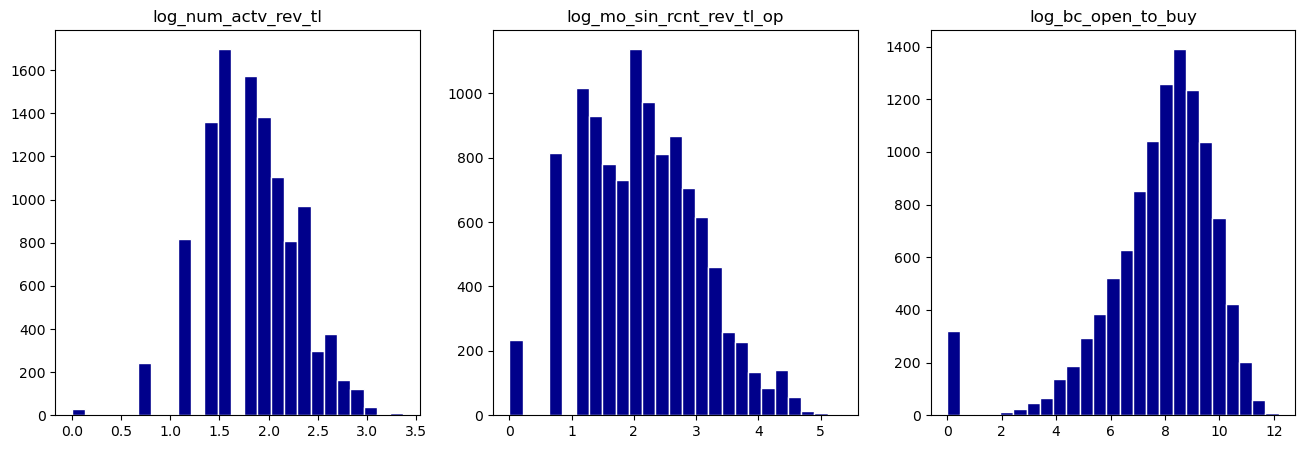

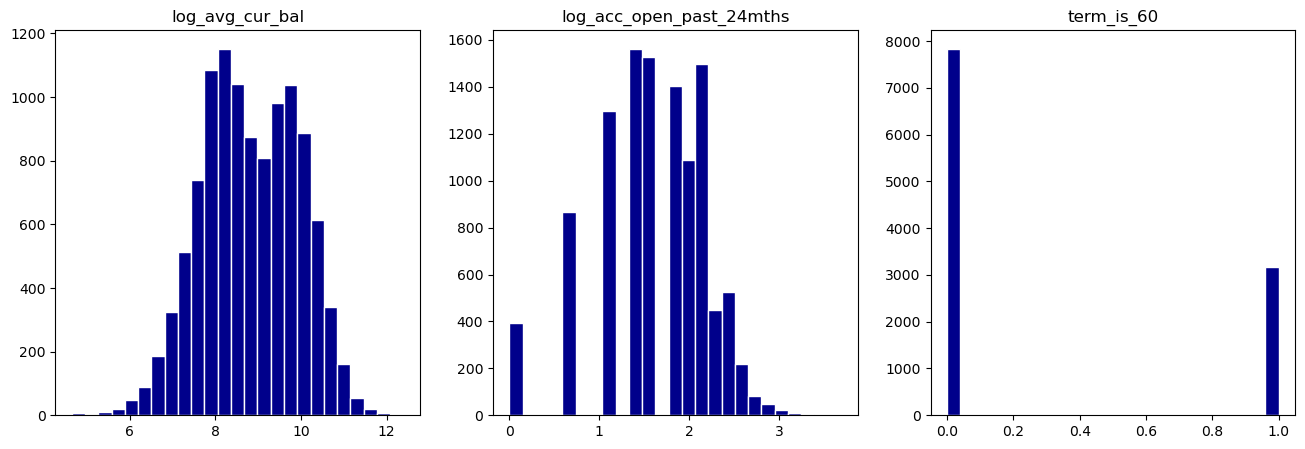

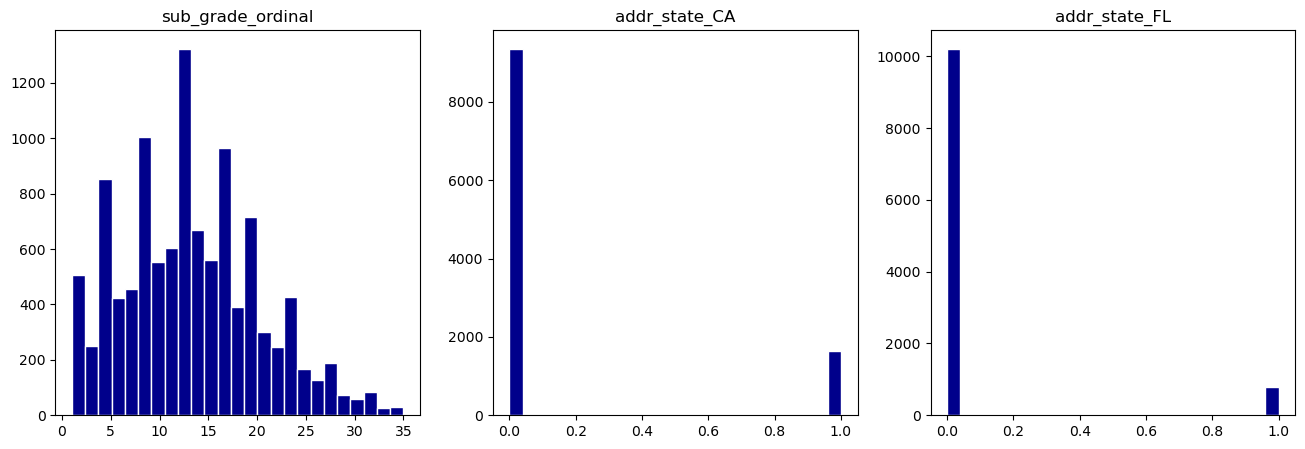

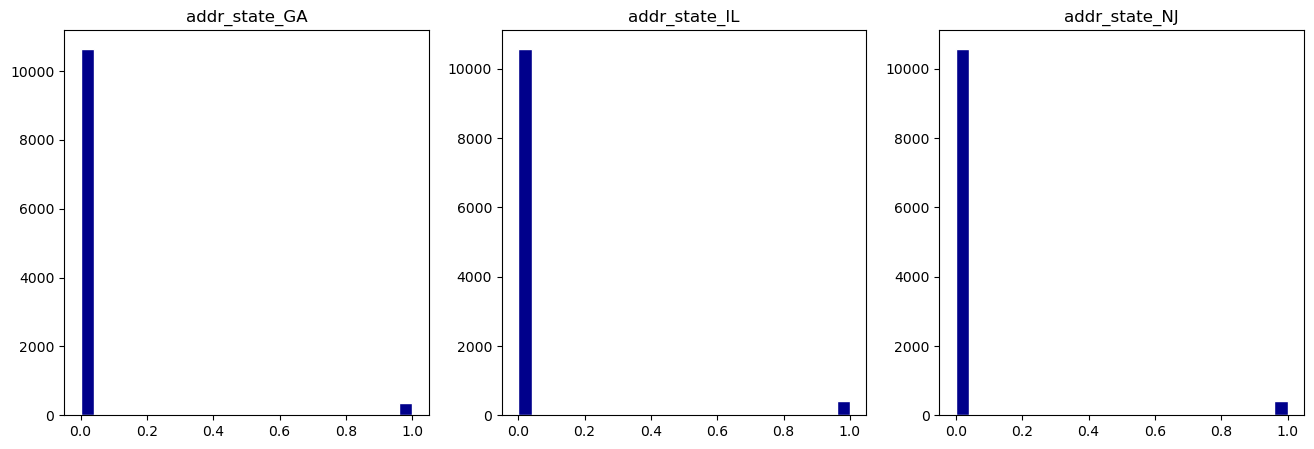

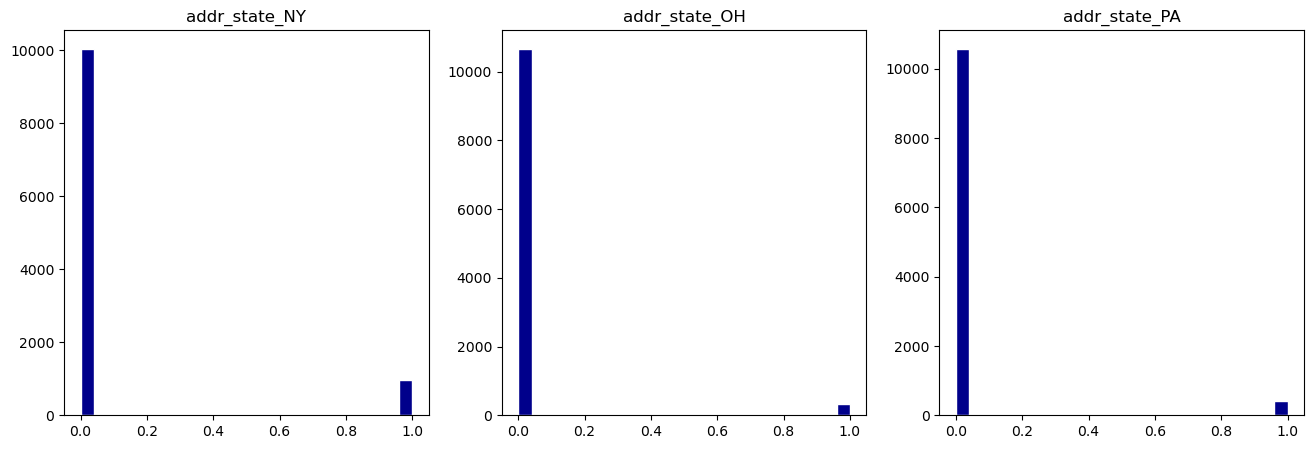

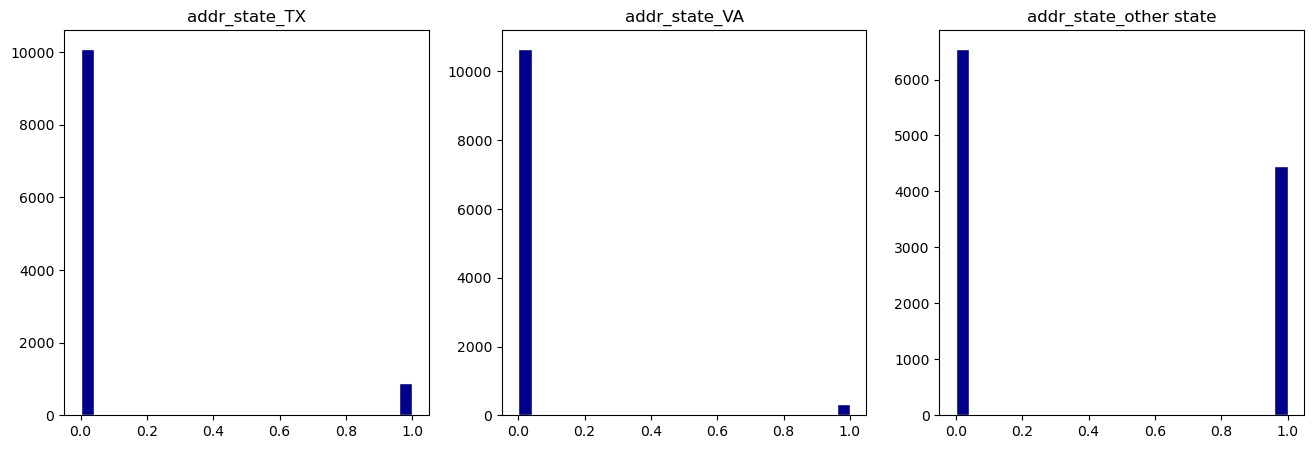

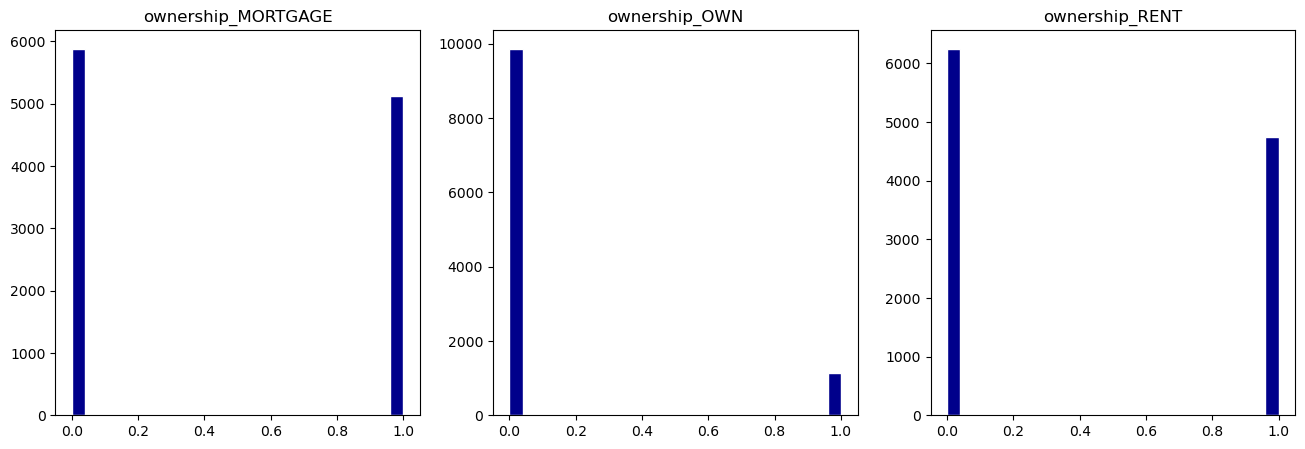

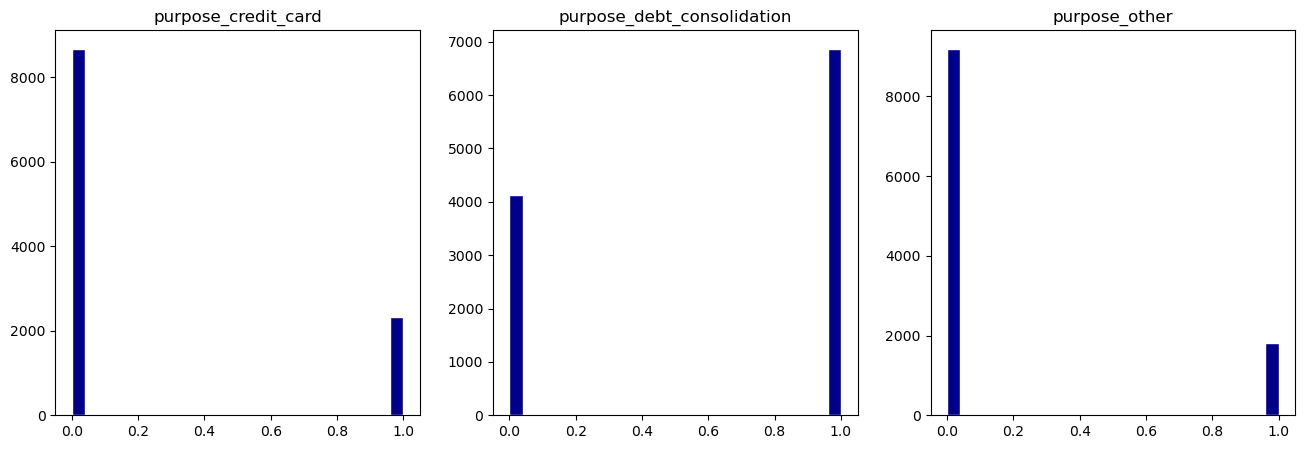

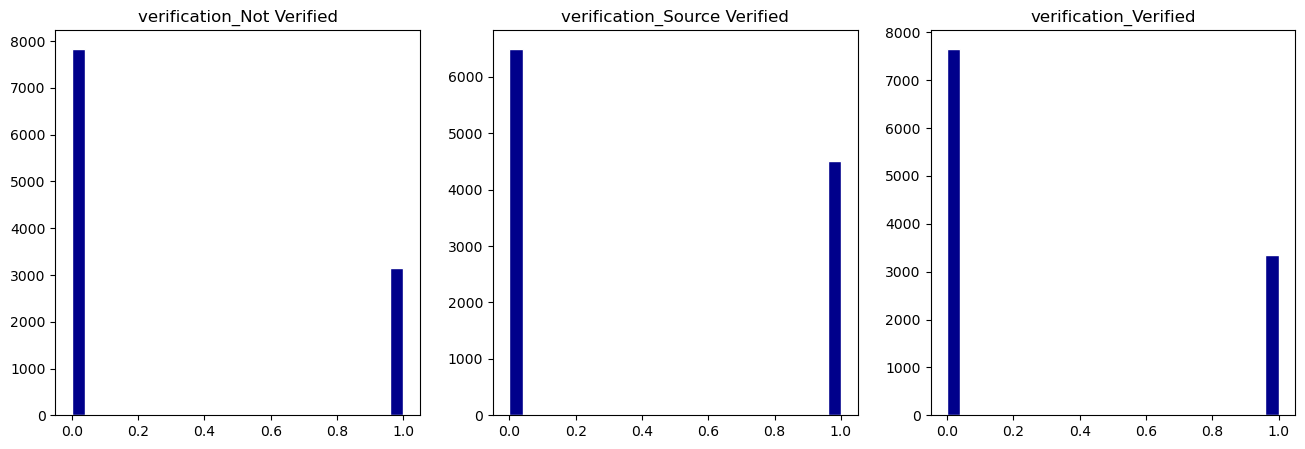

In [162]:
numerical_columns = dataset.columns
for i in np.arange(0,len(numerical_columns),3):

    fig, ax = plt.subplots(1, 3, figsize=(16,5), sharey=False)
    
    ax[0].hist(df[numerical_columns[i]], color = 'darkblue', edgecolor = 'white', bins = 25)
    ax[1].hist(df[numerical_columns[i+1]], color = 'darkblue', edgecolor = 'white', bins = 25)
    if i+2 < len(numerical_columns):
        ax[2].hist(df[numerical_columns[i+2]], color = 'darkblue', edgecolor = 'white', bins = 25)
        ax[2].set_title(numerical_columns[i+2])
        
    ax[0].set_title(numerical_columns[i])
    ax[1].set_title(numerical_columns[i+1])

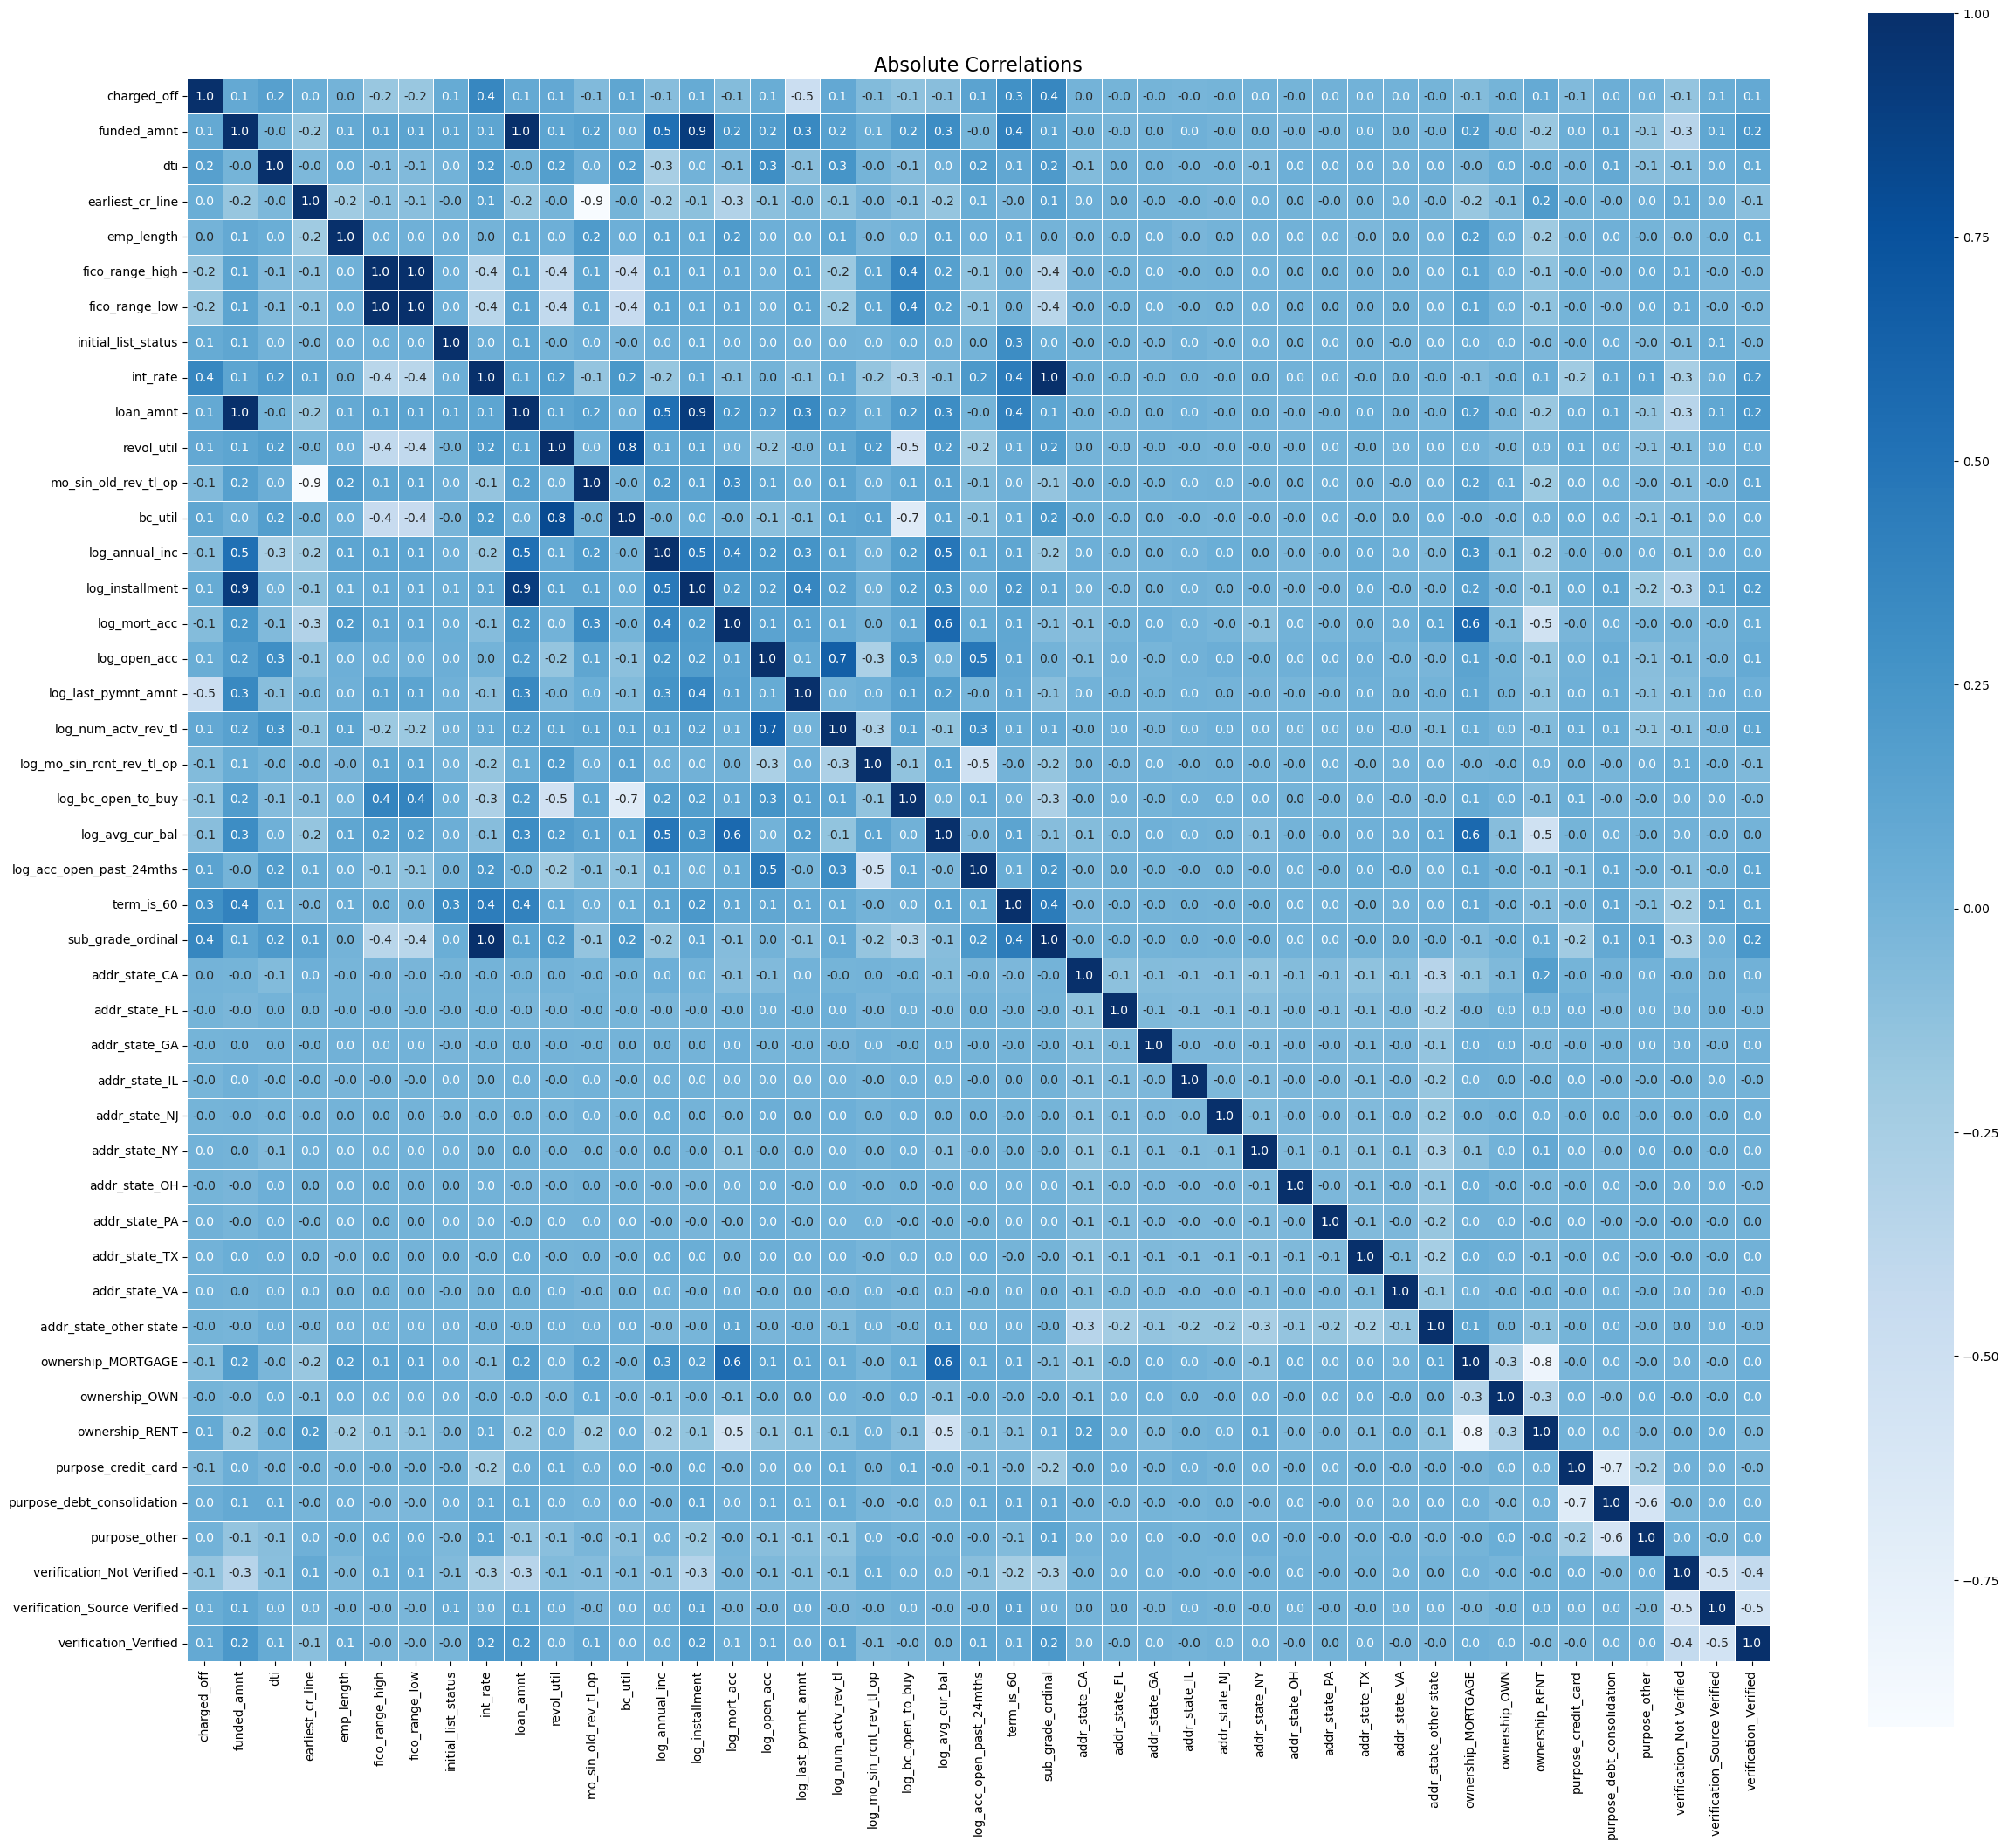

In [163]:
correlation_matrix = df.corr()
plt.figure(figsize=(25, 25))

sns.heatmap(correlation_matrix, 
            annot=True,         # Annotate cells with correlation coefficients
            fmt=".1f",          # Formatting for the annotations
            cmap="Blues",       # Use the Blues color map
            square=True,        # Square cells
            linewidths=0.5,     # Width of lines that will divide each cell
            cbar_kws={"shrink": .8}) 

plt.title('Absolute Correlations', fontsize=16)
plt.tight_layout()
plt.show();

### Choose a method to handle any NAs that may be in a column.

In [165]:
df.isnull().sum().sort_values(ascending = False)[:5]

emp_length                706
bc_util                   118
log_bc_open_to_buy        110
revol_util                  7
addr_state_other state      0
dtype: int64

mode for emp_length, because it has many observations of value 10

mean for other features, because they take many different values


In [167]:
emp_length_mode = df['emp_length'].mode()[0]
df['emp_length'].fillna(emp_length_mode, inplace=True)

columns_with_na = ['bc_util', 'log_bc_open_to_buy', 'revol_util']
for col in columns_with_na:
    mean_value = df[col].mean()
    df[col].fillna(mean_value, inplace=True)

In [168]:
df.isnull().sum().sort_values(ascending = False)[:5]

charged_off      0
term_is_60       0
addr_state_CA    0
addr_state_FL    0
addr_state_GA    0
dtype: int64

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

### Use an 80:20 split

In [172]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# make X and y
X = df.drop(columns=['charged_off'])
y = df['charged_off']

# make teh split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

### Additionally we are Using Standard Scaler

We fit it on train and transform train and test. We leave dummy variables as they are (0 and 1) without scaling

In [174]:
# find contineous and dummy features
features_to_scale = [feature for feature in X_train.columns if X_train[feature].nunique() > 2]
features_dummy = [feature for feature in X_train.columns if X_train[feature].nunique() == 2]

In [175]:
# scale the features
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

In [176]:
# assemble train and test back

X_train = pd.concat([X_train_scaled[features_to_scale],X_train[features_dummy]],axis = 1)
X_test = pd.concat([X_test_scaled[features_to_scale],X_test[features_dummy]],axis = 1)

Final check of distributions using histograms

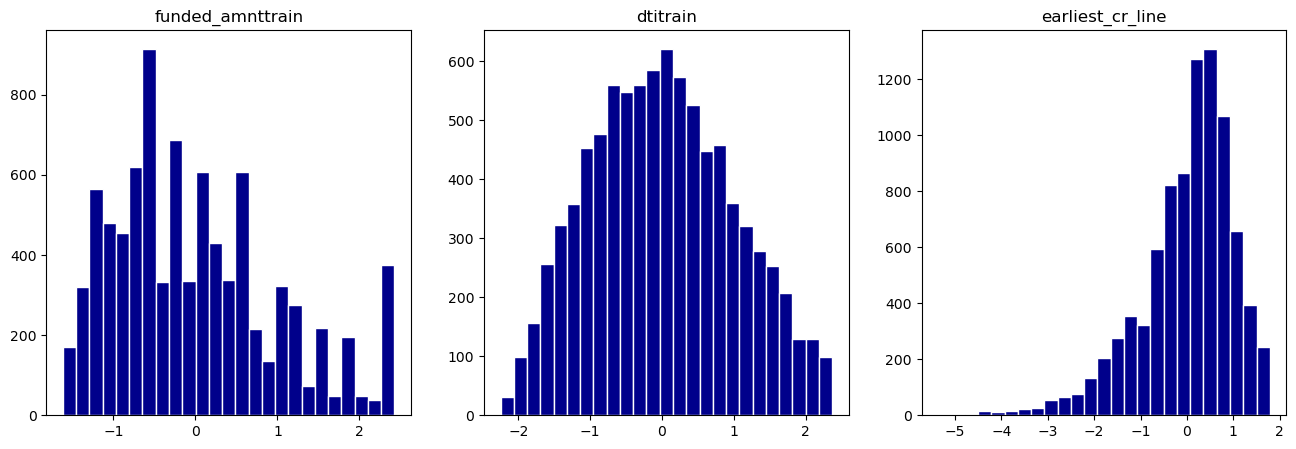

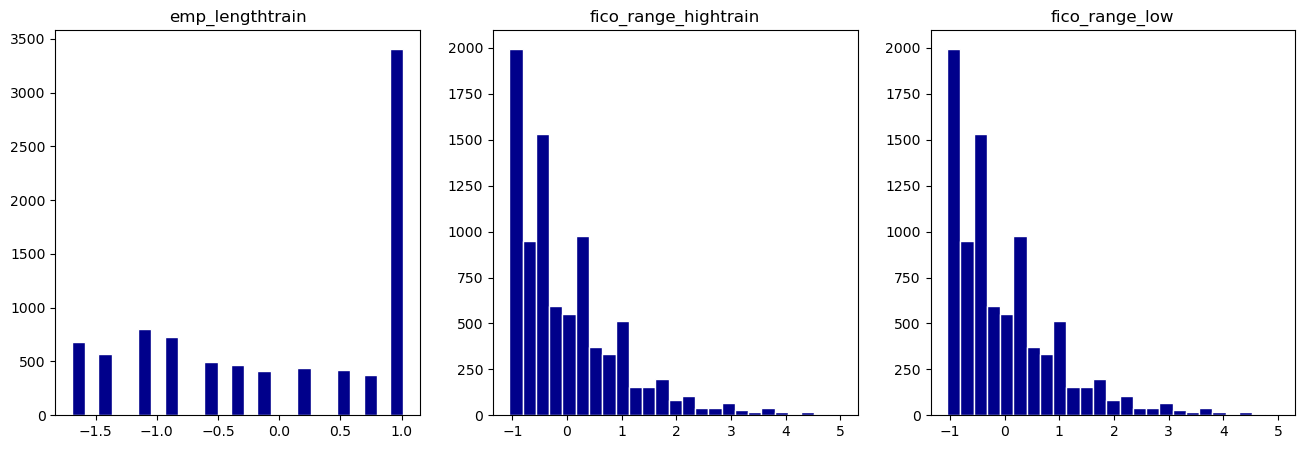

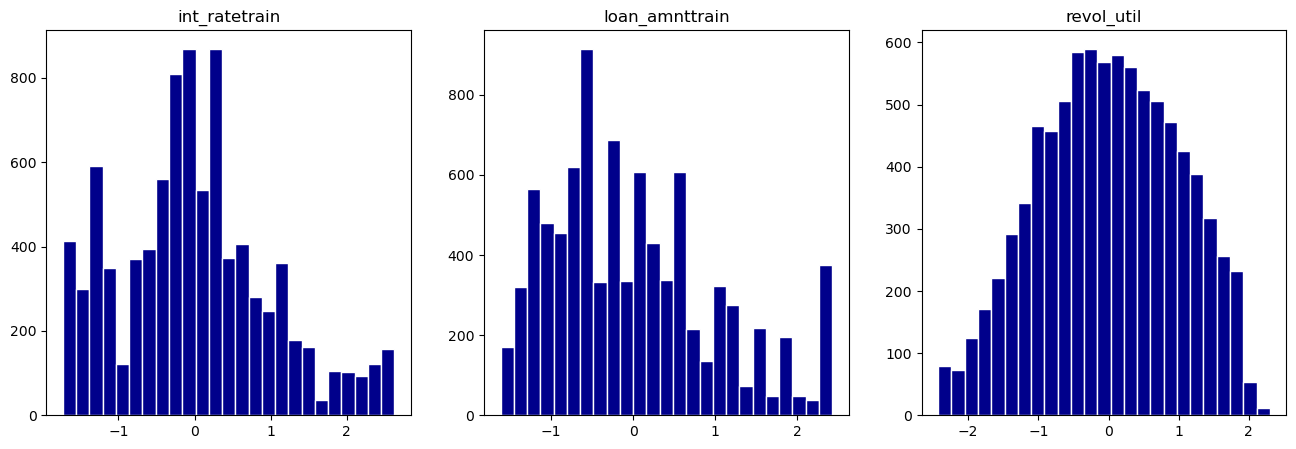

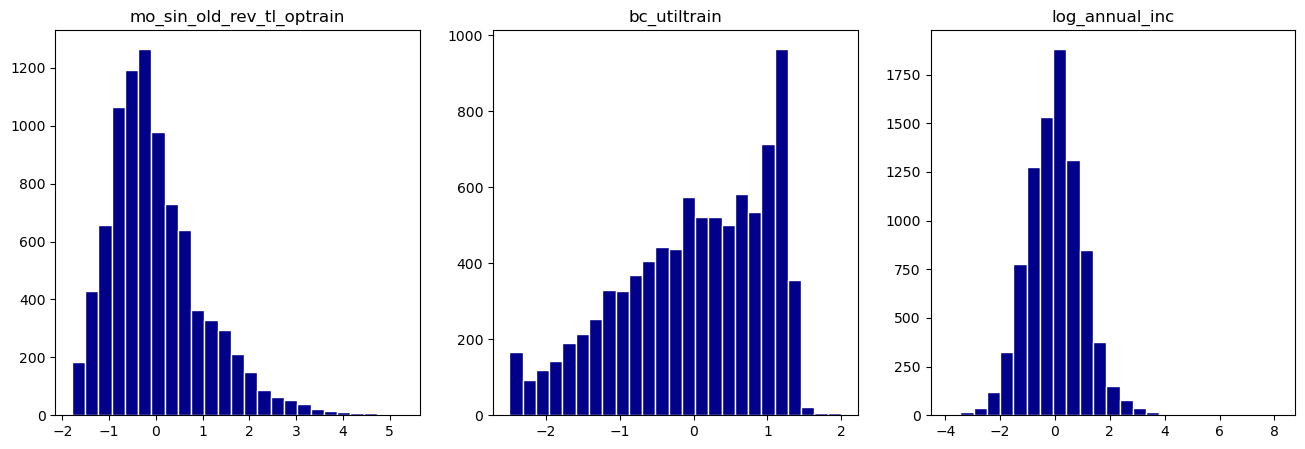

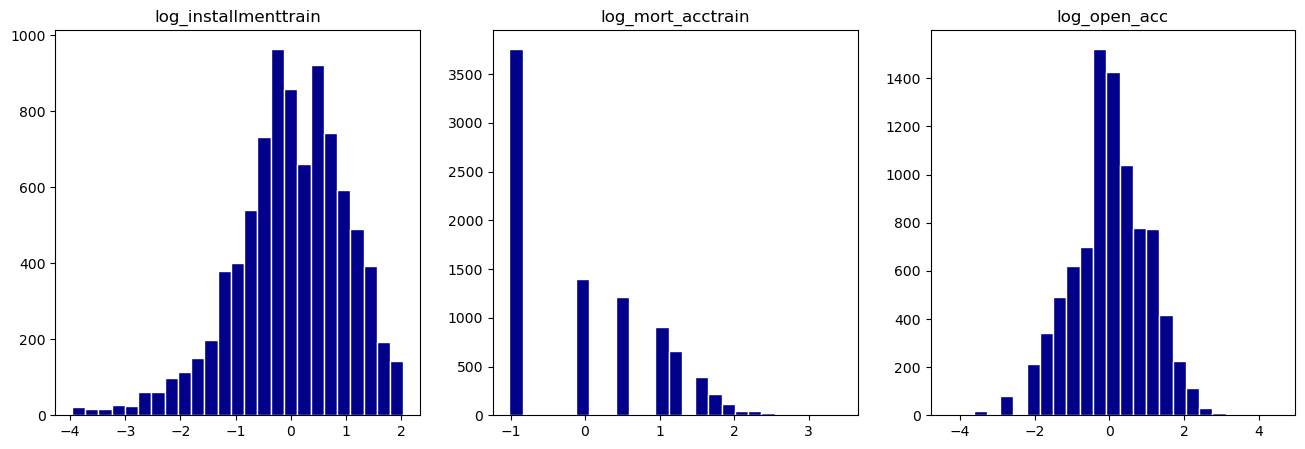

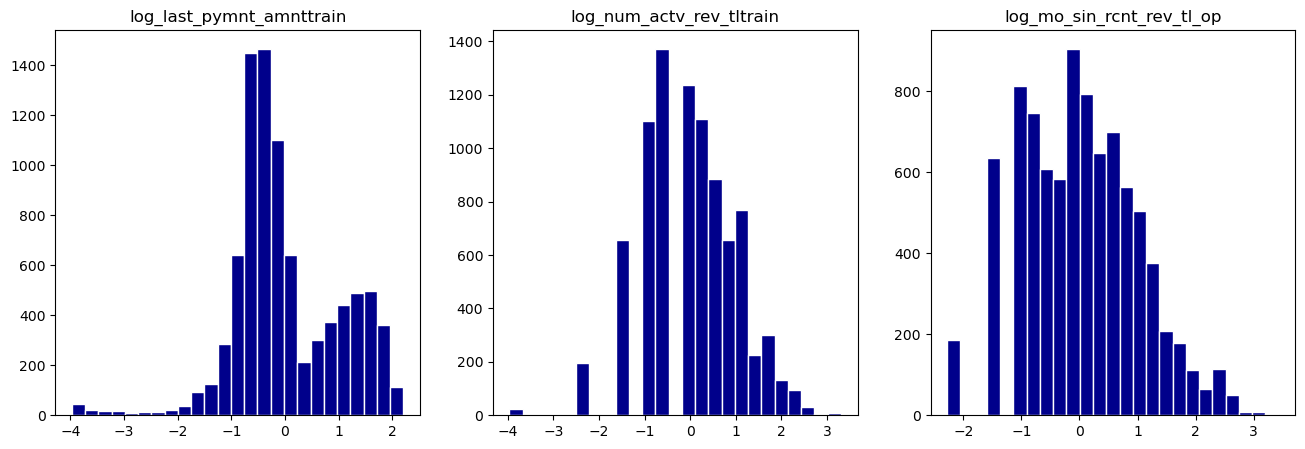

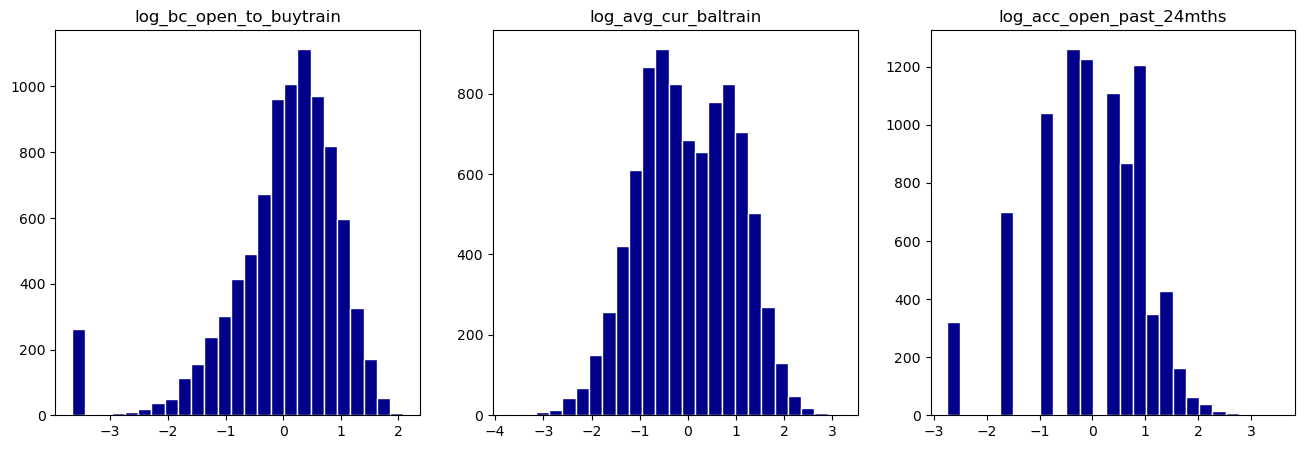

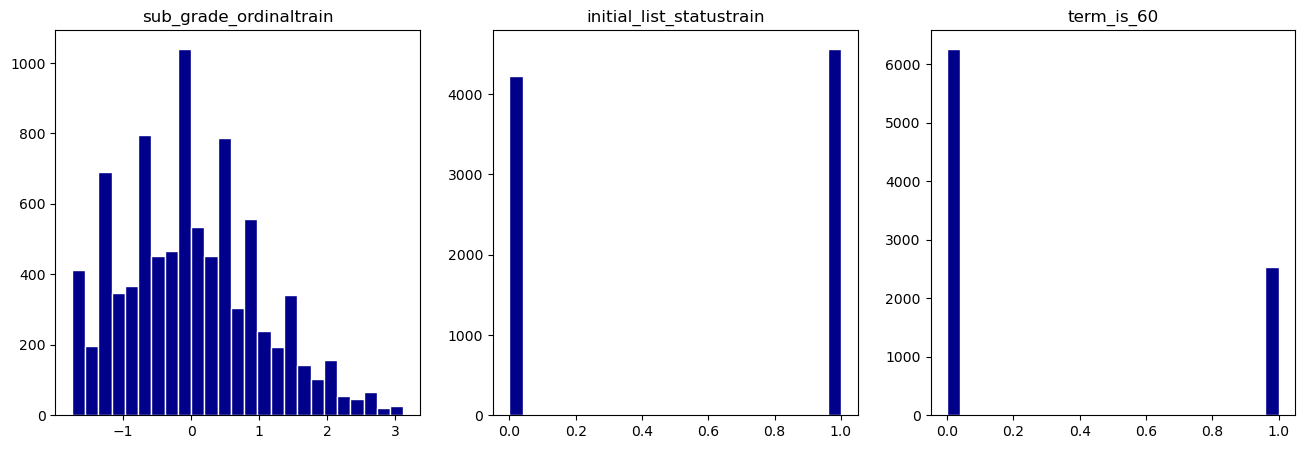

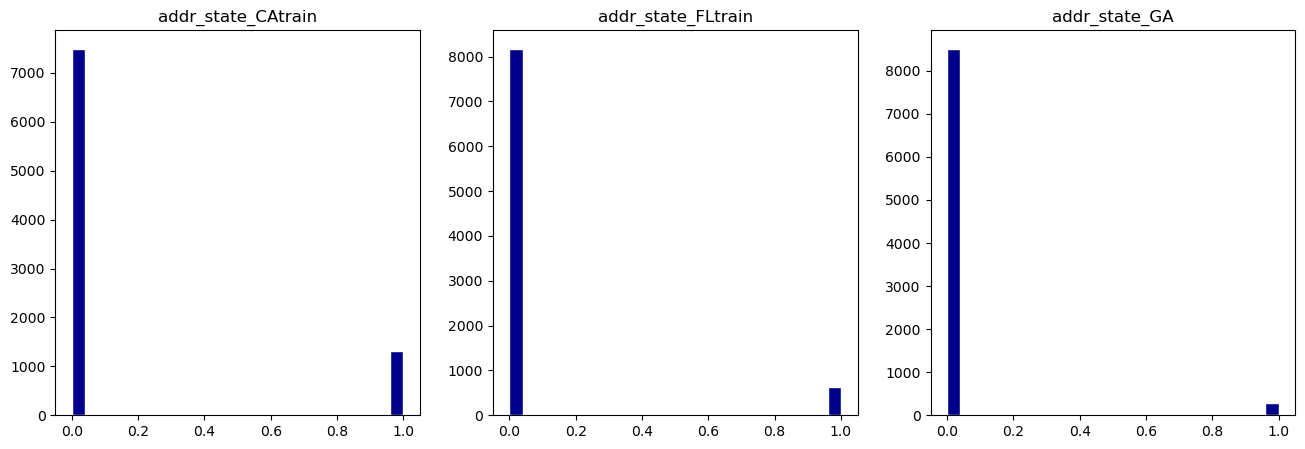

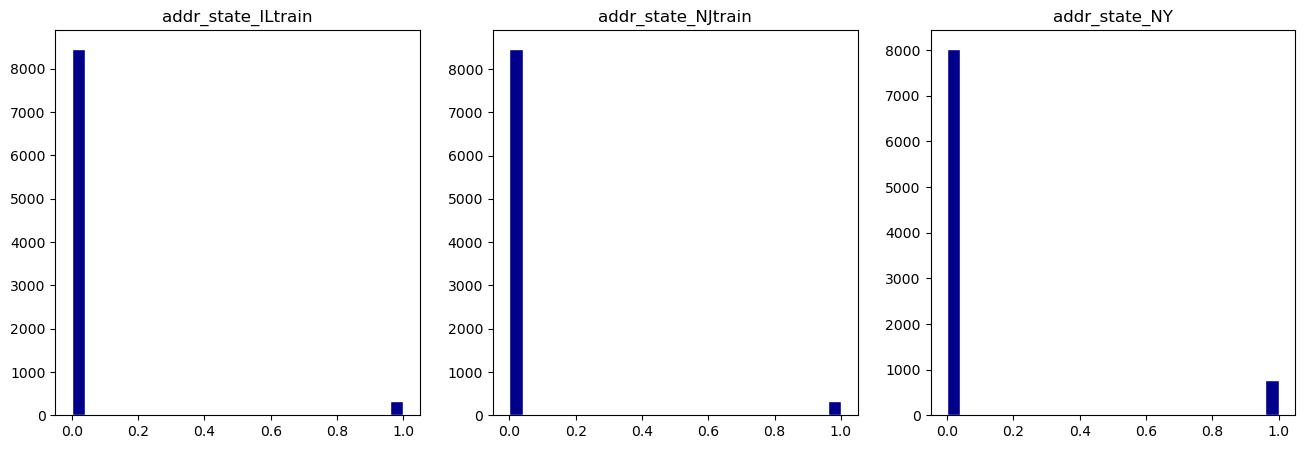

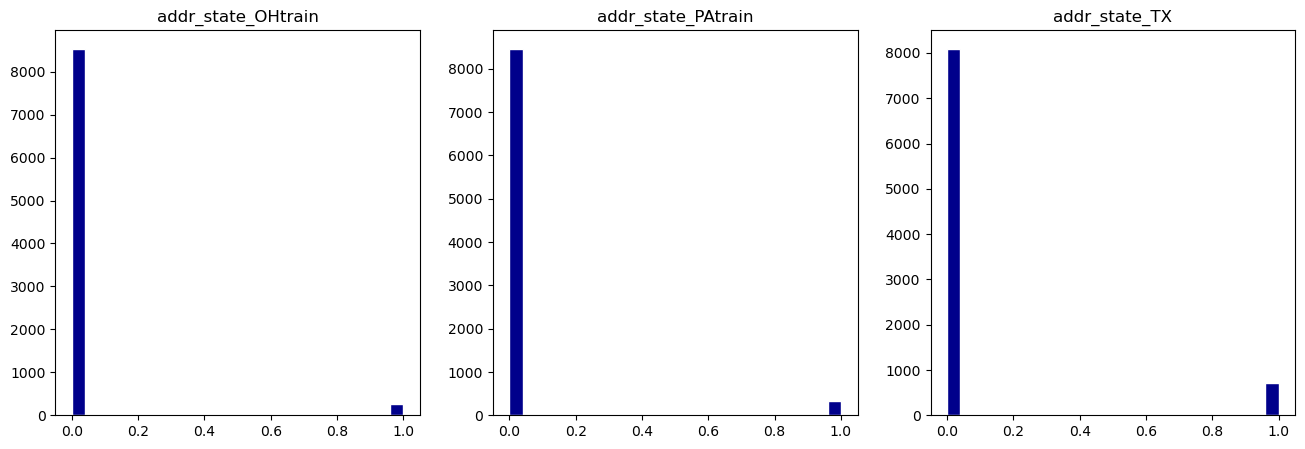

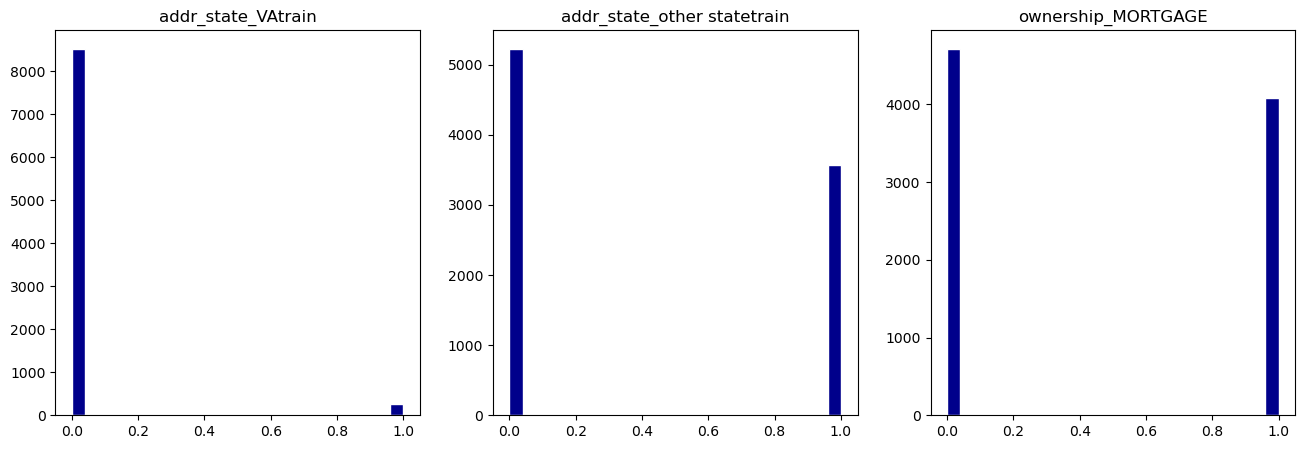

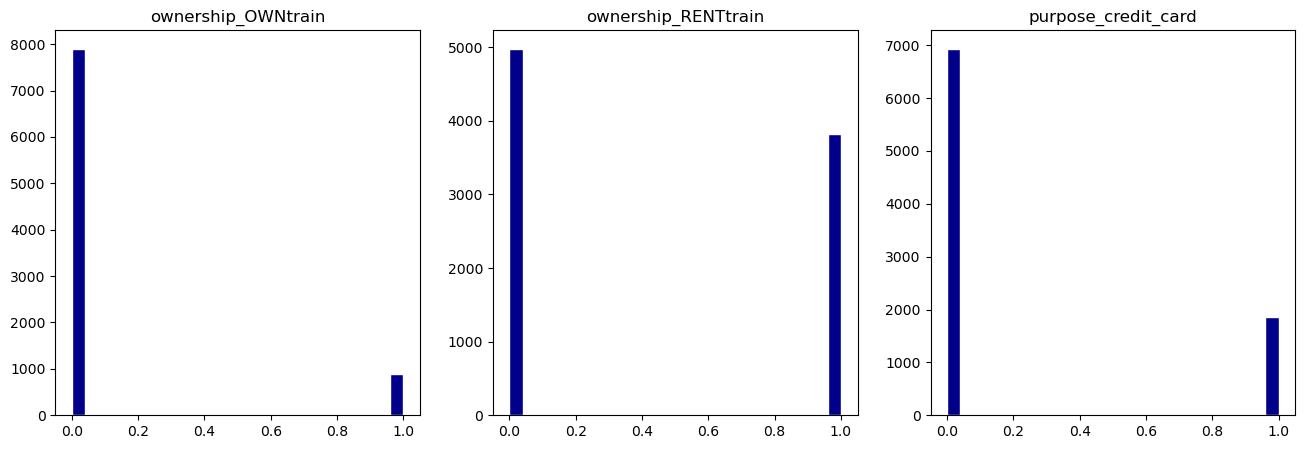

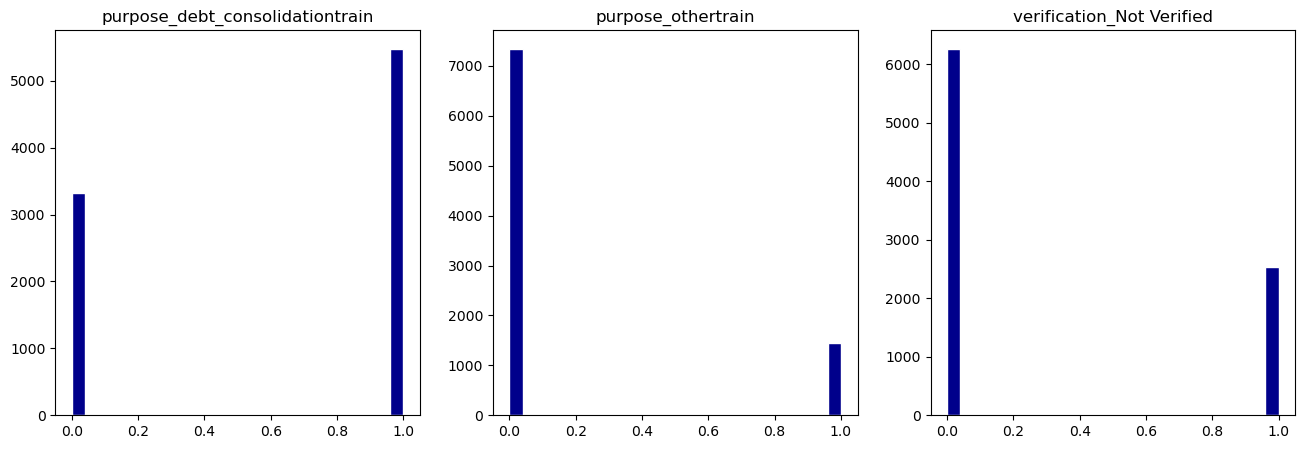

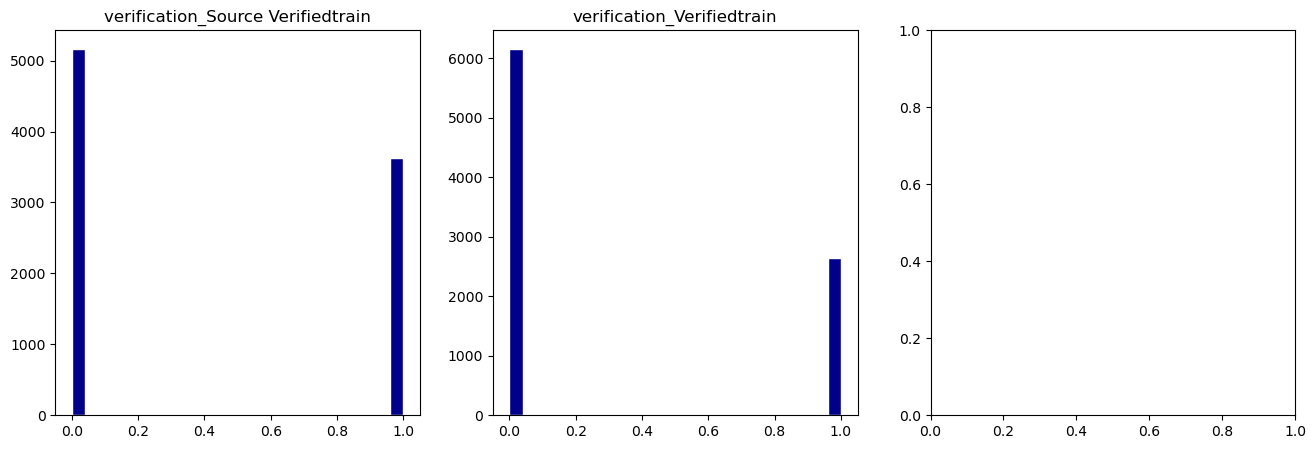

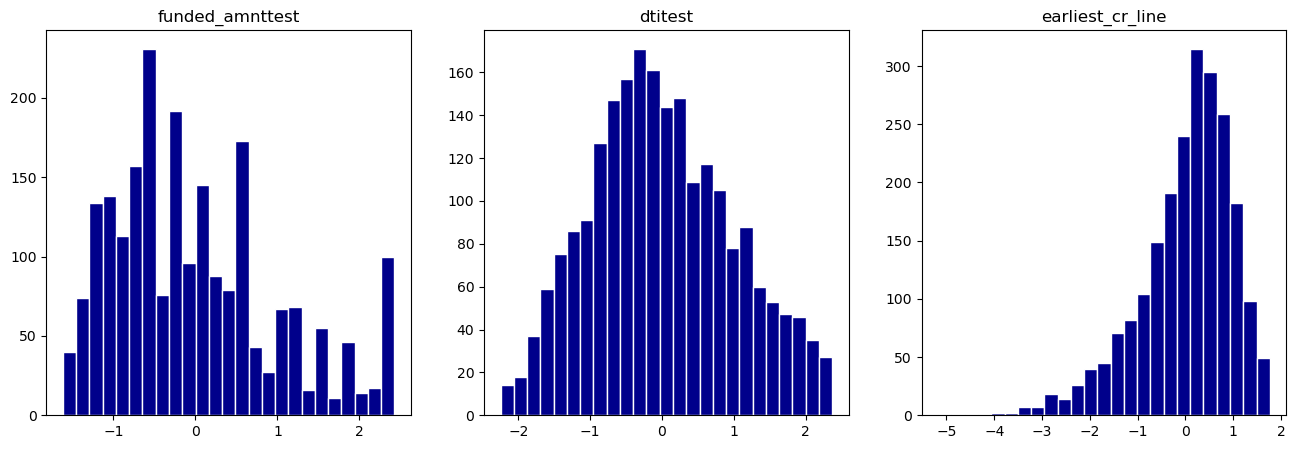

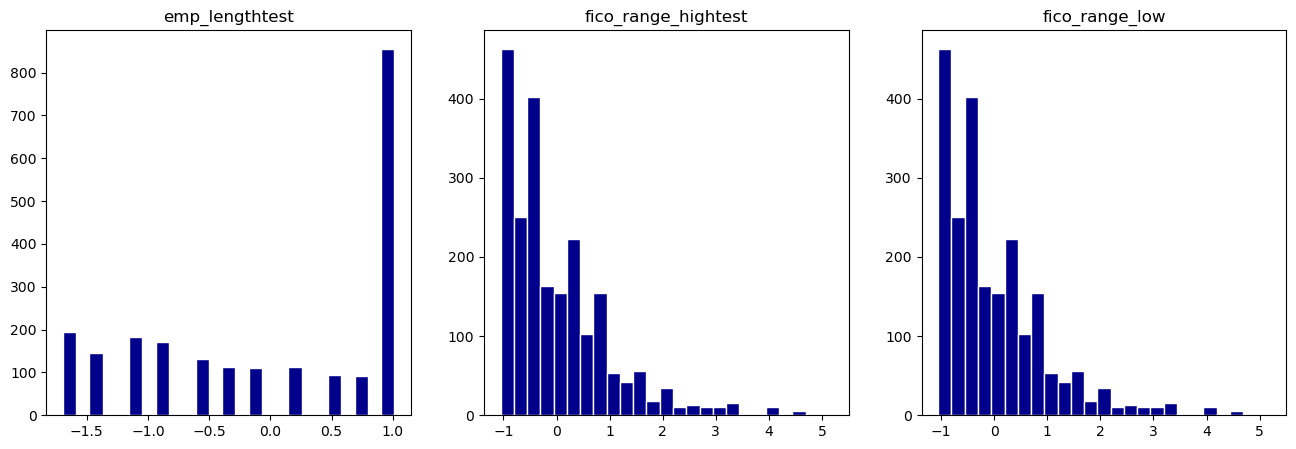

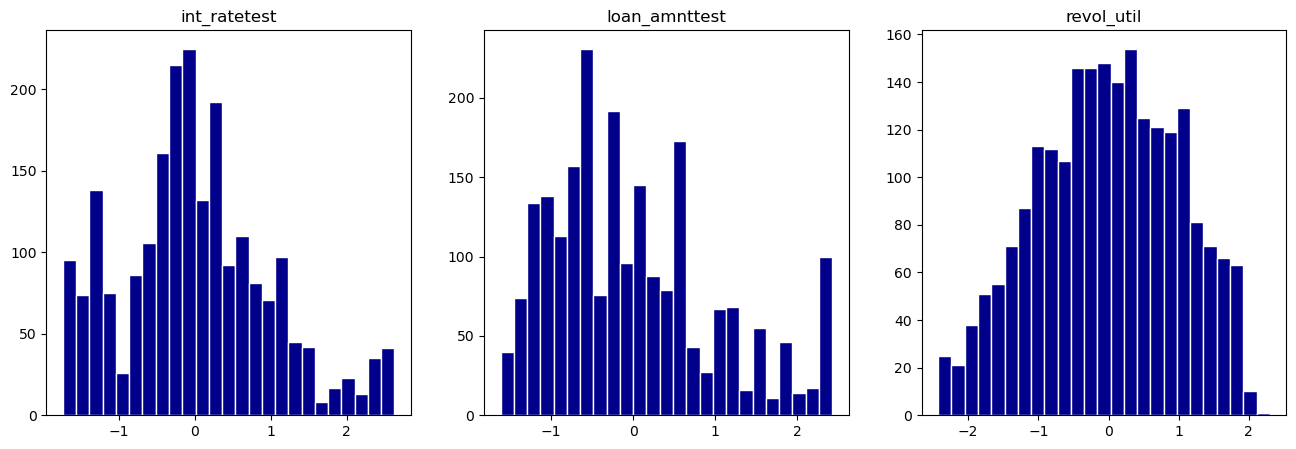

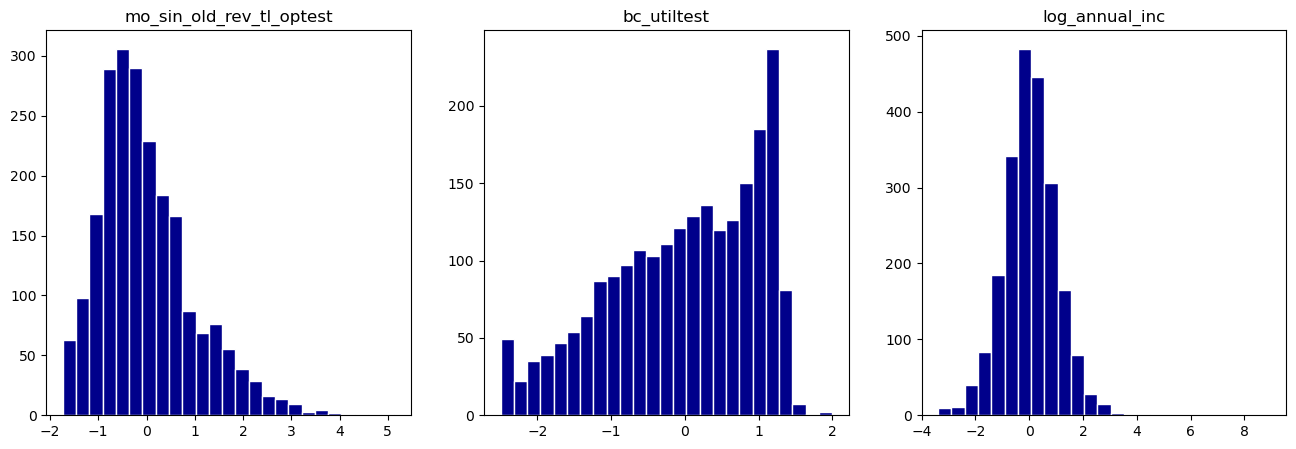

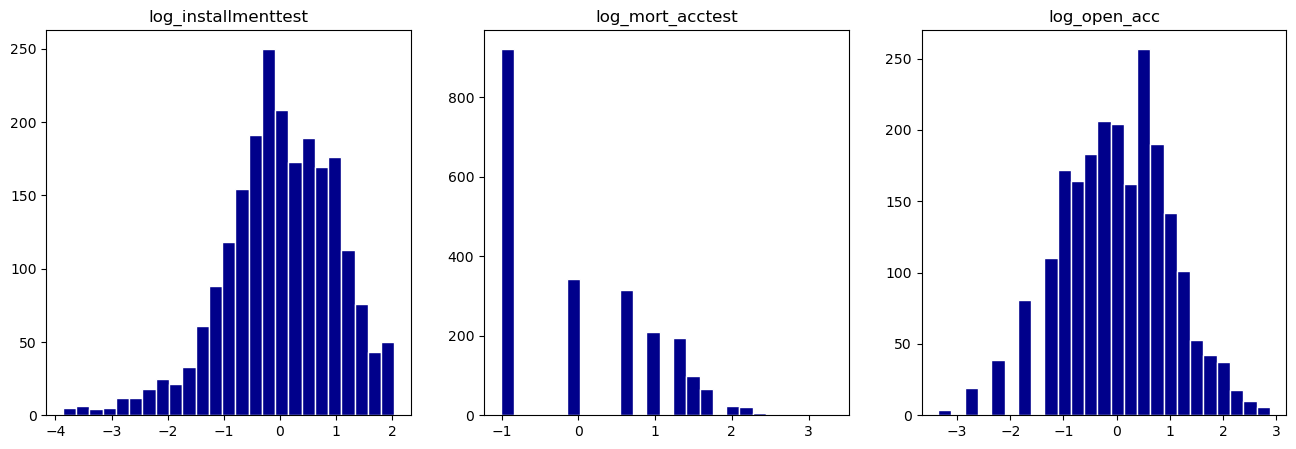

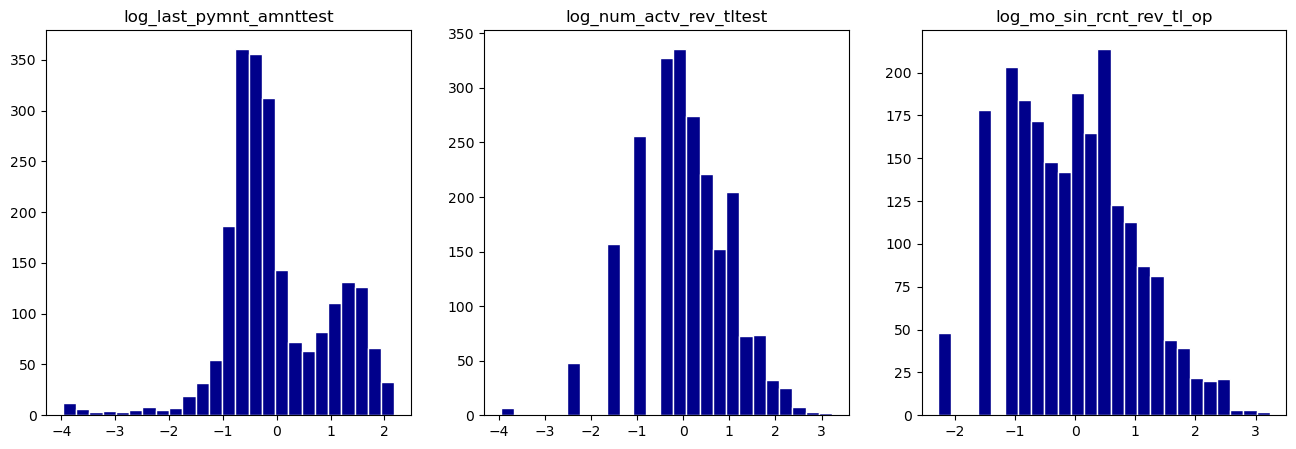

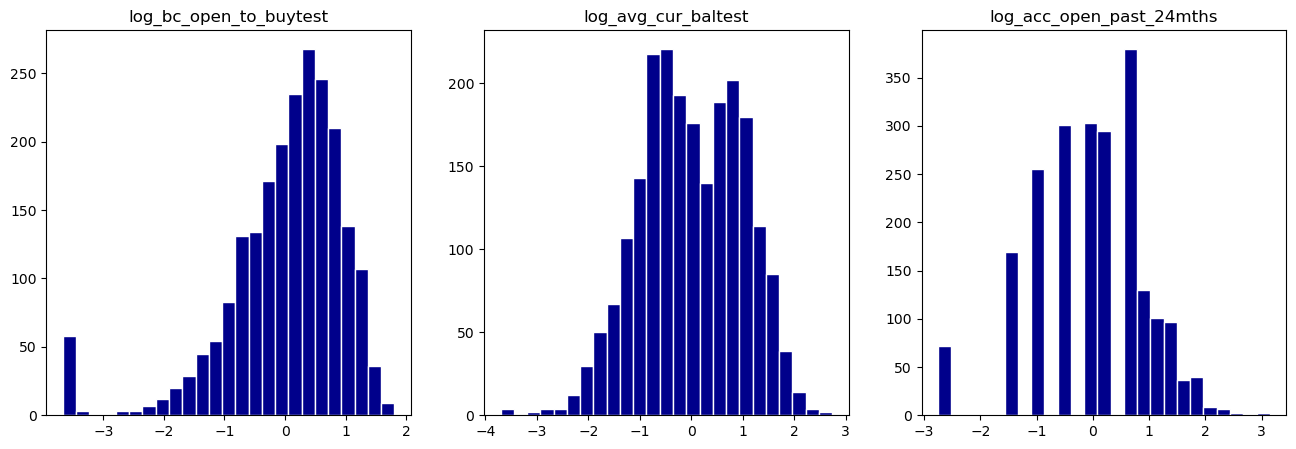

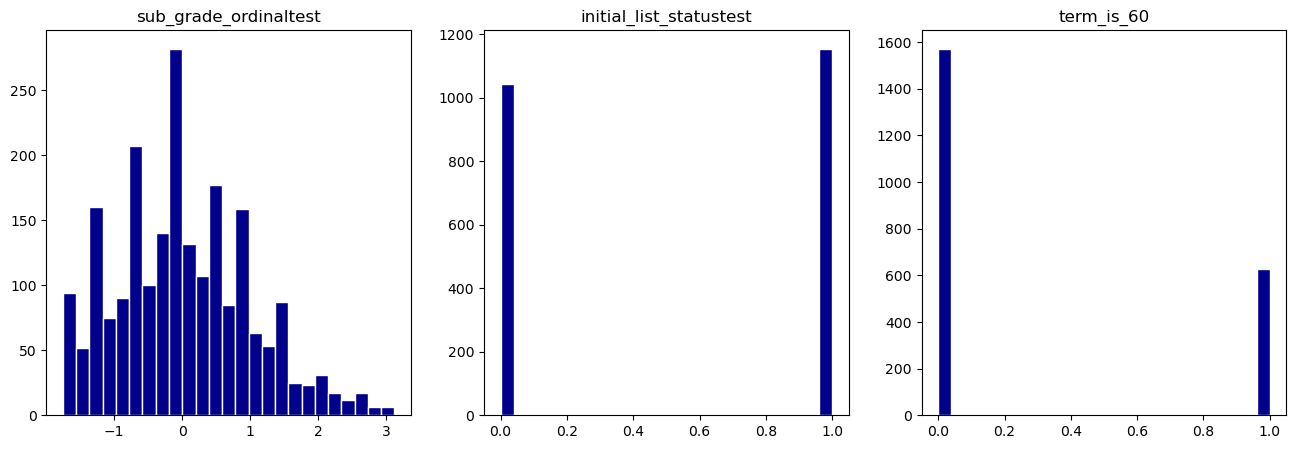

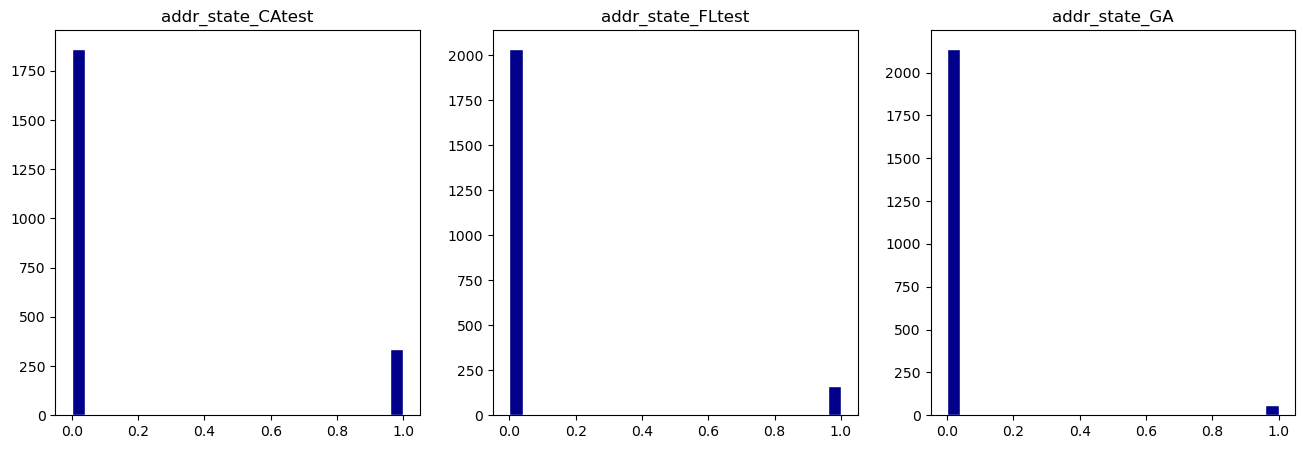

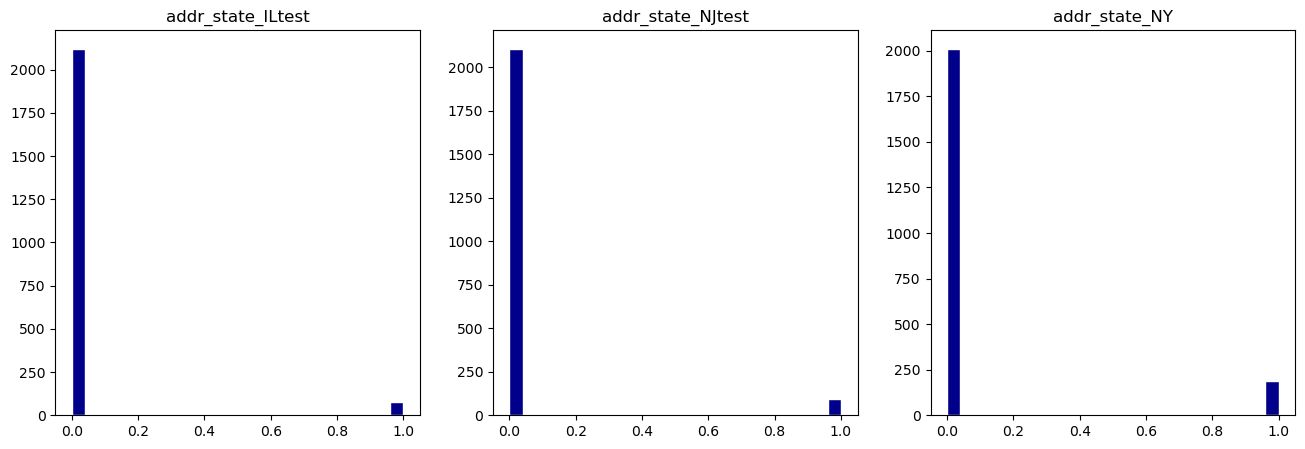

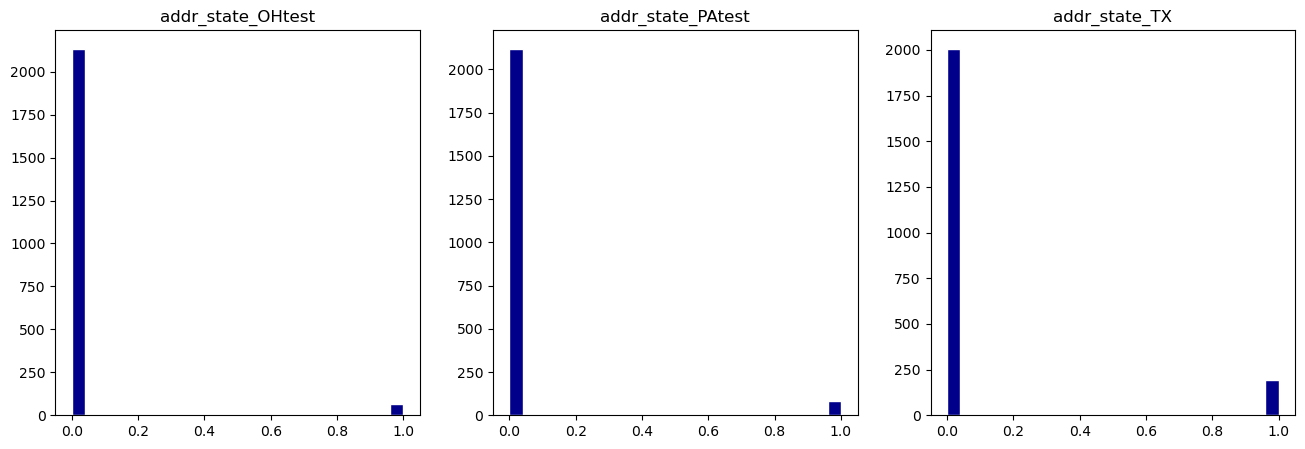

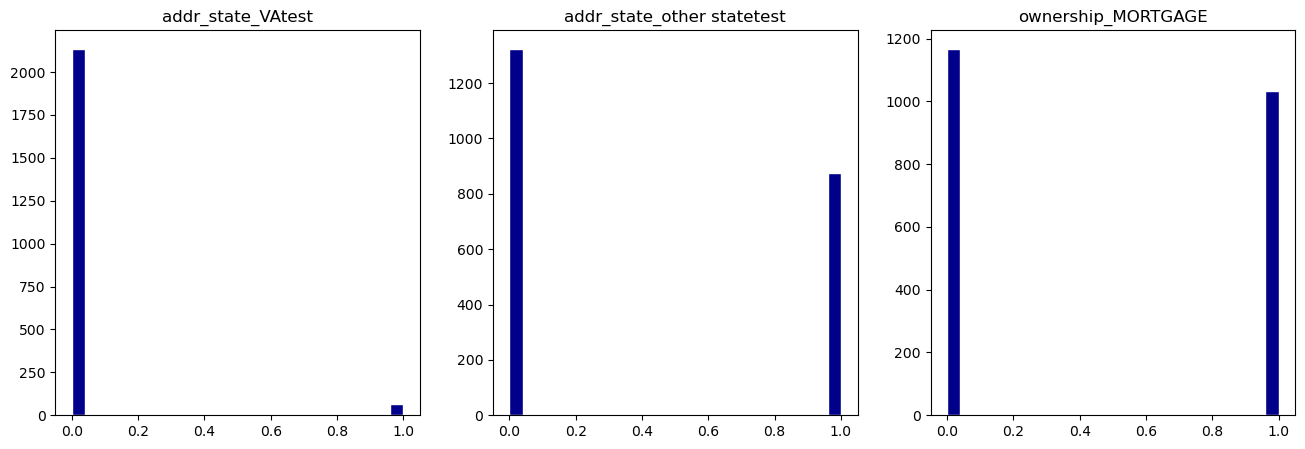

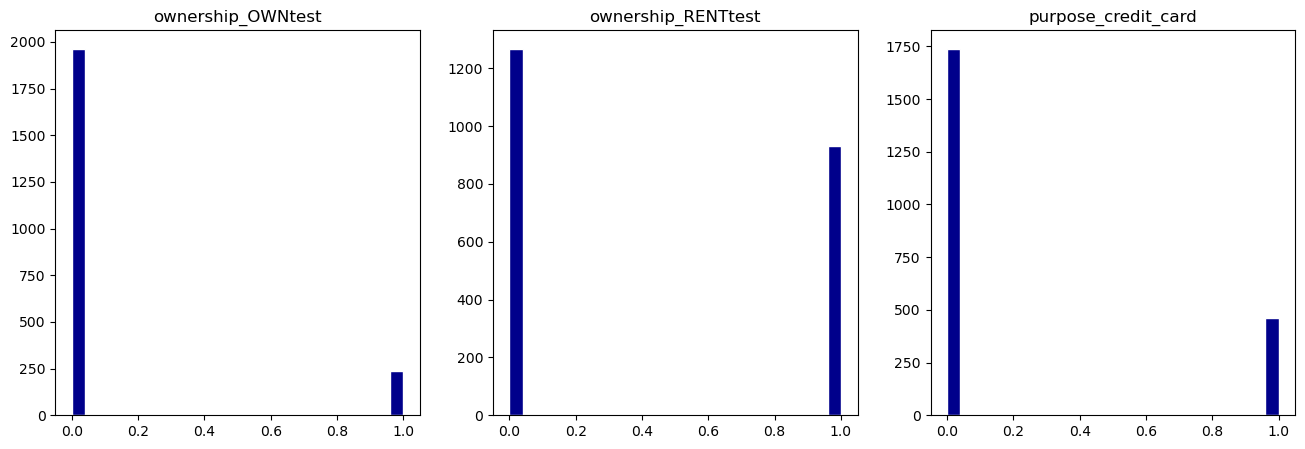

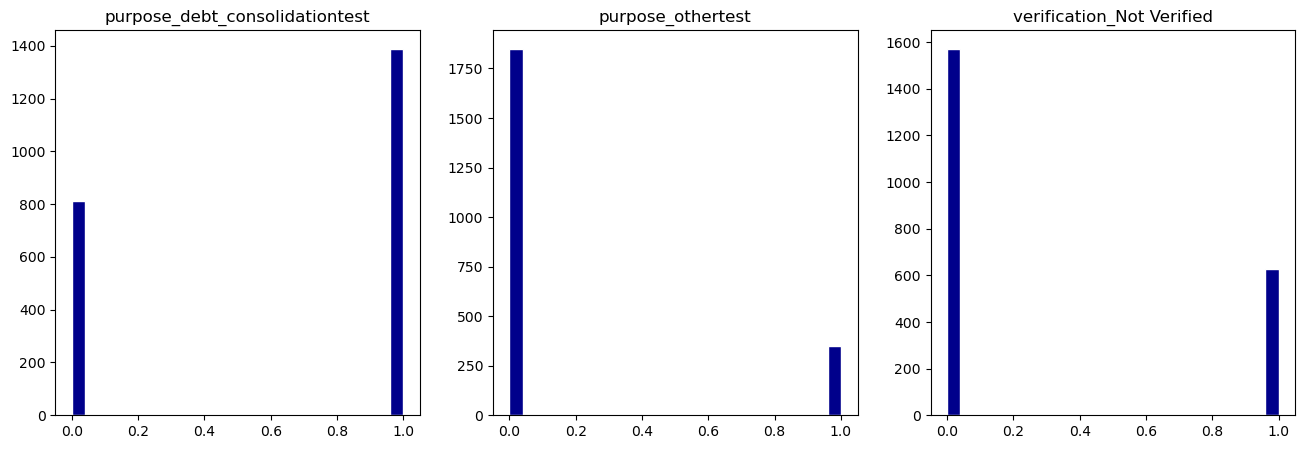

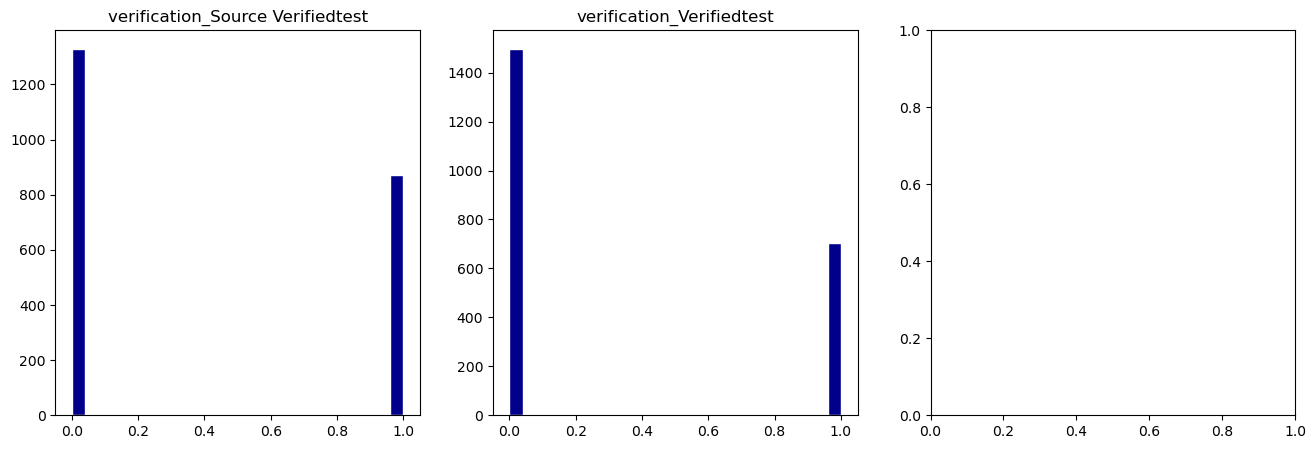

In [178]:
numerical_columns = X_train.columns

# train
for i in np.arange(0,len(numerical_columns),3):

    fig, ax = plt.subplots(1, 3, figsize=(16,5), sharey=False)
    
    ax[0].hist(X_train[numerical_columns[i]], color = 'darkblue', edgecolor = 'white', bins = 25)
    ax[1].hist(X_train[numerical_columns[i+1]], color = 'darkblue', edgecolor = 'white', bins = 25)
    if i+2 < len(numerical_columns):
        ax[2].hist(X_train[numerical_columns[i+2]], color = 'darkblue', edgecolor = 'white', bins = 25)
        ax[2].set_title(numerical_columns[i+2])
        
    ax[0].set_title(numerical_columns[i]+ 'train')
    ax[1].set_title(numerical_columns[i+1]+ 'train')


# test

for i in np.arange(0,len(numerical_columns),3):

    fig, ax = plt.subplots(1, 3, figsize=(16,5), sharey=False)
    
    ax[0].hist(X_test[numerical_columns[i]], color = 'darkblue', edgecolor = 'white', bins = 25)
    ax[1].hist(X_test[numerical_columns[i+1]], color = 'darkblue', edgecolor = 'white', bins = 25)
    if i+2 < len(numerical_columns):
        ax[2].hist(X_test[numerical_columns[i+2]], color = 'darkblue', edgecolor = 'white', bins = 25)
        ax[2].set_title(numerical_columns[i+2])
        
    ax[0].set_title(numerical_columns[i]+ 'test')
    ax[1].set_title(numerical_columns[i+1]+ 'test')

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics


### Use K-Folds cross validation with 10 folds and 'roc-auc' as your score.

In [181]:
#X_train, X_test, y_train, y_test

In [182]:
# DO THIS HERE

In [183]:
# DO THIS HERE

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

### Use a wide range of classification models. I have added them below to a Python list.

In [186]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# Neural Network
models.append(('NN', MLPClassifier()))
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))

NameError: name 'LogisticRegression' is not defined

### K-folds cross validation

In [ ]:
# DO THIS HERE

In [ ]:
# DO THIS HERE

In [ ]:
# DO THIS HERE

In [ ]:
# DO THIS HERE

### Plot a model comparison using a BoxPlot to capture the range of values coming from the K Folds for each model

In [ ]:
# DO THIS HERE

In [ ]:
# DO THIS HERE

In [ ]:
# DO THIS HERE

<a id='5'></a>
# 6. Model Tuning and Grid Search

### Choose the best model and do some hyperparameter tuning by looping over the hyper parameters of the model to fine-tune the model. Do this using the GridSearch features in Scikit Learn.

In [ ]:
# DO THIS HERE

In [ ]:
# DO THIS HERE

In [ ]:
# DO THIS HERE

<a id='6'></a>
# 7. Finalise the Model

### Finalize Model with best parameters found during tuning step.

In [ ]:
# DO THIS HERE

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

### Calculate the fine-tuned model results on the test dataset. Calculate accuracy, confusion matrix, the classification report. Discuss results.

In [ ]:
# DO THIS HERE

In [ ]:
# DO THIS HERE

In [ ]:
# DO THIS HERE

In [ ]:
# DO THIS HERE

### Calculate the ROC curve for the model and its AUC

In [ ]:
# DO THIS HERE

In [ ]:
# DO THIS HERE

In [ ]:
# DO THIS HERE

<a id='6.2'></a>
## 7.2. Variable Intuition/Feature Importance
Looking at the details above GBM might be worthy of further study.
Let us look into the Feature Importance of the GBM model

### Examine the importance of each of the model features. Some models may have a features_importances property. For others you may need to loop over features and exclude/include them to determine their impact on the score.

In [ ]:
# DO THIS HERE

In [ ]:
# DO THIS HERE

In [ ]:
# DO THIS HERE

In [ ]:
# DO THIS HERE

In [ ]:
# DO THIS HERE

# My Suggestions

This is where you can put your extra analysis work. Try to keep it to one main idea. This will help your coursework grade, especially if makes the model work better ;-)

In [ ]:
# DO THIS HERE

In [ ]:
# DO THIS HERE

In [ ]:
# DO THIS HERE

In [ ]:
# DO THIS HERE

In [ ]:
# DO THIS HERE

## Conclusion

### Write a short summary of what you have found.

In [ ]:
# DO THIS HERE